# 03 - Predictability & Universe Filtering

### Previously on Stock universe p. s. ...

In our previous efforts to improve generalization and downstream RL performance, we attempted to:
- Apply statistical heuristics to identify "easier" stocks
- Train predictive models to uncover latent structure

While these offered some insight, they lacked **robustness** and **transferability** across time.


### What's next:
We now shift focus toward **meta-characterizing forecastability**, moving beyond surface-level accuracy and toward deeper indicators of *learnability* and *environmental stability*.

#### Meta-Features of Forecasts
I
Instead of evaluating only R² from one-step regressors, we now extract richer *diagnostics from forecast behavior*:

- **Residual Autocorrelation**: Persistence signals underfit
- **ARCH Effects**: Volatility clustering may hint at instability
- **Skew/Kurtosis of Residuals**: Shape mismatches between model and environment
- **Entropy of Forecast Distribution**: High entropy = more chaotic returns

These become meta-features to train models that classify or rank *predictable environments*.


#### Meta-RL Labeling


To ground our theory in agent behavior, we’ll:

1. Train a small RL agent (shallow horizon, simplified environment) on each stock-month
2. Track early performance: Sharpe, alpha, drawdown, or advantage over random
3. Use this as a **proxy label** for "learnability"
4. Aggregate results over time, sectors, and macro states

This creates a **meta-learning dataset** where the labels come from actual agent-environment interactions.


### Pipeline
1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions




### Outcome Goal

Identify **which stocks are more “learnable”** in the near future — not just based on past returns, but through the lens of *how models perform on them*.

---

###  Why This Matters

RL agents don’t just need high alpha — they need *structure they can exploit*. This study explores:
- How to measure that structure
- How to learn from past environments
- How to build a filter that works across regimes

---


| Stage                 | Description                                                                                             |
| --------------------- | ------------------------------------------------------------------------------------------------------- |
| 🧹 Preprocessing      | Clean stock OHLCV data, compute lagged returns                                                          |
| 📈 Forecast Models    | Run simple regressors on next-month returns                                                             |
| 🔍 Diagnostics        | Extract residual meta-features, R², forecast entropy, etc.                                              |
| 🧠 Labeling           | - Regression: R² as target<br>- Ranking: (A > B)<br>- RL Reward: agent learnability                     |
| 📊 Feature Extraction | Use summary stats + diagnostic/meta features                                                            |
| 🧬 Modeling           | - Regression: Predict R²<br>- Classification: Predict "learnable"<br>- Contrastive: Rank predictability |
| 🏆 Output             | Sorted top-k stock-months or environments where RL thrives                                              |


| Section                             | Purpose                                                                                                                                                                                                          |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔧 **Setup & Pipeline Description** | High-level explanation of your RL pipeline, feature engineering, and data sources                                                                                                                                |
| 🧪 **Completed Studies**            | Summary table or list of ablation studies, e.g.:<br>`01 - Reward Function Impact`<br>`02 - Predictability Filters via R²`<br>`03 - Meta-Learnability Scores`                                                     |
| ✅ **Conclusions So Far**            | Bullet points of key findings from each experiment, e.g.:<br>– Simple R² doesn't generalize across time<br>– Residual-based features offer better stability<br>– Meta-RL proxy labels correlate with test Sharpe |
| 🔬 **Ongoing Work**                 | One-liner of what’s running or planned, so future you remembers                                                                                                                                                  |
| 📎 **Notebook Index**               | List of notebooks and what each one covers                                                                                                                                                                       |


We start with both:

First, build the regression pipeline → quick wins, visualization, baseline.

Then, shift to contrastive ranking → build a PairwiseMetaDataset, use XGBoostRanker or SiameseNet.

Ready to begin with the regression version using:

LinearReg + RF residuals

Autocorr / Ljung-Box / ARCH tests

Predict next-month R²?



In [2]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from src.utils.system import boot, Notify
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display
from src.utils.system import boot,notify
from src.experiments.experiment_tracker import ExperimentTracker



from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, acovf


import warnings
warnings.filterwarnings("ignore")


In [3]:
experience_name = "stock_universe_predictability_selection__MetaFeatures__MetaRlLabeling"

excluded_tickers=['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
excluded_tickers.sort()
config={
    "regressor":"RandomForestRegressor",
    "n_estimators": 100,
    "random_state":42
}
run_settings={
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date":"2022-01-01",
    "end_date":"2022-07-01"
}


In [37]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()
_ohlcv=ohlcv_df.copy()

In [5]:
# BASIC PREPROCESSING ===================================
excluded_tickers = run_settings["excluded_tickers"]
min_samples = run_settings["min_samples"]
cv_folds = run_settings["cv_folds"]
lags = run_settings["lags"]
start_date = run_settings["start_date"]
end_date = run_settings["end_date"]

# CROP THE SAMPLE =======================================
tickers = ohlcv_df['symbol'].unique()[:100]
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL","MSFT","JPM","V",'LLY','UNH','AMZN','TSLA','META','GOOGL','GE','UBER','COST','WMT','XOM','CVX'.'NEE','SO','AMT','PLD','LIN','SHW']

# FOR POC ONLY


ohlcv_df = ohlcv_df.copy()
ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= start_date) & (ohlcv_df['date'] < end_date)]
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)


In [6]:
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

In [7]:
#ohlcv_df.sort_values(by="date").head().to_csv('ohlcv_to_upload.csv')

## Quick Recap
We want to estimate how "predictable" each stock is in a given month, using meta-features of its behavior.

#### Pipeline: 
**Loop: For each (stock, month)**
From Previous Month (t) we will extract features. From the returns in month t, we compute:
* Mean
* Std 
* Skew 
* Kurtosis
* Entropy of returns
* Mean of volumne
* Std of volume

These become the meta-features for that stock-month.

**From Following Month (t+1) we will compute "predictability"**

* With 5 lags of daily returns from month t+1 will try to predict daily returns using a RandomForestRegressor
* Evaluate performance with cross-validated R² (cv_r2)
* Analyze residuals from this model with the Ljung–Box test for autocorrelation ⇒ gives ljung_pval

These become the target labels or diagnostic scores

| Feature                 | Description                                        |
| ----------------------- | -------------------------------------------------- |
| `resid_acf1`            | Autocorrelation of residuals (lag 1)               |
| `resid_std`             | Std of residuals                                   |
| `resid_skew`            | Skewness of residuals                              |
| `resid_kurtosis`        | Kurtosis of residuals                              |
| `resid_ljung_pval`      | p-value of Ljung-Box test for residual autocorr    |
| `return_autocorr_1d`    | Lag-1 autocorrelation of raw 1D returns            |
| `volatility_clustering` | Rolling std autocorrelation (vol clustering proxy) |


In [20]:
# FEATURE + LABEL EXTRACTION ============================
features, targets, metadata = [], [], []
def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]
    
for symbol in tqdm(tickers):

    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df['month'] = df['date'].dt.to_period('M')
    months = df['month'].unique()
  
    for i in range(1, len(months)):
        m_t = months[i-1]
        m_t1 = months[i]

        df_t = df[df['month'] == m_t]
        df_t1 = df[df['month'] == m_t1]
        
        if len(df_t1) < min_samples:
            continue
        
        # Feature engineering from month t ---
        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),#r1d.mean(),
            'std_return': r1d.std(),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
            'vol_mean': mean_policy(v),#v.mean(),
            'vol_std': v.std()
        }

        # Residual diagnostics from simple RF on t+1
        df_lag = df_t1.copy()
        
        for lag in range(1,  run_settings['lags'] + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
            
       
        df_lag = df_lag.dropna()
        if len(df_lag) < min_samples:
            continue
        
        
        
        X = df_lag[[f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
        model.fit(X, y)
        
        residuals = y - model.predict(X)
                
        # Meta-diagnostics ---
        ljung_pval = acorr_ljungbox(residuals, lags=[run_settings['lags']], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        # Predictability label (cross-val R²) ---
        cv_r2 = mean_policy(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))#.mean()
        #print({"cv_r2":cv_r2,"ljung_pval":ljung_pval})
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


100%|██████████| 100/100 [05:56<00:00,  3.57s/it]


In [21]:
# BUILD DTASETS ============================================
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name='cv_r2')
meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])


X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

,symbol,month_str,mean_return,std_return,skew,kurtosis,entropy,vol_median,vol_std,trend_r2,acf_lag_1,acf_lag_2,acf_lag_3,acf_lag_4,acf_lag_5,ljung_pval
0,AAPL,2022-01,-0.004864,0.021790,1.853444,3.843952,1.732552,103899632.0,2.837221e+07,0.871593,0.364593,0.077420,-0.051653,-0.136926,-0.145906,0.567336
1,AAPL,2022-02,-0.001389,0.014507,0.050183,-1.127513,1.995922,93258667.0,1.843377e+07,0.857676,0.202750,-0.456040,-0.375859,-0.047999,0.135575,0.924329
2,AAPL,2022-03,0.005037,0.019492,-0.057035,-1.302837,2.088092,104410428.0,1.763456e+07,0.827672,0.166238,-0.084731,-0.107566,0.243593,0.290095,0.503794
3,AAPL,2022-04,-0.001592,0.020859,0.347075,-0.249996,2.082007,84133031.5,1.924501e+07,0.748626,-0.316736,-0.339796,0.288475,-0.112246,-0.104272,0.879839
4,AAPL,2022-05,0.001747,0.030345,-0.292421,-0.916975,2.070493,121269886.0,2.461844e+07,0.752987,-0.194864,0.023925,-0.245395,0.253852,0.106068,0.999512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,SHW,2022-07,0.003364,0.027952,-1.336802,3.651716,1.639957,1459465.0,1.358882e+06,0.818555,-0.051512,-0.042771,-0.170669,-0.156752,0.079851,0.425632
238,SHW,2022-08,-0.004158,0.020341,0.492825,-0.071426,1.971333,1569652.0,4.264905e+05,0.741818,-0.234639,0.314646,-0.175631,0.023254,-0.271657,0.864652
239,SHW,2022-09,-0.008767,0.019780,0.341255,0.683358,1.938465,1564374.0,4.324850e+05,0.806586,-0.002034,-0.041285,0.075614,-0.421356,0.037303,0.971965
240,SHW,2022-10,0.003088,0.024471,-0.293090,-0.485193,2.070493,1753626.0,4.279297e+05,0.824056,0.080892,-0.056183,-0.125110,-0.241096,0.120686,0.741019


In [44]:
# TIME-BASED TRAIN/TEST SPLIT ===============================


X_df['month_dt'] = pd.to_datetime(X_df['month_str'])

split_date = unique_months[int(0.8 * len(unique_months))]

train_mask = X_df['month_dt'] < split_date
test_mask = X_df['month_dt'] >= split_date

X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
y_train, y_test = y_df[train_mask], y_df[test_mask]
meta_test = meta_df[test_mask.values].copy()

In [76]:
# REGRESSOR TRAINING ========================================
import xgboost as xgb
#final_model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
final_model = RandomForestRegressor(n_estimators=500, random_state=config['random_state'])

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


Test RMSE: 0.6914, R²: -0.0405
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
93    META  2022-06 -0.708509     -0.216626
240    SHW  2022-10 -0.523224     -0.241169
85    TSLA  2022-09 -0.295166     -0.265516
20    MSFT  2022-10 -0.148575     -0.291808
75    AMZN  2022-10 -0.728373     -0.303888
70    AMZN  2022-05 -0.533450     -0.305479
81    TSLA  2022-05 -0.369287     -0.348150
164    XOM  2022-11 -0.619872     -0.365136
213    PLD  2022-05 -0.429693     -0.369293
95    META  2022-08 -0.580593     -0.375788


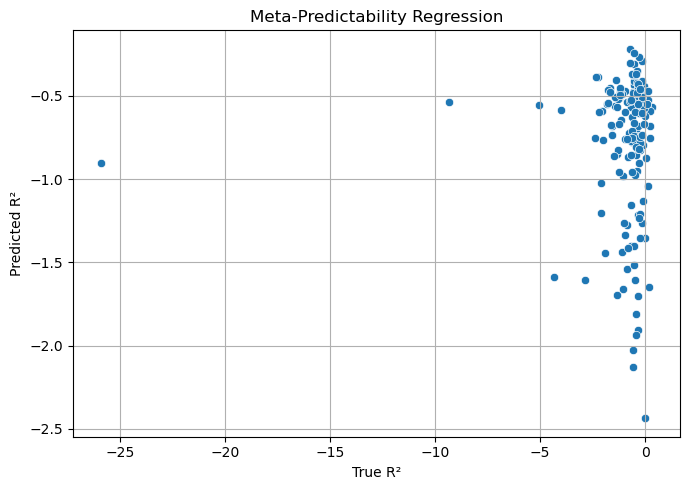

In [77]:
# REGRESSION RESULTS ========================================
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_policy((y_test - y_pred)**2))

print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred

top = meta_test.sort_values('predicted_r2', ascending=False).head(10)
print("Top predictable stock-months:")
print(top)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

# ONLY ON FINAL MODEL
# 100 - Test RMSE: 1.2389, R²: -0.1142
# 300 - Test RMSE: 1.2394, R²: -0.1150 
# 500 - Test RMSE: 1.2317, R²: -0.1013

# WITH MEDIAN AND ROBUST
# 500 - Test RMSE: 0.4345, R²: -0.1013

# WITH EWM
# 500 - Test RMSE: 1.5385, R²: -0.0056

In [ ]:
xxxxxxxxxx

100%|██████████| 22/22 [02:17<00:00,  6.27s/it]


Test RMSE: 4.9117, R²: -17.7307
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
218    PLD  2022-10  0.185921     -0.619568
207    AMT  2022-10 -0.887087     -0.761770
213    PLD  2022-05 -0.627813     -0.777694
196     SO  2022-10 -0.590242     -0.966158
203    AMT  2022-06 -0.576997     -0.988193
219    PLD  2022-11 -0.643562     -1.030439
195     SO  2022-09 -0.540650     -1.044959
206    AMT  2022-09 -1.637163     -1.066930
228    LIN  2022-09 -0.434680     -1.075967
227    LIN  2022-08 -0.761476     -1.109294


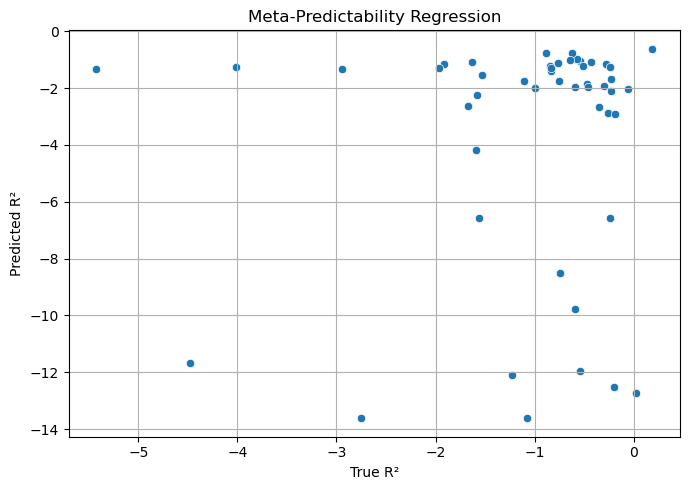

In [79]:
# Predictability Meta-Feature Pipeline with Structural Diagnostics

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
min_samples = 10
cv_folds = 3
lag_window = 5

# === DATA ===
df = ohlcv_df[(ohlcv_df['date'] >= "2022-01-01") & (ohlcv_df['date'] < "2023-01-01")].copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['return_1d'] = df['return_1d'].fillna(0)
df.drop(columns=["sector_id", "industry_id"], inplace=True)

# === TICKERS ===
tickers = ["AAPL", "MSFT", "JPM", "V", 'LLY', 'UNH', 'AMZN', 'TSLA', 'META', 'GOOGL',
           'GE', 'UBER', 'COST', 'WMT', 'XOM', 'CVX', 'NEE', 'SO', 'AMT', 'PLD', 'LIN', 'SHW']



features, targets, metadata = [], [], []

def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]

# === FEATURE + LABEL EXTRACTION ===
for symbol in tqdm(tickers):
    symbol_df = df[df['symbol'] == symbol].sort_values('date').copy()
    months = symbol_df['month'].unique()

    for i in range(1, len(months)):
        m_t = months[i - 1]
        m_t1 = months[i]

        df_t = symbol_df[symbol_df['month'] == m_t].copy()
        df_t1 = symbol_df[symbol_df['month'] == m_t1].copy()

        if len(df_t1) < min_samples:
            continue

        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        hist = np.histogram(r1d, bins=10, density=True)[0] + 1e-8
        acf_vals = acf(r1d, nlags=5, fft=True)[1:6]  # exclude lag 0
        acf_names = {f'acf_lag_{i+1}': val for i, val in enumerate(acf_vals)}

        time_idx = np.arange(len(r1d)).reshape(-1, 1)
        try:
            trend_r2 = RandomForestRegressor().fit(time_idx, r1d).score(time_idx, r1d)
        except:
            trend_r2 = 0

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),
            'std_return': np.std(r1d),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(hist),
            'vol_median': mean_policy(v),
            'vol_std': np.std(v),
            'trend_r2': trend_r2,
            **acf_names
        }

        # Residual diagnostics on t+1
        df_lag = df_t1.copy()
        for lag in range(1, lag_window + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag = df_lag.dropna()

        if len(df_lag) < min_samples:
            continue

        X = df_lag[[f'return_lag_{i}' for i in range(1, lag_window + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        residuals = y - model.predict(X)

        ljung_pval = acorr_ljungbox(residuals, lags=[lag_window], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        cv_r2 = np.mean(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


Test RMSE: 4.9117, R²: -17.7307
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
218    PLD  2022-10  0.185921     -0.619568
207    AMT  2022-10 -0.887087     -0.761770
213    PLD  2022-05 -0.627813     -0.777694
196     SO  2022-10 -0.590242     -0.966158
203    AMT  2022-06 -0.576997     -0.988193
219    PLD  2022-11 -0.643562     -1.030439
195     SO  2022-09 -0.540650     -1.044959
206    AMT  2022-09 -1.637163     -1.066930
228    LIN  2022-09 -0.434680     -1.075967
227    LIN  2022-08 -0.761476     -1.109294


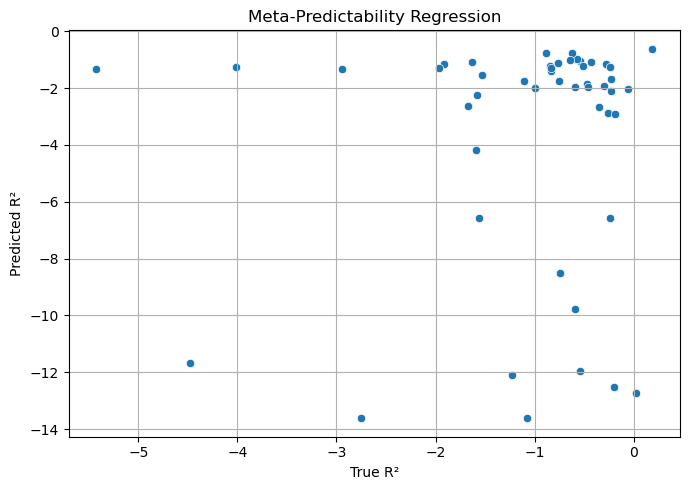

In [81]:

# === DATAFRAME PREP ===
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name="cv_r2")
X_df['month_dt'] = pd.to_datetime(X_df['month_str'])
meta_df = pd.DataFrame(metadata, columns=["symbol", "month"])
X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

# === SCALING ===
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# === SPLIT ===
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_df[:split_idx], y_df[split_idx:]
meta_test = meta_df.iloc[split_idx:].copy()

# === REGRESSOR TRAINING ===
final_model = RandomForestRegressor(n_estimators=500, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# === METRICS ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred
print("Top predictable stock-months:")
print(meta_test.sort_values('predicted_r2', ascending=False).head(10))

# === VISUALIZATION ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
# === Contrastive Dataset Builder ===
import random
from sklearn.utils import shuffle


def build_contrastive_dataset(X, y, meta, n_pairs=20000, margin=0.02):
    X_pairs = []
    y_pairs = []
    meta_pairs = []

    num_samples = len(y)
    attempts = 0
    max_attempts = n_pairs * 10

    while len(X_pairs) < n_pairs and attempts < max_attempts:
        i, j = np.random.choice(num_samples, size=2, replace=False)
        r2_i, r2_j = y[i], y[j]

        diff = r2_i - r2_j
        if abs(diff) < margin:
            attempts += 1
            continue

        if diff > 0:
            X_diff = X[i] - X[j]
            y_label = 1
        else:
            X_diff = X[j] - X[i]
            y_label = 0

        X_pairs.append(X_diff)
        y_pairs.append(y_label)
        meta_pairs.append((meta.iloc[i].to_dict(), meta.iloc[j].to_dict()))
        attempts += 1

    return np.array(X_pairs), np.array(y_pairs), meta_pairs

# === Contrastive Model ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def train_contrastive_model(X_pairs, y_pairs):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_pairs, y_pairs)
    return clf


# === Scoring Function from Single Sample ===
class ScoringWrapper:
    def __init__(self, model):
        self.model = model

    def score(self, x):
        # Compare x to 0-vector (neutral baseline)
        x = x.reshape(1, -1)
        return self.model.decision_function(x)[0]


# === Example Usage ===
# X_scaled, y_df, meta_df assumed to exist

X_pairs, y_pairs, meta_pairs = build_contrastive_dataset(X_scaled, y_df.values, meta_df, n_pairs=20000, margin=0.02)
print("Class distribution:", np.bincount(y_pairs))

contrastive_model = train_contrastive_model(X_pairs, y_pairs)
scorer = ScoringWrapper(contrastive_model)
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores

# Score individual months:
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores
meta_df['true_r2'] = y_df.values
# Top predictable stock-months by contrastive model:
top_ranked = meta_df.sort_values('score', ascending=False).head(10)
print(top_ranked)


Class distribution: [ 9967 10033]
    symbol    month     score    true_r2
1     AAPL  2022-02  0.167660  -2.391725
84    TSLA  2022-08  0.143005  -1.018681
3     AAPL  2022-04  0.121884  -0.783627
71    AMZN  2022-06  0.119581  -0.206225
8     AAPL  2022-09  0.110810  -1.743733
13    MSFT  2022-03  0.095753  -0.760031
25     JPM  2022-04  0.091321  -5.843308
210    PLD  2022-02  0.090479  -0.279033
32     JPM  2022-11  0.087494 -21.387389
4     AAPL  2022-05  0.085433  -1.125503


In [89]:
top = meta_df.sort_values("score", ascending=False).head(10)
bottom = meta_df.sort_values("score", ascending=True).head(10)

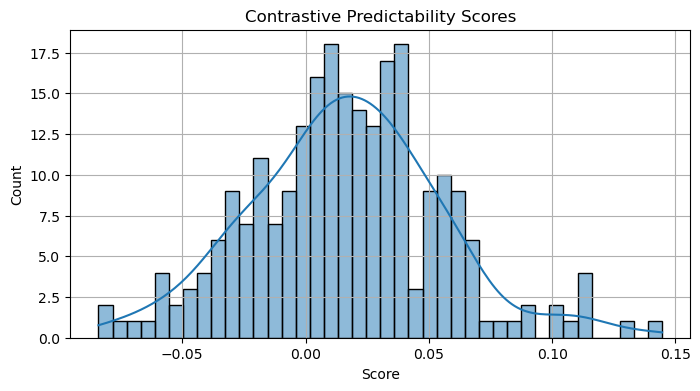

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(meta_df['score'], bins=40, kde=True)
plt.title("Contrastive Predictability Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

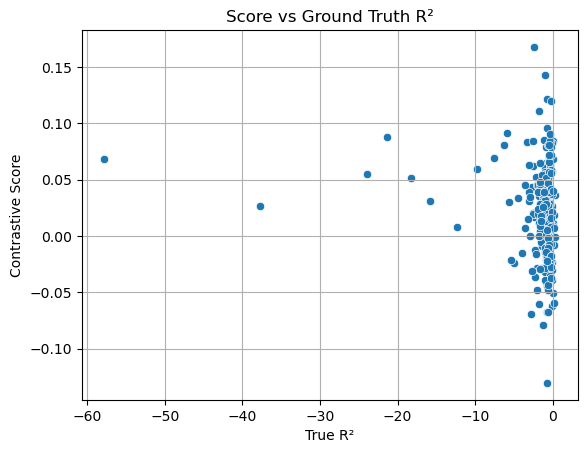

In [95]:
sns.scatterplot(data=meta_df, x='true_r2', y='score')
plt.xlabel("True R²")
plt.ylabel("Contrastive Score")
plt.title("Score vs Ground Truth R²")
plt.grid(True)
plt.show()

In [93]:
xxxxxxxxxxxxxxxxxxxxx

0     -0.346768
1     -2.391725
2     -0.797673
3     -0.783627
4     -1.125503
         ...   
237   -5.422301
238   -0.199645
239   -1.076902
240   -1.224698
241    0.021795
Name: cv_r2, Length: 242, dtype: float64

In [165]:
# Agent-Based Meta-Labeling (Advantage Estimation)
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
import warnings
warnings.filterwarnings("ignore")
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
# === ADVANTAGE FUNCTION ===
def compute_agent_advantage(df, symbol, month_str):
    df_symbol = df[df['symbol'] == symbol].copy()
    df_symbol['month'] = df_symbol['date'].dt.to_period("M")
    df_month = df_symbol[df_symbol['month'] == pd.Period(month_str)]
    df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1]

    if len(df_next) < min_samples:
        return np.nan

    try:
        # Define environment
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d','symbol']].copy()
        env_df.rename(columns={'symbol':"tic"},inplace=True)
        env_df = env_df.reset_index(drop=True)
        stock_dim = 1
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": 0.001,
            "sell_cost_pct": 0.001,
            "state_space": 6 * stock_dim + 1,
            "stock_dim": stock_dim,
            "tech_indicator_list": ["return_1d"],
            "action_space": stock_dim,
            "reward_scaling": 1e-4,
          "num_stock_shares":1
        }
        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: WrappedStockTradingEnv(df=env_df, **env_kwargs)])
        # Train PPO Agent
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=5000)

        # Evaluate
        obs = env.reset()
        total_reward_agent = 0
        total_reward_random = 0

        for _ in range(len(env_df)):
            action, _states = model.predict(obs)
            obs, rewards, dones, info = env.step(action)
            total_reward_agent += float(rewards)

        # Evaluate random policy
        obs = env.reset()
        for _ in range(len(env_df)):
            action = env.action_space.sample()
            obs, rewards, dones, info = env.step(action)
            total_reward_random += float(rewards)

        advantage = total_reward_agent - total_reward_random
        return advantage

    except Exception as e:
        print(f"Advantage error for {symbol}-{month_str}: {e}")
        return np.nan

# === COMPUTE ADVANTAGE FOR META-DF ===
meta_df['advantage'] = meta_df.apply(lambda row: compute_agent_advantage(df, row['symbol'], row['month']), axis=1)

# === ADVANTAGE RESULTS ===
print("Top agent-advantaged stock-months:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# === Save Results (Optional) ===
# meta_df.to_csv("predictability_meta_results.csv", index=False)


Advantage error for AAPL-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-07: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-09: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for 

Advantage error for META-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for META-2022-11: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-07: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage er

Advantage error for SO-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-09: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-11: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-07: c

In [278]:
features

[{'symbol': 'AAPL',
  'month_str': '2022-01',
  'mean_return': 0.021726019946647062,
  'std_return': 0.02178991098158032,
  'skew': 1.8534440227591726,
  'kurtosis': 3.8439523470302204,
  'entropy': 1.7325520948802842,
  'vol_median': 141194416.92695978,
  'vol_std': 28372209.77293765,
  'trend_r2': 0.8820469670573307,
  'acf_lag_1': 0.36459283216356836,
  'acf_lag_2': 0.07742041722989994,
  'acf_lag_3': -0.05165256631103723,
  'acf_lag_4': -0.1369262828081972,
  'acf_lag_5': -0.14590564494921404,
  'ljung_pval': 0.5673356519227388},
 {'symbol': 'AAPL',
  'month_str': '2022-02',
  'mean_return': 0.0013049039094063515,
  'std_return': 0.014507309493788286,
  'skew': 0.05018273027506859,
  'kurtosis': -1.1275126626693963,
  'entropy': 1.9959217869653123,
  'vol_median': 108430322.28948702,
  'vol_std': 18433765.957113903,
  'trend_r2': 0.8482322124445283,
  'acf_lag_1': 0.20275044013950794,
  'acf_lag_2': -0.45603982750182565,
  'acf_lag_3': -0.37585855995014184,
  'acf_lag_4': -0.047998

In [271]:
# === Agent-Based Meta-Labeling: Advantage Estimation ===
import pandas as pd
import numpy as np
import gym
import warnings
import time
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

warnings.filterwarnings("ignore")

# === PPO Utility Functions ===

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, _,done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
    
class PatchedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        #print('pst', actions)
        obs, reward, done,truncated, info = super().step(actions)
        #print('pst2')
        reward = np.array([reward], dtype=np.float32)
        done = np.array([done])
        info = [info]
        
        # SB3 expects 5 items: obs, reward, terminated, truncated, info
        info = {"dummy": True}
        return obs, reward, done, done, info
    
def train_ppo_agent(env, timesteps=5000):

    model = PPO("MlpPolicy", env, verbose=0)
  
    model.learn(total_timesteps=timesteps)

    return model
def evaluate_policy(env, model, steps):
    obs = env.reset()
    total_reward = 0

    for _ in range(steps):
       
        action, _ = model.predict(obs)
     
        truncated = False
        obs, rewards, terminated, info = env.step(action)

        done = terminated or truncated
     
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    #print('xxx 5',total_reward)
    return total_reward

def evaluate_random(env, steps):
    #print('x')
    obs = env.reset()
    #print('x1',steps)
    total_reward = 0
    for _ in range(steps):
        #print('x2',env.action_space.sample())
        action = env.action_space.sample()
        #print('x3',action)
        truncated = False
        #print('x4',env.step(np.array([action]).astype(np.float32)))
        obs, rewards, terminated, info = env.step(np.array([action]).astype(np.float32))
        #print('x5',rewards)
        done = terminated or truncated
        #print(f"Type of rewards: {type(rewards)}, value: {rewards}")
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    return total_reward


# === ADVANTAGE FUNCTION ===

def compute_agent_advantage(df, symbol, month_str, min_samples=10):
    try:
        #print(month_str)
        df_symbol = df[df['symbol'] == symbol].copy()
        df_symbol['month'] = df_symbol['date'].dt.to_period("M")
        df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1].copy()
        #print(1)
        if len(df_next) < min_samples:
            return np.nan

        # Prepare DataFrame for env
        df_next.rename(columns={"symbol": "tic"}, inplace=True)
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d', 'tic']].reset_index(drop=True)
        #print(2)
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": np.array([0.001]),   # <-- FIXED
            "sell_cost_pct": np.array([0.001]),  # <-- FIXED
            "state_space": 4,
            "stock_dim": 1,
            "tech_indicator_list": ["return_1d"],
            "action_space": 1,
            "reward_scaling": 1e-4,
            "num_stock_shares": 1
        }

        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: PatchedStockTradingEnv(df=env_df, **env_kwargs)])
        #print(3)
        #print(env.reset())
        #print(env.action_space.sample())
        #np.array([env.action_space.sample()]
        #print(env.step([action]))
        print('x')
        # Train PPO and compute reward
        model = train_ppo_agent(env)
        #print(4)
        steps = len(env_df)
        print(4)
        reward_agent = evaluate_policy(env, model, steps)
        print("reward_agent",reward_agent)
        reward_random = evaluate_random(env, steps)
        print("reward_random",reward_agent)
        advantage = reward_agent - reward_random
        print("advantage",advantage)
        #print('y')
        return advantage

    except Exception as e:
        print(f"[Advantage error] {symbol}-{month_str}: {e}")
        return np.nan

# === APPLY TO META_DF ===

print("Computing RL agent advantages... (this may take a while)")
start = time.time()
meta_df['advantage'] = meta_df.apply(
    lambda row: compute_agent_advantage(df, row['symbol'], row['month']),
    axis=1
)
end = time.time()

print(f"Finished in {end - start:.1f} seconds.")
print("\nTop stock-months by RL agent advantage:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# Optional: Save
# meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

Computing RL agent advantages... (this may take a while)
x
day: 18, episode: 10
begin_total_asset: 100174.61
end_total_asset: 99401.91
total_reward: -772.70
total_cost: 86.59
total_trades: 11
Sharpe: -5.545
day: 18, episode: 20
begin_total_asset: 100174.61
end_total_asset: 99992.67
total_reward: -181.94
total_cost: 144.16
total_trades: 16
Sharpe: -0.471
day: 18, episode: 30
begin_total_asset: 100174.61
end_total_asset: 96039.96
total_reward: -4134.65
total_cost: 190.40
total_trades: 17
Sharpe: -3.251
day: 18, episode: 40
begin_total_asset: 100174.61
end_total_asset: 97583.13
total_reward: -2591.48
total_cost: 169.70
total_trades: 18
Sharpe: -4.252
day: 18, episode: 50
begin_total_asset: 100174.61
end_total_asset: 98433.89
total_reward: -1740.72
total_cost: 173.08
total_trades: 17
Sharpe: -2.674
day: 18, episode: 60
begin_total_asset: 100174.61
end_total_asset: 97099.58
total_reward: -3075.03
total_cost: 187.81
total_trades: 18
Sharpe: -3.258
day: 18, episode: 70
begin_total_asset: 1001

day: 22, episode: 130
begin_total_asset: 100163.20
end_total_asset: 100867.99
total_reward: 704.79
total_cost: 195.64
total_trades: 18
Sharpe: 1.938
day: 22, episode: 140
begin_total_asset: 100163.20
end_total_asset: 101835.28
total_reward: 1672.08
total_cost: 174.98
total_trades: 22
Sharpe: 3.239
day: 22, episode: 150
begin_total_asset: 100163.20
end_total_asset: 102322.67
total_reward: 2159.47
total_cost: 201.58
total_trades: 20
Sharpe: 4.979
day: 22, episode: 160
begin_total_asset: 100163.20
end_total_asset: 107127.95
total_reward: 6964.75
total_cost: 254.54
total_trades: 22
Sharpe: 6.463
day: 22, episode: 170
begin_total_asset: 100163.20
end_total_asset: 108479.98
total_reward: 8316.78
total_cost: 189.69
total_trades: 22
Sharpe: 3.982
day: 22, episode: 180
begin_total_asset: 100163.20
end_total_asset: 106729.01
total_reward: 6565.81
total_cost: 154.15
total_trades: 21
Sharpe: 5.715
day: 22, episode: 190
begin_total_asset: 100163.20
end_total_asset: 106965.04
total_reward: 6801.84
t

day: 20, episode: 10
begin_total_asset: 100157.96
end_total_asset: 102483.36
total_reward: 2325.40
total_cost: 154.52
total_trades: 17
Sharpe: 3.043
day: 20, episode: 20
begin_total_asset: 100157.96
end_total_asset: 102426.75
total_reward: 2268.79
total_cost: 188.35
total_trades: 18
Sharpe: 1.796
day: 20, episode: 30
begin_total_asset: 100157.96
end_total_asset: 99091.17
total_reward: -1066.79
total_cost: 138.17
total_trades: 16
Sharpe: -2.350
day: 20, episode: 40
begin_total_asset: 100157.96
end_total_asset: 99581.56
total_reward: -576.40
total_cost: 177.32
total_trades: 20
Sharpe: -0.177
day: 20, episode: 50
begin_total_asset: 100157.96
end_total_asset: 99677.16
total_reward: -480.80
total_cost: 124.37
total_trades: 19
Sharpe: -1.023
day: 20, episode: 60
begin_total_asset: 100157.96
end_total_asset: 99191.77
total_reward: -966.19
total_cost: 162.02
total_trades: 18
Sharpe: -0.483
day: 20, episode: 70
begin_total_asset: 100157.96
end_total_asset: 97408.02
total_reward: -2749.94
total_

day: 20, episode: 170
begin_total_asset: 100148.71
end_total_asset: 100438.31
total_reward: 289.60
total_cost: 59.50
total_trades: 8
Sharpe: 2.553
day: 20, episode: 180
begin_total_asset: 100148.71
end_total_asset: 98957.23
total_reward: -1191.48
total_cost: 172.02
total_trades: 20
Sharpe: -3.168
day: 20, episode: 190
begin_total_asset: 100148.71
end_total_asset: 99015.65
total_reward: -1133.06
total_cost: 93.61
total_trades: 16
Sharpe: -3.137
day: 20, episode: 200
begin_total_asset: 100148.71
end_total_asset: 100858.65
total_reward: 709.94
total_cost: 181.13
total_trades: 17
Sharpe: 2.835
day: 20, episode: 210
begin_total_asset: 100148.71
end_total_asset: 100784.24
total_reward: 635.53
total_cost: 103.39
total_trades: 14
Sharpe: 2.552
day: 20, episode: 220
begin_total_asset: 100148.71
end_total_asset: 100850.56
total_reward: 701.85
total_cost: 138.50
total_trades: 16
Sharpe: 1.356
day: 20, episode: 230
begin_total_asset: 100148.71
end_total_asset: 99772.12
total_reward: -376.59
total_

day: 22, episode: 20
begin_total_asset: 100161.51
end_total_asset: 94362.09
total_reward: -5799.42
total_cost: 187.09
total_trades: 20
Sharpe: -3.862
day: 22, episode: 30
begin_total_asset: 100161.51
end_total_asset: 97203.68
total_reward: -2957.83
total_cost: 230.19
total_trades: 20
Sharpe: -4.942
day: 22, episode: 40
begin_total_asset: 100161.51
end_total_asset: 97231.91
total_reward: -2929.60
total_cost: 168.93
total_trades: 19
Sharpe: -4.063
day: 22, episode: 50
begin_total_asset: 100161.51
end_total_asset: 100629.81
total_reward: 468.30
total_cost: 191.88
total_trades: 17
Sharpe: 1.268
day: 22, episode: 60
begin_total_asset: 100161.51
end_total_asset: 97343.08
total_reward: -2818.43
total_cost: 243.53
total_trades: 22
Sharpe: -3.173
day: 22, episode: 70
begin_total_asset: 100161.51
end_total_asset: 98966.53
total_reward: -1194.98
total_cost: 139.34
total_trades: 16
Sharpe: -5.774
day: 22, episode: 80
begin_total_asset: 100161.51
end_total_asset: 98313.27
total_reward: -1848.24
tot

day: 20, episode: 200
begin_total_asset: 100157.96
end_total_asset: 99434.27
total_reward: -723.69
total_cost: 103.75
total_trades: 14
Sharpe: -4.920
day: 20, episode: 210
begin_total_asset: 100157.96
end_total_asset: 98939.56
total_reward: -1218.40
total_cost: 109.56
total_trades: 15
Sharpe: -4.707
day: 20, episode: 220
begin_total_asset: 100157.96
end_total_asset: 98666.52
total_reward: -1491.44
total_cost: 158.37
total_trades: 17
Sharpe: -2.658
day: 20, episode: 230
begin_total_asset: 100157.96
end_total_asset: 97670.90
total_reward: -2487.06
total_cost: 114.55
total_trades: 15
Sharpe: -5.874
day: 20, episode: 240
begin_total_asset: 100157.96
end_total_asset: 98583.57
total_reward: -1574.39
total_cost: 97.16
total_trades: 13
Sharpe: -4.833
day: 20, episode: 250
begin_total_asset: 100157.96
end_total_asset: 99179.26
total_reward: -978.70
total_cost: 53.32
total_trades: 12
Sharpe: -6.018
day: 20, episode: 260
begin_total_asset: 100157.96
end_total_asset: 99926.89
total_reward: -231.07

day: 20, episode: 60
begin_total_asset: 100150.65
end_total_asset: 99917.61
total_reward: -233.04
total_cost: 179.44
total_trades: 20
Sharpe: -0.419
day: 20, episode: 70
begin_total_asset: 100150.65
end_total_asset: 99018.23
total_reward: -1132.42
total_cost: 125.15
total_trades: 16
Sharpe: -2.496
day: 20, episode: 80
begin_total_asset: 100150.65
end_total_asset: 99597.13
total_reward: -553.52
total_cost: 127.01
total_trades: 19
Sharpe: -1.327
day: 20, episode: 90
begin_total_asset: 100150.65
end_total_asset: 99422.33
total_reward: -728.32
total_cost: 140.86
total_trades: 17
Sharpe: -0.861
day: 20, episode: 100
begin_total_asset: 100150.65
end_total_asset: 101399.71
total_reward: 1249.06
total_cost: 187.66
total_trades: 20
Sharpe: 1.075
day: 20, episode: 110
begin_total_asset: 100150.65
end_total_asset: 99298.96
total_reward: -851.69
total_cost: 171.88
total_trades: 17
Sharpe: -0.741
day: 20, episode: 120
begin_total_asset: 100150.65
end_total_asset: 101523.66
total_reward: 1373.01
tot

day: 20, episode: 220
begin_total_asset: 100148.31
end_total_asset: 99126.93
total_reward: -1021.38
total_cost: 102.66
total_trades: 11
Sharpe: -3.515
day: 20, episode: 230
begin_total_asset: 100148.31
end_total_asset: 99238.60
total_reward: -909.71
total_cost: 103.25
total_trades: 13
Sharpe: -4.982
day: 20, episode: 240
begin_total_asset: 100148.31
end_total_asset: 98775.50
total_reward: -1372.81
total_cost: 124.65
total_trades: 15
Sharpe: -2.619
day: 20, episode: 250
begin_total_asset: 100148.31
end_total_asset: 99759.94
total_reward: -388.37
total_cost: 38.40
total_trades: 10
Sharpe: -4.636
day: 20, episode: 260
begin_total_asset: 100148.31
end_total_asset: 99175.05
total_reward: -973.26
total_cost: 109.91
total_trades: 12
Sharpe: -1.780
day: 20, episode: 270
begin_total_asset: 100148.31
end_total_asset: 99279.18
total_reward: -869.13
total_cost: 101.29
total_trades: 17
Sharpe: -6.281
day: 20, episode: 280
begin_total_asset: 100148.31
end_total_asset: 98801.76
total_reward: -1346.55

day: 22, episode: 50
begin_total_asset: 100294.95
end_total_asset: 105918.40
total_reward: 5623.45
total_cost: 234.43
total_trades: 18
Sharpe: 3.883
day: 22, episode: 60
begin_total_asset: 100294.95
end_total_asset: 99520.91
total_reward: -774.04
total_cost: 227.08
total_trades: 15
Sharpe: -1.001
day: 22, episode: 70
begin_total_asset: 100294.95
end_total_asset: 103693.61
total_reward: 3398.66
total_cost: 338.12
total_trades: 21
Sharpe: 1.750
day: 22, episode: 80
begin_total_asset: 100294.95
end_total_asset: 99056.18
total_reward: -1238.77
total_cost: 363.99
total_trades: 21
Sharpe: -0.797
day: 22, episode: 90
begin_total_asset: 100294.95
end_total_asset: 101610.62
total_reward: 1315.67
total_cost: 331.34
total_trades: 20
Sharpe: 0.682
day: 22, episode: 100
begin_total_asset: 100294.95
end_total_asset: 102046.30
total_reward: 1751.35
total_cost: 375.03
total_trades: 20
Sharpe: 1.393
day: 22, episode: 110
begin_total_asset: 100294.95
end_total_asset: 102316.37
total_reward: 2021.42
tota

day: 19, episode: 230
begin_total_asset: 100309.42
end_total_asset: 102297.84
total_reward: 1988.42
total_cost: 296.32
total_trades: 19
Sharpe: 1.955
day: 19, episode: 240
begin_total_asset: 100309.42
end_total_asset: 97616.56
total_reward: -2692.86
total_cost: 191.77
total_trades: 15
Sharpe: -7.367
day: 19, episode: 250
begin_total_asset: 100309.42
end_total_asset: 99356.22
total_reward: -953.20
total_cost: 148.52
total_trades: 11
Sharpe: -3.218
day: 19, episode: 260
begin_total_asset: 100309.42
end_total_asset: 97645.97
total_reward: -2663.45
total_cost: 171.84
total_trades: 11
Sharpe: -4.344
day: 19, episode: 270
begin_total_asset: 100309.42
end_total_asset: 94672.87
total_reward: -5636.55
total_cost: 301.56
total_trades: 16
Sharpe: -3.942
day: 19, episode: 280
begin_total_asset: 100309.42
end_total_asset: 97217.67
total_reward: -3091.75
total_cost: 322.02
total_trades: 17
Sharpe: -3.317
day: 19, episode: 290
begin_total_asset: 100309.42
end_total_asset: 99269.71
total_reward: -1039

day: 20, episode: 80
begin_total_asset: 100272.42
end_total_asset: 98720.35
total_reward: -1552.07
total_cost: 205.96
total_trades: 14
Sharpe: -3.579
day: 20, episode: 90
begin_total_asset: 100272.42
end_total_asset: 98771.37
total_reward: -1501.05
total_cost: 207.18
total_trades: 17
Sharpe: -2.649
day: 20, episode: 100
begin_total_asset: 100272.42
end_total_asset: 97809.41
total_reward: -2463.01
total_cost: 261.98
total_trades: 17
Sharpe: -3.900
day: 20, episode: 110
begin_total_asset: 100272.42
end_total_asset: 97421.99
total_reward: -2850.43
total_cost: 338.82
total_trades: 18
Sharpe: -3.068
day: 20, episode: 120
begin_total_asset: 100272.42
end_total_asset: 100720.65
total_reward: 448.23
total_cost: 214.97
total_trades: 17
Sharpe: 0.555
day: 20, episode: 130
begin_total_asset: 100272.42
end_total_asset: 99426.16
total_reward: -846.26
total_cost: 206.10
total_trades: 15
Sharpe: -1.551
day: 20, episode: 140
begin_total_asset: 100272.42
end_total_asset: 97166.87
total_reward: -3105.55

day: 19, episode: 240
begin_total_asset: 100259.58
end_total_asset: 100325.36
total_reward: 65.78
total_cost: 129.71
total_trades: 10
Sharpe: 0.266
day: 19, episode: 250
begin_total_asset: 100259.58
end_total_asset: 107974.06
total_reward: 7714.48
total_cost: 169.97
total_trades: 17
Sharpe: 3.485
day: 19, episode: 260
begin_total_asset: 100259.58
end_total_asset: 107816.90
total_reward: 7557.32
total_cost: 244.85
total_trades: 17
Sharpe: 3.359
day: 19, episode: 270
begin_total_asset: 100259.58
end_total_asset: 105415.73
total_reward: 5156.15
total_cost: 234.10
total_trades: 19
Sharpe: 2.149
day: 19, episode: 280
begin_total_asset: 100259.58
end_total_asset: 107173.26
total_reward: 6913.68
total_cost: 176.34
total_trades: 19
Sharpe: 2.771
day: 19, episode: 290
begin_total_asset: 100259.58
end_total_asset: 108280.62
total_reward: 8021.04
total_cost: 224.38
total_trades: 18
Sharpe: 3.705
day: 19, episode: 300
begin_total_asset: 100259.58
end_total_asset: 103287.98
total_reward: 3028.40
to

day: 20, episode: 120
begin_total_asset: 100260.40
end_total_asset: 98058.06
total_reward: -2202.34
total_cost: 208.85
total_trades: 18
Sharpe: -3.431
day: 20, episode: 130
begin_total_asset: 100260.40
end_total_asset: 97755.20
total_reward: -2505.20
total_cost: 240.28
total_trades: 17
Sharpe: -6.714
day: 20, episode: 140
begin_total_asset: 100260.40
end_total_asset: 97436.10
total_reward: -2824.30
total_cost: 223.89
total_trades: 19
Sharpe: -4.615
day: 20, episode: 150
begin_total_asset: 100260.40
end_total_asset: 99703.46
total_reward: -556.94
total_cost: 195.80
total_trades: 17
Sharpe: -1.960
day: 20, episode: 160
begin_total_asset: 100260.40
end_total_asset: 100708.82
total_reward: 448.42
total_cost: 103.90
total_trades: 11
Sharpe: 2.428
day: 20, episode: 170
begin_total_asset: 100260.40
end_total_asset: 97138.05
total_reward: -3122.35
total_cost: 175.61
total_trades: 16
Sharpe: -6.094
day: 20, episode: 180
begin_total_asset: 100260.40
end_total_asset: 99292.06
total_reward: -968.3

day: 20, episode: 270
begin_total_asset: 100240.74
end_total_asset: 97473.42
total_reward: -2767.32
total_cost: 219.87
total_trades: 15
Sharpe: -1.947
day: 20, episode: 280
begin_total_asset: 100240.74
end_total_asset: 99913.20
total_reward: -327.54
total_cost: 130.84
total_trades: 11
Sharpe: -1.377
day: 20, episode: 290
begin_total_asset: 100240.74
end_total_asset: 94641.27
total_reward: -5599.47
total_cost: 200.82
total_trades: 16
Sharpe: -8.565
4
reward_agent -0.04761316126678139
reward_random -0.04761316126678139
advantage -0.02736140601336956
x
day: 20, episode: 10
begin_total_asset: 100228.17
end_total_asset: 102192.61
total_reward: 1964.44
total_cost: 176.01
total_trades: 15
Sharpe: 3.256
day: 20, episode: 20
begin_total_asset: 100228.17
end_total_asset: 110279.13
total_reward: 10050.96
total_cost: 284.23
total_trades: 20
Sharpe: 4.318
day: 20, episode: 30
begin_total_asset: 100228.17
end_total_asset: 107059.26
total_reward: 6831.09
total_cost: 289.37
total_trades: 17
Sharpe: 4.

day: 20, episode: 130
begin_total_asset: 100254.69
end_total_asset: 100296.56
total_reward: 41.87
total_cost: 105.90
total_trades: 10
Sharpe: 0.270
day: 20, episode: 140
begin_total_asset: 100254.69
end_total_asset: 95553.43
total_reward: -4701.26
total_cost: 270.59
total_trades: 19
Sharpe: -3.556
day: 20, episode: 150
begin_total_asset: 100254.69
end_total_asset: 100397.59
total_reward: 142.90
total_cost: 252.21
total_trades: 16
Sharpe: 0.400
day: 20, episode: 160
begin_total_asset: 100254.69
end_total_asset: 98856.29
total_reward: -1398.40
total_cost: 222.45
total_trades: 15
Sharpe: -3.637
day: 20, episode: 170
begin_total_asset: 100254.69
end_total_asset: 96635.54
total_reward: -3619.15
total_cost: 328.07
total_trades: 18
Sharpe: -3.206
day: 20, episode: 180
begin_total_asset: 100254.69
end_total_asset: 96689.37
total_reward: -3565.32
total_cost: 278.22
total_trades: 19
Sharpe: -3.344
day: 20, episode: 190
begin_total_asset: 100254.69
end_total_asset: 98797.90
total_reward: -1456.79

day: 18, episode: 280
begin_total_asset: 100151.15
end_total_asset: 98559.47
total_reward: -1591.68
total_cost: 101.23
total_trades: 14
Sharpe: -4.427
day: 18, episode: 290
begin_total_asset: 100151.15
end_total_asset: 99054.33
total_reward: -1096.82
total_cost: 86.11
total_trades: 12
Sharpe: -3.711
day: 18, episode: 300
begin_total_asset: 100151.15
end_total_asset: 98747.75
total_reward: -1403.40
total_cost: 80.11
total_trades: 11
Sharpe: -3.177
day: 18, episode: 310
begin_total_asset: 100151.15
end_total_asset: 99520.74
total_reward: -630.41
total_cost: 139.65
total_trades: 15
Sharpe: -2.541
day: 18, episode: 320
begin_total_asset: 100151.15
end_total_asset: 99862.96
total_reward: -288.19
total_cost: 11.34
total_trades: 3
Sharpe: -5.431
4
reward_agent -0.12286465242505074
reward_random -0.12286465242505074
advantage 0.25480777042685077
x
day: 22, episode: 10
begin_total_asset: 100136.45
end_total_asset: 100163.28
total_reward: 26.83
total_cost: 130.17
total_trades: 18
Sharpe: 0.083
d

day: 19, episode: 150
begin_total_asset: 100135.31
end_total_asset: 95873.38
total_reward: -4261.93
total_cost: 138.94
total_trades: 19
Sharpe: -8.280
day: 19, episode: 160
begin_total_asset: 100135.31
end_total_asset: 98712.61
total_reward: -1422.70
total_cost: 144.37
total_trades: 17
Sharpe: -7.480
day: 19, episode: 170
begin_total_asset: 100135.31
end_total_asset: 98884.65
total_reward: -1250.66
total_cost: 67.20
total_trades: 10
Sharpe: -3.066
day: 19, episode: 180
begin_total_asset: 100135.31
end_total_asset: 98332.72
total_reward: -1802.59
total_cost: 114.55
total_trades: 17
Sharpe: -6.038
day: 19, episode: 190
begin_total_asset: 100135.31
end_total_asset: 97755.07
total_reward: -2380.24
total_cost: 113.66
total_trades: 14
Sharpe: -7.924
day: 19, episode: 200
begin_total_asset: 100135.31
end_total_asset: 97414.47
total_reward: -2720.84
total_cost: 106.33
total_trades: 18
Sharpe: -8.264
day: 19, episode: 210
begin_total_asset: 100135.31
end_total_asset: 97850.43
total_reward: -228

4
reward_agent 0.9134782576002181
reward_random 0.9134782576002181
advantage 0.4935302386584226
x
day: 20, episode: 10
begin_total_asset: 100129.91
end_total_asset: 98029.97
total_reward: -2099.94
total_cost: 107.16
total_trades: 18
Sharpe: -6.357
day: 20, episode: 20
begin_total_asset: 100129.91
end_total_asset: 98907.78
total_reward: -1222.13
total_cost: 114.29
total_trades: 15
Sharpe: -5.049
day: 20, episode: 30
begin_total_asset: 100129.91
end_total_asset: 97208.50
total_reward: -2921.41
total_cost: 103.57
total_trades: 17
Sharpe: -4.435
day: 20, episode: 40
begin_total_asset: 100129.91
end_total_asset: 97866.73
total_reward: -2263.18
total_cost: 197.16
total_trades: 20
Sharpe: -6.242
day: 20, episode: 50
begin_total_asset: 100129.91
end_total_asset: 98145.10
total_reward: -1984.81
total_cost: 139.26
total_trades: 17
Sharpe: -5.947
day: 20, episode: 60
begin_total_asset: 100129.91
end_total_asset: 97601.78
total_reward: -2528.13
total_cost: 145.36
total_trades: 19
Sharpe: -3.853
da

day: 19, episode: 170
begin_total_asset: 100114.05
end_total_asset: 100916.65
total_reward: 802.60
total_cost: 145.58
total_trades: 19
Sharpe: 1.646
day: 19, episode: 180
begin_total_asset: 100114.05
end_total_asset: 100850.97
total_reward: 736.92
total_cost: 141.76
total_trades: 19
Sharpe: 1.717
day: 19, episode: 190
begin_total_asset: 100114.05
end_total_asset: 99941.97
total_reward: -172.08
total_cost: 100.61
total_trades: 18
Sharpe: -0.303
day: 19, episode: 200
begin_total_asset: 100114.05
end_total_asset: 101369.08
total_reward: 1255.03
total_cost: 127.06
total_trades: 19
Sharpe: 2.665
day: 19, episode: 210
begin_total_asset: 100114.05
end_total_asset: 99973.69
total_reward: -140.36
total_cost: 126.32
total_trades: 19
Sharpe: -0.499
day: 19, episode: 220
begin_total_asset: 100114.05
end_total_asset: 101054.14
total_reward: 940.09
total_cost: 120.92
total_trades: 18
Sharpe: 1.250
day: 19, episode: 230
begin_total_asset: 100114.05
end_total_asset: 100201.48
total_reward: 87.43
total

day: 20, episode: 60
begin_total_asset: 100114.51
end_total_asset: 97946.64
total_reward: -2167.87
total_cost: 122.31
total_trades: 17
Sharpe: -7.287
day: 20, episode: 70
begin_total_asset: 100114.51
end_total_asset: 99012.45
total_reward: -1102.06
total_cost: 126.73
total_trades: 19
Sharpe: -3.432
day: 20, episode: 80
begin_total_asset: 100114.51
end_total_asset: 98434.36
total_reward: -1680.15
total_cost: 138.49
total_trades: 17
Sharpe: -4.880
day: 20, episode: 90
begin_total_asset: 100114.51
end_total_asset: 97922.45
total_reward: -2192.06
total_cost: 142.46
total_trades: 16
Sharpe: -4.825
day: 20, episode: 100
begin_total_asset: 100114.51
end_total_asset: 98487.75
total_reward: -1626.76
total_cost: 104.74
total_trades: 19
Sharpe: -6.622
day: 20, episode: 110
begin_total_asset: 100114.51
end_total_asset: 98758.65
total_reward: -1355.86
total_cost: 113.68
total_trades: 17
Sharpe: -3.055
day: 20, episode: 120
begin_total_asset: 100114.51
end_total_asset: 99381.23
total_reward: -733.28

day: 20, episode: 220
begin_total_asset: 100107.73
end_total_asset: 107231.34
total_reward: 7123.61
total_cost: 162.70
total_trades: 20
Sharpe: 6.276
day: 20, episode: 230
begin_total_asset: 100107.73
end_total_asset: 101001.42
total_reward: 893.69
total_cost: 52.65
total_trades: 11
Sharpe: 4.915
day: 20, episode: 240
begin_total_asset: 100107.73
end_total_asset: 101531.20
total_reward: 1423.47
total_cost: 101.66
total_trades: 15
Sharpe: 5.648
day: 20, episode: 250
begin_total_asset: 100107.73
end_total_asset: 109223.14
total_reward: 9115.41
total_cost: 126.41
total_trades: 20
Sharpe: 6.255
day: 20, episode: 260
begin_total_asset: 100107.73
end_total_asset: 106075.37
total_reward: 5967.64
total_cost: 125.57
total_trades: 20
Sharpe: 7.564
day: 20, episode: 270
begin_total_asset: 100107.73
end_total_asset: 111410.75
total_reward: 11303.02
total_cost: 143.46
total_trades: 19
Sharpe: 5.816
day: 20, episode: 280
begin_total_asset: 100107.73
end_total_asset: 104107.73
total_reward: 4000.00
t

day: 20, episode: 80
begin_total_asset: 100136.24
end_total_asset: 100688.87
total_reward: 552.63
total_cost: 189.75
total_trades: 19
Sharpe: 2.204
day: 20, episode: 90
begin_total_asset: 100136.24
end_total_asset: 100055.78
total_reward: -80.46
total_cost: 171.28
total_trades: 17
Sharpe: -0.156
day: 20, episode: 100
begin_total_asset: 100136.24
end_total_asset: 99853.68
total_reward: -282.56
total_cost: 207.01
total_trades: 20
Sharpe: -0.433
day: 20, episode: 110
begin_total_asset: 100136.24
end_total_asset: 100738.09
total_reward: 601.85
total_cost: 152.15
total_trades: 17
Sharpe: 2.161
day: 20, episode: 120
begin_total_asset: 100136.24
end_total_asset: 100605.08
total_reward: 468.84
total_cost: 125.10
total_trades: 17
Sharpe: 0.772
day: 20, episode: 130
begin_total_asset: 100136.24
end_total_asset: 101461.12
total_reward: 1324.88
total_cost: 152.96
total_trades: 20
Sharpe: 2.194
day: 20, episode: 140
begin_total_asset: 100136.24
end_total_asset: 100868.35
total_reward: 732.11
total_

day: 18, episode: 240
begin_total_asset: 100232.36
end_total_asset: 98293.15
total_reward: -1939.21
total_cost: 269.00
total_trades: 17
Sharpe: -3.146
day: 18, episode: 250
begin_total_asset: 100232.36
end_total_asset: 99383.11
total_reward: -849.25
total_cost: 191.30
total_trades: 14
Sharpe: -2.633
day: 18, episode: 260
begin_total_asset: 100232.36
end_total_asset: 98099.04
total_reward: -2133.32
total_cost: 258.43
total_trades: 15
Sharpe: -7.278
day: 18, episode: 270
begin_total_asset: 100232.36
end_total_asset: 96028.34
total_reward: -4204.02
total_cost: 164.86
total_trades: 12
Sharpe: -5.710
day: 18, episode: 280
begin_total_asset: 100232.36
end_total_asset: 98083.38
total_reward: -2148.98
total_cost: 214.19
total_trades: 16
Sharpe: -5.539
day: 18, episode: 290
begin_total_asset: 100232.36
end_total_asset: 97602.79
total_reward: -2629.57
total_cost: 207.25
total_trades: 18
Sharpe: -6.461
day: 18, episode: 300
begin_total_asset: 100232.36
end_total_asset: 98108.83
total_reward: -212

day: 19, episode: 100
begin_total_asset: 100226.36
end_total_asset: 98060.15
total_reward: -2166.21
total_cost: 198.11
total_trades: 15
Sharpe: -0.981
day: 19, episode: 110
begin_total_asset: 100226.36
end_total_asset: 98440.82
total_reward: -1785.54
total_cost: 163.39
total_trades: 13
Sharpe: -4.328
day: 19, episode: 120
begin_total_asset: 100226.36
end_total_asset: 99699.62
total_reward: -526.74
total_cost: 187.33
total_trades: 16
Sharpe: -1.906
day: 19, episode: 130
begin_total_asset: 100226.36
end_total_asset: 98248.08
total_reward: -1978.28
total_cost: 167.40
total_trades: 10
Sharpe: -4.928
day: 19, episode: 140
begin_total_asset: 100226.36
end_total_asset: 100405.10
total_reward: 178.74
total_cost: 171.98
total_trades: 13
Sharpe: 0.862
day: 19, episode: 150
begin_total_asset: 100226.36
end_total_asset: 98783.55
total_reward: -1442.81
total_cost: 176.12
total_trades: 16
Sharpe: -6.113
day: 19, episode: 160
begin_total_asset: 100226.36
end_total_asset: 98890.73
total_reward: -1335.

day: 20, episode: 250
begin_total_asset: 100211.53
end_total_asset: 106552.52
total_reward: 6340.99
total_cost: 227.81
total_trades: 20
Sharpe: 3.923
day: 20, episode: 260
begin_total_asset: 100211.53
end_total_asset: 104940.87
total_reward: 4729.34
total_cost: 234.96
total_trades: 20
Sharpe: 2.702
day: 20, episode: 270
begin_total_asset: 100211.53
end_total_asset: 98085.03
total_reward: -2126.50
total_cost: 187.44
total_trades: 16
Sharpe: -2.804
day: 20, episode: 280
begin_total_asset: 100211.53
end_total_asset: 101923.70
total_reward: 1712.17
total_cost: 157.17
total_trades: 14
Sharpe: 3.700
day: 20, episode: 290
begin_total_asset: 100211.53
end_total_asset: 100415.76
total_reward: 204.23
total_cost: 207.82
total_trades: 20
Sharpe: 0.232
4
reward_agent 0.6676130993291736
reward_random 0.6676130993291736
advantage 0.6774826733453665
x
day: 20, episode: 10
begin_total_asset: 100209.93
end_total_asset: 97438.80
total_reward: -2771.13
total_cost: 264.76
total_trades: 20
Sharpe: -1.953
da

day: 19, episode: 110
begin_total_asset: 100199.18
end_total_asset: 100073.10
total_reward: -126.08
total_cost: 208.07
total_trades: 18
Sharpe: -0.230
day: 19, episode: 120
begin_total_asset: 100199.18
end_total_asset: 100359.24
total_reward: 160.06
total_cost: 217.11
total_trades: 16
Sharpe: 0.400
day: 19, episode: 130
begin_total_asset: 100199.18
end_total_asset: 100569.96
total_reward: 370.78
total_cost: 174.25
total_trades: 16
Sharpe: 3.415
day: 19, episode: 140
begin_total_asset: 100199.18
end_total_asset: 101615.69
total_reward: 1416.51
total_cost: 275.69
total_trades: 19
Sharpe: 2.560
day: 19, episode: 150
begin_total_asset: 100199.18
end_total_asset: 100131.42
total_reward: -67.76
total_cost: 165.06
total_trades: 14
Sharpe: -0.223
day: 19, episode: 160
begin_total_asset: 100199.18
end_total_asset: 102070.97
total_reward: 1871.79
total_cost: 237.92
total_trades: 17
Sharpe: 4.864
day: 19, episode: 170
begin_total_asset: 100199.18
end_total_asset: 101546.04
total_reward: 1346.86
t

day: 22, episode: 250
begin_total_asset: 100211.36
end_total_asset: 99633.85
total_reward: -577.51
total_cost: 203.77
total_trades: 17
Sharpe: -1.217
day: 22, episode: 260
begin_total_asset: 100211.36
end_total_asset: 98640.95
total_reward: -1570.41
total_cost: 210.56
total_trades: 15
Sharpe: -3.572
4
reward_agent -0.05719617038266733
reward_random -0.05719617038266733
advantage 0.01296074507990852
x
day: 20, episode: 10
begin_total_asset: 100200.13
end_total_asset: 97089.03
total_reward: -3111.10
total_cost: 137.93
total_trades: 16
Sharpe: -9.362
day: 20, episode: 20
begin_total_asset: 100200.13
end_total_asset: 96022.65
total_reward: -4177.48
total_cost: 197.43
total_trades: 19
Sharpe: -6.720
day: 20, episode: 30
begin_total_asset: 100200.13
end_total_asset: 98697.08
total_reward: -1503.05
total_cost: 142.95
total_trades: 17
Sharpe: -5.920
day: 20, episode: 40
begin_total_asset: 100200.13
end_total_asset: 99373.52
total_reward: -826.61
total_cost: 203.21
total_trades: 18
Sharpe: -2.8

day: 20, episode: 140
begin_total_asset: 100181.65
end_total_asset: 111036.70
total_reward: 10855.05
total_cost: 188.64
total_trades: 17
Sharpe: 6.791
day: 20, episode: 150
begin_total_asset: 100181.65
end_total_asset: 100488.85
total_reward: 307.20
total_cost: 216.88
total_trades: 18
Sharpe: 0.987
day: 20, episode: 160
begin_total_asset: 100181.65
end_total_asset: 112790.35
total_reward: 12608.70
total_cost: 147.71
total_trades: 17
Sharpe: 7.576
day: 20, episode: 170
begin_total_asset: 100181.65
end_total_asset: 113641.82
total_reward: 13460.17
total_cost: 146.93
total_trades: 19
Sharpe: 7.427
day: 20, episode: 180
begin_total_asset: 100181.65
end_total_asset: 99992.14
total_reward: -189.51
total_cost: 151.01
total_trades: 14
Sharpe: -1.214
day: 20, episode: 190
begin_total_asset: 100181.65
end_total_asset: 102247.33
total_reward: 2065.68
total_cost: 110.04
total_trades: 11
Sharpe: 4.954
day: 20, episode: 200
begin_total_asset: 100181.65
end_total_asset: 104967.19
total_reward: 4785.5

4
reward_agent 0.7930696269031614
reward_random 0.7930696269031614
advantage 0.5551915165269747
x
day: 20, episode: 10
begin_total_asset: 100217.00
end_total_asset: 99190.13
total_reward: -1026.87
total_cost: 221.45
total_trades: 17
Sharpe: -2.515
day: 20, episode: 20
begin_total_asset: 100217.00
end_total_asset: 98333.86
total_reward: -1883.14
total_cost: 214.93
total_trades: 19
Sharpe: -1.523
day: 20, episode: 30
begin_total_asset: 100217.00
end_total_asset: 97679.88
total_reward: -2537.12
total_cost: 222.59
total_trades: 20
Sharpe: -2.182
day: 20, episode: 40
begin_total_asset: 100217.00
end_total_asset: 100140.61
total_reward: -76.39
total_cost: 205.42
total_trades: 17
Sharpe: -0.187
day: 20, episode: 50
begin_total_asset: 100217.00
end_total_asset: 100217.36
total_reward: 0.36
total_cost: 195.72
total_trades: 18
Sharpe: 0.029
day: 20, episode: 60
begin_total_asset: 100217.00
end_total_asset: 99290.37
total_reward: -926.63
total_cost: 149.51
total_trades: 15
Sharpe: -6.439
day: 20,

day: 18, episode: 170
begin_total_asset: 100248.28
end_total_asset: 102094.00
total_reward: 1845.72
total_cost: 208.37
total_trades: 18
Sharpe: 1.502
day: 18, episode: 180
begin_total_asset: 100248.28
end_total_asset: 101743.02
total_reward: 1494.74
total_cost: 222.19
total_trades: 16
Sharpe: 2.124
day: 18, episode: 190
begin_total_asset: 100248.28
end_total_asset: 99470.23
total_reward: -778.05
total_cost: 226.40
total_trades: 18
Sharpe: -0.930
day: 18, episode: 200
begin_total_asset: 100248.28
end_total_asset: 98762.45
total_reward: -1485.83
total_cost: 265.88
total_trades: 18
Sharpe: -0.995
day: 18, episode: 210
begin_total_asset: 100248.28
end_total_asset: 102433.60
total_reward: 2185.32
total_cost: 222.10
total_trades: 17
Sharpe: 2.444
day: 18, episode: 220
begin_total_asset: 100248.28
end_total_asset: 99357.56
total_reward: -890.72
total_cost: 158.49
total_trades: 16
Sharpe: -3.731
day: 18, episode: 230
begin_total_asset: 100248.28
end_total_asset: 99629.38
total_reward: -618.90


day: 19, episode: 30
begin_total_asset: 100292.67
end_total_asset: 100371.32
total_reward: 78.65
total_cost: 371.10
total_trades: 16
Sharpe: 0.141
day: 19, episode: 40
begin_total_asset: 100292.67
end_total_asset: 102106.98
total_reward: 1814.31
total_cost: 192.35
total_trades: 11
Sharpe: 1.610
day: 19, episode: 50
begin_total_asset: 100292.67
end_total_asset: 95089.73
total_reward: -5202.94
total_cost: 308.02
total_trades: 19
Sharpe: -3.603
day: 19, episode: 60
begin_total_asset: 100292.67
end_total_asset: 99006.84
total_reward: -1285.83
total_cost: 383.92
total_trades: 17
Sharpe: -1.665
day: 19, episode: 70
begin_total_asset: 100292.67
end_total_asset: 99899.06
total_reward: -393.61
total_cost: 334.98
total_trades: 16
Sharpe: -0.234
day: 19, episode: 80
begin_total_asset: 100292.67
end_total_asset: 100143.73
total_reward: -148.94
total_cost: 263.13
total_trades: 18
Sharpe: 0.003
day: 19, episode: 90
begin_total_asset: 100292.67
end_total_asset: 102346.34
total_reward: 2053.67
total_c

day: 20, episode: 180
begin_total_asset: 100289.56
end_total_asset: 101957.01
total_reward: 1667.45
total_cost: 202.13
total_trades: 12
Sharpe: 1.758
day: 20, episode: 190
begin_total_asset: 100289.56
end_total_asset: 106517.01
total_reward: 6227.45
total_cost: 279.21
total_trades: 16
Sharpe: 3.369
day: 20, episode: 200
begin_total_asset: 100289.56
end_total_asset: 104434.53
total_reward: 4144.97
total_cost: 246.18
total_trades: 19
Sharpe: 2.007
day: 20, episode: 210
begin_total_asset: 100289.56
end_total_asset: 105183.43
total_reward: 4893.87
total_cost: 272.02
total_trades: 19
Sharpe: 2.343
day: 20, episode: 220
begin_total_asset: 100289.56
end_total_asset: 107365.17
total_reward: 7075.61
total_cost: 215.79
total_trades: 20
Sharpe: 2.981
day: 20, episode: 230
begin_total_asset: 100289.56
end_total_asset: 104577.01
total_reward: 4287.45
total_cost: 259.16
total_trades: 19
Sharpe: 1.842
day: 20, episode: 240
begin_total_asset: 100289.56
end_total_asset: 107136.79
total_reward: 6847.23


day: 19, episode: 40
begin_total_asset: 100324.71
end_total_asset: 100357.52
total_reward: 32.81
total_cost: 342.10
total_trades: 19
Sharpe: 0.105
day: 19, episode: 50
begin_total_asset: 100324.71
end_total_asset: 100598.01
total_reward: 273.30
total_cost: 202.54
total_trades: 16
Sharpe: 0.705
day: 19, episode: 60
begin_total_asset: 100324.71
end_total_asset: 98974.66
total_reward: -1350.05
total_cost: 351.53
total_trades: 17
Sharpe: -1.917
day: 19, episode: 70
begin_total_asset: 100324.71
end_total_asset: 99823.38
total_reward: -501.33
total_cost: 220.27
total_trades: 18
Sharpe: -0.281
day: 19, episode: 80
begin_total_asset: 100324.71
end_total_asset: 99923.18
total_reward: -401.53
total_cost: 335.27
total_trades: 17
Sharpe: -0.297
day: 19, episode: 90
begin_total_asset: 100324.71
end_total_asset: 100777.52
total_reward: 452.81
total_cost: 291.12
total_trades: 17
Sharpe: 1.155
day: 19, episode: 100
begin_total_asset: 100324.71
end_total_asset: 99892.76
total_reward: -431.95
total_cost

day: 22, episode: 190
begin_total_asset: 100324.15
end_total_asset: 97836.29
total_reward: -2487.86
total_cost: 271.97
total_trades: 17
Sharpe: -4.697
day: 22, episode: 200
begin_total_asset: 100324.15
end_total_asset: 103234.48
total_reward: 2910.33
total_cost: 298.35
total_trades: 18
Sharpe: 2.323
day: 22, episode: 210
begin_total_asset: 100324.15
end_total_asset: 98486.17
total_reward: -1837.98
total_cost: 201.82
total_trades: 11
Sharpe: -7.902
day: 22, episode: 220
begin_total_asset: 100324.15
end_total_asset: 99663.70
total_reward: -660.45
total_cost: 355.03
total_trades: 20
Sharpe: -1.345
day: 22, episode: 230
begin_total_asset: 100324.15
end_total_asset: 100406.88
total_reward: 82.73
total_cost: 401.40
total_trades: 20
Sharpe: 0.139
day: 22, episode: 240
begin_total_asset: 100324.15
end_total_asset: 101695.95
total_reward: 1371.80
total_cost: 265.01
total_trades: 20
Sharpe: 1.542
day: 22, episode: 250
begin_total_asset: 100324.15
end_total_asset: 96582.57
total_reward: -3741.58


day: 20, episode: 90
begin_total_asset: 100321.55
end_total_asset: 104990.70
total_reward: 4669.15
total_cost: 238.12
total_trades: 15
Sharpe: 10.619
day: 20, episode: 100
begin_total_asset: 100321.55
end_total_asset: 110979.07
total_reward: 10657.52
total_cost: 294.16
total_trades: 20
Sharpe: 7.686
day: 20, episode: 110
begin_total_asset: 100321.55
end_total_asset: 103954.24
total_reward: 3632.69
total_cost: 298.87
total_trades: 17
Sharpe: 4.583
day: 20, episode: 120
begin_total_asset: 100321.55
end_total_asset: 105413.88
total_reward: 5092.33
total_cost: 423.13
total_trades: 17
Sharpe: 4.613
day: 20, episode: 130
begin_total_asset: 100321.55
end_total_asset: 108193.49
total_reward: 7871.94
total_cost: 284.04
total_trades: 19
Sharpe: 5.310
day: 20, episode: 140
begin_total_asset: 100321.55
end_total_asset: 102877.99
total_reward: 2556.44
total_cost: 323.24
total_trades: 18
Sharpe: 4.434
day: 20, episode: 150
begin_total_asset: 100321.55
end_total_asset: 109300.30
total_reward: 8978.75

day: 20, episode: 260
begin_total_asset: 100352.58
end_total_asset: 100960.28
total_reward: 607.70
total_cost: 278.19
total_trades: 18
Sharpe: 0.470
day: 20, episode: 270
begin_total_asset: 100352.58
end_total_asset: 103764.56
total_reward: 3411.98
total_cost: 458.62
total_trades: 20
Sharpe: 4.308
day: 20, episode: 280
begin_total_asset: 100352.58
end_total_asset: 101234.12
total_reward: 881.54
total_cost: 238.21
total_trades: 18
Sharpe: 0.617
day: 20, episode: 290
begin_total_asset: 100352.58
end_total_asset: 100169.17
total_reward: -183.41
total_cost: 392.50
total_trades: 16
Sharpe: -0.145
4
reward_agent -0.18611690209945664
reward_random -0.18611690209945664
advantage -0.3040929601411335
x
day: 20, episode: 10
begin_total_asset: 100370.33
end_total_asset: 97925.52
total_reward: -2444.81
total_cost: 388.09
total_trades: 18
Sharpe: -3.054
day: 20, episode: 20
begin_total_asset: 100370.33
end_total_asset: 98471.93
total_reward: -1898.40
total_cost: 288.92
total_trades: 20
Sharpe: -1.39

day: 18, episode: 130
begin_total_asset: 100468.41
end_total_asset: 102067.69
total_reward: 1599.28
total_cost: 338.79
total_trades: 14
Sharpe: 1.297
day: 18, episode: 140
begin_total_asset: 100468.41
end_total_asset: 99971.15
total_reward: -497.26
total_cost: 359.50
total_trades: 18
Sharpe: -0.250
day: 18, episode: 150
begin_total_asset: 100468.41
end_total_asset: 98614.58
total_reward: -1853.83
total_cost: 431.73
total_trades: 13
Sharpe: -2.206
day: 18, episode: 160
begin_total_asset: 100468.41
end_total_asset: 100182.33
total_reward: -286.08
total_cost: 464.90
total_trades: 17
Sharpe: -0.100
day: 18, episode: 170
begin_total_asset: 100468.41
end_total_asset: 100062.71
total_reward: -405.70
total_cost: 461.43
total_trades: 16
Sharpe: -0.281
day: 18, episode: 180
begin_total_asset: 100468.41
end_total_asset: 98860.95
total_reward: -1607.46
total_cost: 378.33
total_trades: 17
Sharpe: -1.227
day: 18, episode: 190
begin_total_asset: 100468.41
end_total_asset: 98375.43
total_reward: -2092

day: 22, episode: 250
begin_total_asset: 100476.25
end_total_asset: 101503.20
total_reward: 1026.95
total_cost: 549.69
total_trades: 20
Sharpe: 0.710
day: 22, episode: 260
begin_total_asset: 100476.25
end_total_asset: 105680.21
total_reward: 5203.96
total_cost: 337.38
total_trades: 21
Sharpe: 4.062
4
reward_agent 0.23224585081334226
reward_random 0.23224585081334226
advantage 0.4107778654433787
x
day: 19, episode: 10
begin_total_asset: 100512.59
end_total_asset: 96957.62
total_reward: -3554.97
total_cost: 475.31
total_trades: 18
Sharpe: -2.099
day: 19, episode: 20
begin_total_asset: 100512.59
end_total_asset: 98659.96
total_reward: -1852.63
total_cost: 405.31
total_trades: 14
Sharpe: -2.548
day: 19, episode: 30
begin_total_asset: 100512.59
end_total_asset: 95607.26
total_reward: -4905.33
total_cost: 396.80
total_trades: 19
Sharpe: -3.433
day: 19, episode: 40
begin_total_asset: 100512.59
end_total_asset: 103318.27
total_reward: 2805.68
total_cost: 565.94
total_trades: 18
Sharpe: 2.420
d

day: 20, episode: 130
begin_total_asset: 100501.15
end_total_asset: 98913.15
total_reward: -1588.00
total_cost: 241.34
total_trades: 11
Sharpe: -2.448
day: 20, episode: 140
begin_total_asset: 100501.15
end_total_asset: 101680.43
total_reward: 1179.28
total_cost: 389.86
total_trades: 16
Sharpe: 1.044
day: 20, episode: 150
begin_total_asset: 100501.15
end_total_asset: 99545.97
total_reward: -955.18
total_cost: 297.63
total_trades: 19
Sharpe: -0.420
day: 20, episode: 160
begin_total_asset: 100501.15
end_total_asset: 103352.26
total_reward: 2851.11
total_cost: 485.99
total_trades: 17
Sharpe: 2.727
day: 20, episode: 170
begin_total_asset: 100501.15
end_total_asset: 99347.02
total_reward: -1154.13
total_cost: 557.86
total_trades: 20
Sharpe: -0.912
day: 20, episode: 180
begin_total_asset: 100501.15
end_total_asset: 97838.73
total_reward: -2662.42
total_cost: 336.93
total_trades: 10
Sharpe: -3.811
day: 20, episode: 190
begin_total_asset: 100501.15
end_total_asset: 98611.26
total_reward: -1889.

day: 20, episode: 280
begin_total_asset: 100492.55
end_total_asset: 99856.86
total_reward: -635.69
total_cost: 412.41
total_trades: 17
Sharpe: -0.317
day: 20, episode: 290
begin_total_asset: 100492.55
end_total_asset: 103503.35
total_reward: 3010.80
total_cost: 547.92
total_trades: 20
Sharpe: 1.747
4
reward_agent 0.22543067205697298
reward_random 0.22543067205697298
advantage -0.3998146130470559
x
day: 19, episode: 10
begin_total_asset: 100517.40
end_total_asset: 100713.92
total_reward: 196.52
total_cost: 523.66
total_trades: 16
Sharpe: 0.274
day: 19, episode: 20
begin_total_asset: 100517.40
end_total_asset: 102955.64
total_reward: 2438.24
total_cost: 357.71
total_trades: 17
Sharpe: 1.288
day: 19, episode: 30
begin_total_asset: 100517.40
end_total_asset: 101585.29
total_reward: 1067.89
total_cost: 538.50
total_trades: 19
Sharpe: 0.823
day: 19, episode: 40
begin_total_asset: 100517.40
end_total_asset: 103474.27
total_reward: 2956.87
total_cost: 459.52
total_trades: 19
Sharpe: 2.745
day:

day: 22, episode: 130
begin_total_asset: 100535.38
end_total_asset: 100462.14
total_reward: -73.24
total_cost: 510.10
total_trades: 18
Sharpe: -0.049
day: 22, episode: 140
begin_total_asset: 100535.38
end_total_asset: 99208.35
total_reward: -1327.03
total_cost: 478.46
total_trades: 18
Sharpe: -2.658
day: 22, episode: 150
begin_total_asset: 100535.38
end_total_asset: 98222.78
total_reward: -2312.60
total_cost: 429.31
total_trades: 16
Sharpe: -5.179
day: 22, episode: 160
begin_total_asset: 100535.38
end_total_asset: 97433.55
total_reward: -3101.83
total_cost: 513.24
total_trades: 16
Sharpe: -7.141
day: 22, episode: 170
begin_total_asset: 100535.38
end_total_asset: 99864.53
total_reward: -670.85
total_cost: 354.20
total_trades: 13
Sharpe: -3.018
day: 22, episode: 180
begin_total_asset: 100535.38
end_total_asset: 95693.19
total_reward: -4842.19
total_cost: 568.23
total_trades: 21
Sharpe: -5.340
day: 22, episode: 190
begin_total_asset: 100535.38
end_total_asset: 99759.81
total_reward: -775.

day: 20, episode: 20
begin_total_asset: 100515.51
end_total_asset: 105003.26
total_reward: 4487.75
total_cost: 482.79
total_trades: 20
Sharpe: 4.096
day: 20, episode: 30
begin_total_asset: 100515.51
end_total_asset: 105284.07
total_reward: 4768.56
total_cost: 390.46
total_trades: 20
Sharpe: 4.105
day: 20, episode: 40
begin_total_asset: 100515.51
end_total_asset: 102299.70
total_reward: 1784.19
total_cost: 447.58
total_trades: 16
Sharpe: 1.602
day: 20, episode: 50
begin_total_asset: 100515.51
end_total_asset: 103111.18
total_reward: 2595.67
total_cost: 509.84
total_trades: 18
Sharpe: 4.487
day: 20, episode: 60
begin_total_asset: 100515.51
end_total_asset: 104841.41
total_reward: 4325.90
total_cost: 436.42
total_trades: 17
Sharpe: 6.457
day: 20, episode: 70
begin_total_asset: 100515.51
end_total_asset: 100506.05
total_reward: -9.46
total_cost: 420.87
total_trades: 19
Sharpe: 0.021
day: 20, episode: 80
begin_total_asset: 100515.51
end_total_asset: 104412.06
total_reward: 3896.55
total_cos

day: 20, episode: 190
begin_total_asset: 100547.31
end_total_asset: 104501.88
total_reward: 3954.57
total_cost: 488.89
total_trades: 17
Sharpe: 3.393
day: 20, episode: 200
begin_total_asset: 100547.31
end_total_asset: 99600.68
total_reward: -946.63
total_cost: 433.85
total_trades: 20
Sharpe: -0.282
day: 20, episode: 210
begin_total_asset: 100547.31
end_total_asset: 97466.56
total_reward: -3080.75
total_cost: 383.26
total_trades: 18
Sharpe: -1.922
day: 20, episode: 220
begin_total_asset: 100547.31
end_total_asset: 95428.02
total_reward: -5119.29
total_cost: 359.12
total_trades: 19
Sharpe: -2.665
day: 20, episode: 230
begin_total_asset: 100547.31
end_total_asset: 100343.07
total_reward: -204.24
total_cost: 583.01
total_trades: 20
Sharpe: -0.045
day: 20, episode: 240
begin_total_asset: 100547.31
end_total_asset: 97770.74
total_reward: -2776.57
total_cost: 358.48
total_trades: 20
Sharpe: -1.411
day: 20, episode: 250
begin_total_asset: 100547.31
end_total_asset: 97341.49
total_reward: -3205

day: 18, episode: 60
begin_total_asset: 103023.87
end_total_asset: 105557.48
total_reward: 2533.61
total_cost: 642.43
total_trades: 11
Sharpe: 1.583
day: 18, episode: 70
begin_total_asset: 103023.87
end_total_asset: 95749.24
total_reward: -7274.63
total_cost: 678.92
total_trades: 13
Sharpe: -1.817
day: 18, episode: 80
begin_total_asset: 103023.87
end_total_asset: 103403.87
total_reward: 380.00
total_cost: 970.97
total_trades: 17
Sharpe: 0.341
day: 18, episode: 90
begin_total_asset: 103023.87
end_total_asset: 97941.73
total_reward: -5082.14
total_cost: 697.42
total_trades: 15
Sharpe: -2.264
day: 18, episode: 100
begin_total_asset: 103023.87
end_total_asset: 91520.07
total_reward: -11503.80
total_cost: 551.08
total_trades: 13
Sharpe: -3.746
day: 18, episode: 110
begin_total_asset: 103023.87
end_total_asset: 108240.97
total_reward: 5217.10
total_cost: 840.55
total_trades: 17
Sharpe: 1.428
day: 18, episode: 120
begin_total_asset: 103023.87
end_total_asset: 99047.04
total_reward: -3976.83
t

day: 22, episode: 180
begin_total_asset: 103022.84
end_total_asset: 102134.53
total_reward: -888.31
total_cost: 822.24
total_trades: 19
Sharpe: -0.226
day: 22, episode: 190
begin_total_asset: 103022.84
end_total_asset: 107896.74
total_reward: 4873.90
total_cost: 788.42
total_trades: 16
Sharpe: 1.731
day: 22, episode: 200
begin_total_asset: 103022.84
end_total_asset: 96654.35
total_reward: -6368.49
total_cost: 1191.26
total_trades: 20
Sharpe: -3.457
day: 22, episode: 210
begin_total_asset: 103022.84
end_total_asset: 110072.41
total_reward: 7049.57
total_cost: 892.24
total_trades: 13
Sharpe: 3.211
day: 22, episode: 220
begin_total_asset: 103022.84
end_total_asset: 102630.99
total_reward: -391.85
total_cost: 895.53
total_trades: 19
Sharpe: 0.019
day: 22, episode: 230
begin_total_asset: 103022.84
end_total_asset: 110817.01
total_reward: 7794.17
total_cost: 783.44
total_trades: 18
Sharpe: 3.472
day: 22, episode: 240
begin_total_asset: 103022.84
end_total_asset: 112120.98
total_reward: 9098.

day: 20, episode: 60
begin_total_asset: 102490.00
end_total_asset: 97722.93
total_reward: -4767.07
total_cost: 725.79
total_trades: 15
Sharpe: -1.422
day: 20, episode: 70
begin_total_asset: 102490.00
end_total_asset: 101329.68
total_reward: -1160.32
total_cost: 1017.09
total_trades: 17
Sharpe: -0.277
day: 20, episode: 80
begin_total_asset: 102490.00
end_total_asset: 111700.24
total_reward: 9210.24
total_cost: 796.29
total_trades: 17
Sharpe: 3.028
day: 20, episode: 90
begin_total_asset: 102490.00
end_total_asset: 98419.16
total_reward: -4070.84
total_cost: 746.83
total_trades: 14
Sharpe: -1.660
day: 20, episode: 100
begin_total_asset: 102490.00
end_total_asset: 108765.14
total_reward: 6275.14
total_cost: 921.77
total_trades: 14
Sharpe: 2.894
day: 20, episode: 110
begin_total_asset: 102490.00
end_total_asset: 103862.33
total_reward: 1372.33
total_cost: 609.34
total_trades: 14
Sharpe: 0.635
day: 20, episode: 120
begin_total_asset: 102490.00
end_total_asset: 112569.77
total_reward: 10079.7

day: 20, episode: 210
begin_total_asset: 102433.68
end_total_asset: 99833.28
total_reward: -2600.40
total_cost: 40.08
total_trades: 11
Sharpe: -3.756
day: 20, episode: 220
begin_total_asset: 102433.68
end_total_asset: 102352.08
total_reward: -81.60
total_cost: 177.07
total_trades: 18
Sharpe: -0.009
day: 20, episode: 230
begin_total_asset: 102433.68
end_total_asset: 102224.72
total_reward: -208.96
total_cost: 260.65
total_trades: 16
Sharpe: -0.699
day: 20, episode: 240
begin_total_asset: 102433.68
end_total_asset: 64732.60
total_reward: -37701.08
total_cost: 307.85
total_trades: 15
Sharpe: -4.017
day: 20, episode: 250
begin_total_asset: 102433.68
end_total_asset: 102754.54
total_reward: 320.86
total_cost: 306.46
total_trades: 17
Sharpe: 0.945
day: 20, episode: 260
begin_total_asset: 102433.68
end_total_asset: 97549.57
total_reward: -4884.11
total_cost: 272.68
total_trades: 14
Sharpe: -3.656
day: 20, episode: 270
begin_total_asset: 102433.68
end_total_asset: 70052.16
total_reward: -32381

day: 22, episode: 70
begin_total_asset: 100135.39
end_total_asset: 99771.25
total_reward: -364.14
total_cost: 178.74
total_trades: 22
Sharpe: -0.448
day: 22, episode: 80
begin_total_asset: 100135.39
end_total_asset: 95532.76
total_reward: -4602.63
total_cost: 172.94
total_trades: 20
Sharpe: -5.520
day: 22, episode: 90
begin_total_asset: 100135.39
end_total_asset: 100551.25
total_reward: 415.86
total_cost: 148.84
total_trades: 15
Sharpe: 1.283
day: 22, episode: 100
begin_total_asset: 100135.39
end_total_asset: 98555.27
total_reward: -1580.12
total_cost: 158.93
total_trades: 20
Sharpe: -3.789
day: 22, episode: 110
begin_total_asset: 100135.39
end_total_asset: 99101.63
total_reward: -1033.76
total_cost: 140.34
total_trades: 14
Sharpe: -3.097
day: 22, episode: 120
begin_total_asset: 100135.39
end_total_asset: 97894.19
total_reward: -2241.20
total_cost: 154.99
total_trades: 20
Sharpe: -5.531
day: 22, episode: 130
begin_total_asset: 100135.39
end_total_asset: 99759.55
total_reward: -375.84
t

day: 20, episode: 260
begin_total_asset: 100127.82
end_total_asset: 97401.71
total_reward: -2726.11
total_cost: 124.40
total_trades: 17
Sharpe: -5.983
day: 20, episode: 270
begin_total_asset: 100127.82
end_total_asset: 98156.85
total_reward: -1970.97
total_cost: 79.14
total_trades: 14
Sharpe: -2.810
day: 20, episode: 280
begin_total_asset: 100127.82
end_total_asset: 100082.61
total_reward: -45.21
total_cost: 115.13
total_trades: 18
Sharpe: -0.290
day: 20, episode: 290
begin_total_asset: 100127.82
end_total_asset: 99680.94
total_reward: -446.88
total_cost: 25.66
total_trades: 11
Sharpe: -8.863
4
reward_agent 0.00427869260602165
reward_random 0.00427869260602165
advantage 0.5425702796346741
x
day: 20, episode: 10
begin_total_asset: 100115.88
end_total_asset: 99025.63
total_reward: -1090.25
total_cost: 100.96
total_trades: 16
Sharpe: -3.033
day: 20, episode: 20
begin_total_asset: 100115.88
end_total_asset: 97493.63
total_reward: -2622.25
total_cost: 77.68
total_trades: 15
Sharpe: -6.346
d

day: 20, episode: 120
begin_total_asset: 100096.79
end_total_asset: 101475.56
total_reward: 1378.77
total_cost: 105.40
total_trades: 20
Sharpe: 1.820
day: 20, episode: 130
begin_total_asset: 100096.79
end_total_asset: 98809.94
total_reward: -1286.85
total_cost: 100.56
total_trades: 17
Sharpe: -5.353
day: 20, episode: 140
begin_total_asset: 100096.79
end_total_asset: 99178.76
total_reward: -918.03
total_cost: 112.61
total_trades: 17
Sharpe: -3.102
day: 20, episode: 150
begin_total_asset: 100096.79
end_total_asset: 98774.58
total_reward: -1322.21
total_cost: 103.97
total_trades: 17
Sharpe: -1.992
day: 20, episode: 160
begin_total_asset: 100096.79
end_total_asset: 99890.79
total_reward: -206.00
total_cost: 92.55
total_trades: 18
Sharpe: -0.731
day: 20, episode: 170
begin_total_asset: 100096.79
end_total_asset: 99971.55
total_reward: -125.24
total_cost: 99.31
total_trades: 19
Sharpe: -0.128
day: 20, episode: 180
begin_total_asset: 100096.79
end_total_asset: 101430.43
total_reward: 1333.64


day: 20, episode: 280
begin_total_asset: 100095.50
end_total_asset: 98186.23
total_reward: -1909.27
total_cost: 74.90
total_trades: 15
Sharpe: -3.539
day: 20, episode: 290
begin_total_asset: 100095.50
end_total_asset: 99275.39
total_reward: -820.11
total_cost: 62.95
total_trades: 16
Sharpe: -5.366
4
reward_agent -0.1839548227872001
reward_random -0.1839548227872001
advantage -0.026591012530843727
x
day: 18, episode: 10
begin_total_asset: 100931.25
end_total_asset: 94618.99
total_reward: -6312.26
total_cost: 488.73
total_trades: 14
Sharpe: -2.262
day: 18, episode: 20
begin_total_asset: 100931.25
end_total_asset: 102097.04
total_reward: 1165.79
total_cost: 692.56
total_trades: 16
Sharpe: 0.660
day: 18, episode: 30
begin_total_asset: 100931.25
end_total_asset: 101479.43
total_reward: 548.18
total_cost: 625.26
total_trades: 15
Sharpe: 0.395
day: 18, episode: 40
begin_total_asset: 100931.25
end_total_asset: 95543.88
total_reward: -5387.37
total_cost: 385.65
total_trades: 11
Sharpe: -2.313
d

day: 22, episode: 110
begin_total_asset: 100864.37
end_total_asset: 115111.48
total_reward: 14247.11
total_cost: 767.40
total_trades: 20
Sharpe: 3.628
day: 22, episode: 120
begin_total_asset: 100864.37
end_total_asset: 93735.97
total_reward: -7128.40
total_cost: 558.07
total_trades: 17
Sharpe: -2.548
day: 22, episode: 130
begin_total_asset: 100864.37
end_total_asset: 106309.24
total_reward: 5444.87
total_cost: 862.16
total_trades: 17
Sharpe: 2.067
day: 22, episode: 140
begin_total_asset: 100864.37
end_total_asset: 112158.02
total_reward: 11293.65
total_cost: 533.10
total_trades: 19
Sharpe: 4.898
day: 22, episode: 150
begin_total_asset: 100864.37
end_total_asset: 102826.45
total_reward: 1962.08
total_cost: 790.41
total_trades: 19
Sharpe: 0.980
day: 22, episode: 160
begin_total_asset: 100864.37
end_total_asset: 102742.91
total_reward: 1878.54
total_cost: 699.44
total_trades: 16
Sharpe: 0.938
day: 22, episode: 170
begin_total_asset: 100864.37
end_total_asset: 98717.94
total_reward: -2146.

day: 19, episode: 290
begin_total_asset: 101084.59
end_total_asset: 95257.75
total_reward: -5826.84
total_cost: 445.50
total_trades: 16
Sharpe: -2.930
day: 19, episode: 300
begin_total_asset: 101084.59
end_total_asset: 92347.24
total_reward: -8737.35
total_cost: 530.44
total_trades: 13
Sharpe: -6.280
4
reward_agent -0.3286632038652897
reward_random -0.3286632038652897
advantage 0.9431854172435123
x
day: 20, episode: 10
begin_total_asset: 100902.94
end_total_asset: 97103.17
total_reward: -3799.77
total_cost: 430.96
total_trades: 17
Sharpe: -0.505
day: 20, episode: 20
begin_total_asset: 100902.94
end_total_asset: 79100.22
total_reward: -21802.72
total_cost: 345.84
total_trades: 11
Sharpe: -6.208
day: 20, episode: 30
begin_total_asset: 100902.94
end_total_asset: 106648.00
total_reward: 5745.06
total_cost: 561.50
total_trades: 19
Sharpe: 1.432
day: 20, episode: 40
begin_total_asset: 100902.94
end_total_asset: 103694.67
total_reward: 2791.73
total_cost: 242.61
total_trades: 5
Sharpe: 1.378


day: 20, episode: 140
begin_total_asset: 100740.37
end_total_asset: 100031.18
total_reward: -709.19
total_cost: 693.75
total_trades: 20
Sharpe: 0.017
day: 20, episode: 150
begin_total_asset: 100740.37
end_total_asset: 91189.15
total_reward: -9551.22
total_cost: 524.60
total_trades: 15
Sharpe: -2.217
day: 20, episode: 160
begin_total_asset: 100740.37
end_total_asset: 96482.91
total_reward: -4257.46
total_cost: 502.39
total_trades: 15
Sharpe: -1.877
day: 20, episode: 170
begin_total_asset: 100740.37
end_total_asset: 83403.11
total_reward: -17337.26
total_cost: 736.95
total_trades: 18
Sharpe: -5.594
day: 20, episode: 180
begin_total_asset: 100740.37
end_total_asset: 89011.55
total_reward: -11728.82
total_cost: 562.95
total_trades: 16
Sharpe: -2.882
day: 20, episode: 190
begin_total_asset: 100740.37
end_total_asset: 100647.13
total_reward: -93.24
total_cost: 542.58
total_trades: 13
Sharpe: 0.119
day: 20, episode: 200
begin_total_asset: 100740.37
end_total_asset: 95073.56
total_reward: -566

day: 19, episode: 300
begin_total_asset: 100681.79
end_total_asset: 110573.31
total_reward: 9891.52
total_cost: 624.68
total_trades: 19
Sharpe: 3.055
4
reward_agent 3.1990594202652574
reward_random 3.1990594202652574
advantage 2.2070277316961437
x
day: 22, episode: 10
begin_total_asset: 100891.83
end_total_asset: 76451.62
total_reward: -24440.21
total_cost: 823.87
total_trades: 21
Sharpe: -4.193
day: 22, episode: 20
begin_total_asset: 100891.83
end_total_asset: 39830.49
total_reward: -61061.34
total_cost: 702.93
total_trades: 20
Sharpe: -3.688
day: 22, episode: 30
begin_total_asset: 100891.83
end_total_asset: 37687.16
total_reward: -63204.67
total_cost: 800.03
total_trades: 18
Sharpe: -3.607
day: 22, episode: 40
begin_total_asset: 100891.83
end_total_asset: 58249.37
total_reward: -42642.46
total_cost: 606.40
total_trades: 21
Sharpe: -3.629
day: 22, episode: 50
begin_total_asset: 100891.83
end_total_asset: 32771.63
total_reward: -68120.20
total_cost: 468.75
total_trades: 17
Sharpe: -3.4

day: 20, episode: 180
begin_total_asset: 100277.16
end_total_asset: 101132.91
total_reward: 855.75
total_cost: 286.58
total_trades: 19
Sharpe: 1.384
day: 20, episode: 190
begin_total_asset: 100277.16
end_total_asset: 93206.17
total_reward: -7070.99
total_cost: 265.27
total_trades: 19
Sharpe: -5.975
day: 20, episode: 200
begin_total_asset: 100277.16
end_total_asset: 92919.00
total_reward: -7358.16
total_cost: 291.77
total_trades: 15
Sharpe: -4.261
day: 20, episode: 210
begin_total_asset: 100277.16
end_total_asset: 97921.64
total_reward: -2355.52
total_cost: 230.99
total_trades: 15
Sharpe: -2.504
day: 20, episode: 220
begin_total_asset: 100277.16
end_total_asset: 96331.15
total_reward: -3946.01
total_cost: 303.88
total_trades: 19
Sharpe: -2.875
day: 20, episode: 230
begin_total_asset: 100277.16
end_total_asset: 104487.33
total_reward: 4210.17
total_cost: 247.25
total_trades: 14
Sharpe: 5.367
day: 20, episode: 240
begin_total_asset: 100277.16
end_total_asset: 99047.54
total_reward: -1229.

day: 20, episode: 40
begin_total_asset: 100227.82
end_total_asset: 100861.85
total_reward: 634.03
total_cost: 236.20
total_trades: 17
Sharpe: 0.423
day: 20, episode: 50
begin_total_asset: 100227.82
end_total_asset: 89360.90
total_reward: -10866.92
total_cost: 192.55
total_trades: 18
Sharpe: -6.665
day: 20, episode: 60
begin_total_asset: 100227.82
end_total_asset: 94428.20
total_reward: -5799.62
total_cost: 221.93
total_trades: 19
Sharpe: -3.979
day: 20, episode: 70
begin_total_asset: 100227.82
end_total_asset: 101260.84
total_reward: 1033.02
total_cost: 245.70
total_trades: 18
Sharpe: 0.565
day: 20, episode: 80
begin_total_asset: 100227.82
end_total_asset: 100708.20
total_reward: 480.38
total_cost: 131.21
total_trades: 12
Sharpe: 0.515
day: 20, episode: 90
begin_total_asset: 100227.82
end_total_asset: 97535.36
total_reward: -2692.46
total_cost: 205.05
total_trades: 20
Sharpe: -2.163
day: 20, episode: 100
begin_total_asset: 100227.82
end_total_asset: 91218.01
total_reward: -9009.81
tota

day: 20, episode: 200
begin_total_asset: 100194.70
end_total_asset: 98680.97
total_reward: -1513.73
total_cost: 87.11
total_trades: 11
Sharpe: -4.380
day: 20, episode: 210
begin_total_asset: 100194.70
end_total_asset: 96734.83
total_reward: -3459.87
total_cost: 87.12
total_trades: 12
Sharpe: -8.508
day: 20, episode: 220
begin_total_asset: 100194.70
end_total_asset: 96572.11
total_reward: -3622.59
total_cost: 159.78
total_trades: 14
Sharpe: -4.813
day: 20, episode: 230
begin_total_asset: 100194.70
end_total_asset: 100728.84
total_reward: 534.14
total_cost: 92.10
total_trades: 11
Sharpe: 0.529
day: 20, episode: 240
begin_total_asset: 100194.70
end_total_asset: 98527.10
total_reward: -1667.60
total_cost: 99.08
total_trades: 13
Sharpe: -1.633
day: 20, episode: 250
begin_total_asset: 100194.70
end_total_asset: 99888.39
total_reward: -306.31
total_cost: 40.22
total_trades: 11
Sharpe: -1.856
day: 20, episode: 260
begin_total_asset: 100194.70
end_total_asset: 99289.91
total_reward: -904.79
tot

day: 22, episode: 30
begin_total_asset: 100203.49
end_total_asset: 107764.96
total_reward: 7561.47
total_cost: 257.08
total_trades: 21
Sharpe: 5.496
day: 22, episode: 40
begin_total_asset: 100203.49
end_total_asset: 112486.11
total_reward: 12282.62
total_cost: 254.63
total_trades: 21
Sharpe: 4.427
day: 22, episode: 50
begin_total_asset: 100203.49
end_total_asset: 100513.23
total_reward: 309.74
total_cost: 145.32
total_trades: 14
Sharpe: 1.136
day: 22, episode: 60
begin_total_asset: 100203.49
end_total_asset: 98934.98
total_reward: -1268.51
total_cost: 158.37
total_trades: 14
Sharpe: -1.582
day: 22, episode: 70
begin_total_asset: 100203.49
end_total_asset: 99073.14
total_reward: -1130.35
total_cost: 262.75
total_trades: 20
Sharpe: -1.070
day: 22, episode: 80
begin_total_asset: 100203.49
end_total_asset: 101236.13
total_reward: 1032.64
total_cost: 213.13
total_trades: 21
Sharpe: 0.890
day: 22, episode: 90
begin_total_asset: 100203.49
end_total_asset: 104725.83
total_reward: 4522.34
total

day: 19, episode: 230
begin_total_asset: 100224.85
end_total_asset: 99405.82
total_reward: -819.03
total_cost: 115.51
total_trades: 16
Sharpe: -3.433
day: 19, episode: 240
begin_total_asset: 100224.85
end_total_asset: 99470.55
total_reward: -754.30
total_cost: 157.34
total_trades: 17
Sharpe: -0.511
day: 19, episode: 250
begin_total_asset: 100224.85
end_total_asset: 101503.37
total_reward: 1278.52
total_cost: 257.24
total_trades: 17
Sharpe: 0.698
day: 19, episode: 260
begin_total_asset: 100224.85
end_total_asset: 103343.12
total_reward: 3118.27
total_cost: 120.18
total_trades: 11
Sharpe: 3.738
day: 19, episode: 270
begin_total_asset: 100224.85
end_total_asset: 99963.05
total_reward: -261.80
total_cost: 185.29
total_trades: 14
Sharpe: -0.506
day: 19, episode: 280
begin_total_asset: 100224.85
end_total_asset: 95266.35
total_reward: -4958.50
total_cost: 80.75
total_trades: 10
Sharpe: -6.174
day: 19, episode: 290
begin_total_asset: 100224.85
end_total_asset: 99706.31
total_reward: -518.54
t

day: 20, episode: 80
begin_total_asset: 100188.64
end_total_asset: 99541.73
total_reward: -646.91
total_cost: 213.50
total_trades: 18
Sharpe: -0.174
day: 20, episode: 90
begin_total_asset: 100188.64
end_total_asset: 100021.34
total_reward: -167.30
total_cost: 166.35
total_trades: 17
Sharpe: -0.096
day: 20, episode: 100
begin_total_asset: 100188.64
end_total_asset: 97753.02
total_reward: -2435.62
total_cost: 97.41
total_trades: 13
Sharpe: -3.751
day: 20, episode: 110
begin_total_asset: 100188.64
end_total_asset: 93977.14
total_reward: -6211.50
total_cost: 199.45
total_trades: 20
Sharpe: -6.786
day: 20, episode: 120
begin_total_asset: 100188.64
end_total_asset: 100368.42
total_reward: 179.78
total_cost: 105.78
total_trades: 15
Sharpe: 0.296
day: 20, episode: 130
begin_total_asset: 100188.64
end_total_asset: 99297.02
total_reward: -891.62
total_cost: 142.57
total_trades: 13
Sharpe: -3.042
day: 20, episode: 140
begin_total_asset: 100188.64
end_total_asset: 98269.08
total_reward: -1919.56
t

day: 19, episode: 230
begin_total_asset: 100160.03
end_total_asset: 103471.46
total_reward: 3311.43
total_cost: 106.60
total_trades: 11
Sharpe: 3.459
day: 19, episode: 240
begin_total_asset: 100160.03
end_total_asset: 100706.16
total_reward: 546.13
total_cost: 144.38
total_trades: 12
Sharpe: 0.952
day: 19, episode: 250
begin_total_asset: 100160.03
end_total_asset: 96433.30
total_reward: -3726.73
total_cost: 190.24
total_trades: 15
Sharpe: -4.193
day: 19, episode: 260
begin_total_asset: 100160.03
end_total_asset: 100681.94
total_reward: 521.91
total_cost: 118.87
total_trades: 13
Sharpe: 1.085
day: 19, episode: 270
begin_total_asset: 100160.03
end_total_asset: 98117.06
total_reward: -2042.97
total_cost: 147.96
total_trades: 18
Sharpe: -1.523
day: 19, episode: 280
begin_total_asset: 100160.03
end_total_asset: 98206.33
total_reward: -1953.70
total_cost: 107.29
total_trades: 16
Sharpe: -2.109
day: 19, episode: 290
begin_total_asset: 100160.03
end_total_asset: 100494.15
total_reward: 334.12


day: 20, episode: 120
begin_total_asset: 100165.36
end_total_asset: 94188.05
total_reward: -5977.31
total_cost: 172.18
total_trades: 20
Sharpe: -5.312
day: 20, episode: 130
begin_total_asset: 100165.36
end_total_asset: 90112.43
total_reward: -10052.93
total_cost: 176.81
total_trades: 20
Sharpe: -4.805
day: 20, episode: 140
begin_total_asset: 100165.36
end_total_asset: 98684.88
total_reward: -1480.48
total_cost: 130.20
total_trades: 17
Sharpe: -2.778
day: 20, episode: 150
begin_total_asset: 100165.36
end_total_asset: 100074.58
total_reward: -90.78
total_cost: 76.47
total_trades: 12
Sharpe: -0.374
day: 20, episode: 160
begin_total_asset: 100165.36
end_total_asset: 98666.29
total_reward: -1499.07
total_cost: 118.02
total_trades: 15
Sharpe: -8.399
day: 20, episode: 170
begin_total_asset: 100165.36
end_total_asset: 98739.65
total_reward: -1425.71
total_cost: 103.68
total_trades: 16
Sharpe: -2.768
day: 20, episode: 180
begin_total_asset: 100165.36
end_total_asset: 95581.08
total_reward: -458

day: 20, episode: 280
begin_total_asset: 100138.61
end_total_asset: 99712.20
total_reward: -426.41
total_cost: 54.79
total_trades: 9
Sharpe: -2.318
day: 20, episode: 290
begin_total_asset: 100138.61
end_total_asset: 99117.75
total_reward: -1020.86
total_cost: 59.81
total_trades: 12
Sharpe: -4.245
4
reward_agent -0.2789192945274408
reward_random -0.2789192945274408
advantage 0.5484239119759877
x
day: 20, episode: 10
begin_total_asset: 100095.20
end_total_asset: 100093.96
total_reward: -1.24
total_cost: 93.98
total_trades: 15
Sharpe: 0.017
day: 20, episode: 20
begin_total_asset: 100095.20
end_total_asset: 101109.14
total_reward: 1013.94
total_cost: 99.55
total_trades: 15
Sharpe: 1.233
day: 20, episode: 30
begin_total_asset: 100095.20
end_total_asset: 100182.78
total_reward: 87.58
total_cost: 91.35
total_trades: 14
Sharpe: 0.283
day: 20, episode: 40
begin_total_asset: 100095.20
end_total_asset: 100896.07
total_reward: 800.87
total_cost: 58.24
total_trades: 14
Sharpe: 4.337
day: 20, episod

day: 20, episode: 140
begin_total_asset: 100120.44
end_total_asset: 101418.60
total_reward: 1298.16
total_cost: 110.82
total_trades: 17
Sharpe: 2.584
day: 20, episode: 150
begin_total_asset: 100120.44
end_total_asset: 101523.88
total_reward: 1403.44
total_cost: 148.51
total_trades: 20
Sharpe: 1.383
day: 20, episode: 160
begin_total_asset: 100120.44
end_total_asset: 100108.77
total_reward: -11.67
total_cost: 86.84
total_trades: 15
Sharpe: -0.019
day: 20, episode: 170
begin_total_asset: 100120.44
end_total_asset: 101226.08
total_reward: 1105.64
total_cost: 154.13
total_trades: 20
Sharpe: 0.662
day: 20, episode: 180
begin_total_asset: 100120.44
end_total_asset: 99400.19
total_reward: -720.25
total_cost: 108.43
total_trades: 16
Sharpe: -4.058
day: 20, episode: 190
begin_total_asset: 100120.44
end_total_asset: 101085.80
total_reward: 965.36
total_cost: 131.14
total_trades: 20
Sharpe: 1.203
day: 20, episode: 200
begin_total_asset: 100120.44
end_total_asset: 101695.99
total_reward: 1575.55
to

day: 18, episode: 300
begin_total_asset: 102752.88
end_total_asset: 88858.42
total_reward: -13894.46
total_cost: 735.91
total_trades: 14
Sharpe: -8.574
day: 18, episode: 310
begin_total_asset: 102752.88
end_total_asset: 95544.91
total_reward: -7207.97
total_cost: 1020.46
total_trades: 15
Sharpe: -3.445
day: 18, episode: 320
begin_total_asset: 102752.88
end_total_asset: 90954.63
total_reward: -11798.25
total_cost: 929.38
total_trades: 13
Sharpe: -7.604
4
reward_agent 0.08890218264423311
reward_random 0.08890218264423311
advantage -0.45382729126140475
x
day: 22, episode: 10
begin_total_asset: 102681.23
end_total_asset: 110611.79
total_reward: 7930.56
total_cost: 1124.65
total_trades: 20
Sharpe: 2.909
day: 22, episode: 20
begin_total_asset: 102681.23
end_total_asset: 107897.60
total_reward: 5216.37
total_cost: 696.74
total_trades: 20
Sharpe: 2.113
day: 22, episode: 30
begin_total_asset: 102681.23
end_total_asset: 97957.52
total_reward: -4723.71
total_cost: 707.41
total_trades: 15
Sharpe: 

day: 19, episode: 170
begin_total_asset: 102803.01
end_total_asset: 78809.97
total_reward: -23993.04
total_cost: 731.77
total_trades: 17
Sharpe: -14.669
day: 19, episode: 180
begin_total_asset: 102803.01
end_total_asset: 81578.87
total_reward: -21224.14
total_cost: 534.56
total_trades: 13
Sharpe: -10.071
day: 19, episode: 190
begin_total_asset: 102803.01
end_total_asset: 88037.52
total_reward: -14765.49
total_cost: 815.74
total_trades: 14
Sharpe: -9.912
day: 19, episode: 200
begin_total_asset: 102803.01
end_total_asset: 99039.39
total_reward: -3763.62
total_cost: 498.67
total_trades: 8
Sharpe: -2.065
day: 19, episode: 210
begin_total_asset: 102803.01
end_total_asset: 97852.48
total_reward: -4950.53
total_cost: 527.19
total_trades: 9
Sharpe: -3.991
day: 19, episode: 220
begin_total_asset: 102803.01
end_total_asset: 96591.29
total_reward: -6211.72
total_cost: 546.66
total_trades: 9
Sharpe: -3.132
day: 19, episode: 230
begin_total_asset: 102803.01
end_total_asset: 89394.91
total_reward: -

day: 20, episode: 20
begin_total_asset: 102277.84
end_total_asset: 92701.15
total_reward: -9576.69
total_cost: 836.92
total_trades: 16
Sharpe: -4.332
day: 20, episode: 30
begin_total_asset: 102277.84
end_total_asset: 99568.48
total_reward: -2709.36
total_cost: 492.00
total_trades: 11
Sharpe: -1.174
day: 20, episode: 40
begin_total_asset: 102277.84
end_total_asset: 91477.15
total_reward: -10800.69
total_cost: 1053.24
total_trades: 18
Sharpe: -4.535
day: 20, episode: 50
begin_total_asset: 102277.84
end_total_asset: 85015.56
total_reward: -17262.28
total_cost: 542.85
total_trades: 16
Sharpe: -8.900
day: 20, episode: 60
begin_total_asset: 102277.84
end_total_asset: 98407.33
total_reward: -3870.51
total_cost: 784.10
total_trades: 13
Sharpe: -1.532
day: 20, episode: 70
begin_total_asset: 102277.84
end_total_asset: 97738.78
total_reward: -4539.06
total_cost: 996.20
total_trades: 18
Sharpe: -1.482
day: 20, episode: 80
begin_total_asset: 102277.84
end_total_asset: 104437.12
total_reward: 2159.2

day: 19, episode: 170
begin_total_asset: 102174.75
end_total_asset: 7021.62
total_reward: -95153.13
total_cost: 358.03
total_trades: 17
Sharpe: -3.622
day: 19, episode: 180
begin_total_asset: 102174.75
end_total_asset: 5804.49
total_reward: -96370.26
total_cost: 516.76
total_trades: 12
Sharpe: -3.654
day: 19, episode: 190
begin_total_asset: 102174.75
end_total_asset: 5635.65
total_reward: -96539.10
total_cost: 317.53
total_trades: 14
Sharpe: -3.573
day: 19, episode: 200
begin_total_asset: 102174.75
end_total_asset: 5962.99
total_reward: -96211.76
total_cost: 445.80
total_trades: 16
Sharpe: -3.470
day: 19, episode: 210
begin_total_asset: 102174.75
end_total_asset: 100806.34
total_reward: -1368.41
total_cost: 436.47
total_trades: 13
Sharpe: -0.962
day: 19, episode: 220
begin_total_asset: 102174.75
end_total_asset: 98952.24
total_reward: -3222.51
total_cost: 446.63
total_trades: 14
Sharpe: -2.945
day: 19, episode: 230
begin_total_asset: 102174.75
end_total_asset: 99459.62
total_reward: -2

day: 20, episode: 50
begin_total_asset: 100109.74
end_total_asset: 97600.76
total_reward: -2508.98
total_cost: 89.36
total_trades: 19
Sharpe: -6.828
day: 20, episode: 60
begin_total_asset: 100109.74
end_total_asset: 97511.58
total_reward: -2598.16
total_cost: 91.85
total_trades: 19
Sharpe: -6.265
day: 20, episode: 70
begin_total_asset: 100109.74
end_total_asset: 99757.14
total_reward: -352.60
total_cost: 46.23
total_trades: 10
Sharpe: -2.754
day: 20, episode: 80
begin_total_asset: 100109.74
end_total_asset: 98330.39
total_reward: -1779.35
total_cost: 94.52
total_trades: 20
Sharpe: -4.862
day: 20, episode: 90
begin_total_asset: 100109.74
end_total_asset: 96897.77
total_reward: -3211.97
total_cost: 113.73
total_trades: 18
Sharpe: -9.143
day: 20, episode: 100
begin_total_asset: 100109.74
end_total_asset: 99651.72
total_reward: -458.02
total_cost: 59.31
total_trades: 11
Sharpe: -3.206
day: 20, episode: 110
begin_total_asset: 100109.74
end_total_asset: 97471.71
total_reward: -2638.03
total_

day: 20, episode: 210
begin_total_asset: 100098.64
end_total_asset: 100061.26
total_reward: -37.38
total_cost: 56.11
total_trades: 10
Sharpe: -0.430
day: 20, episode: 220
begin_total_asset: 100098.64
end_total_asset: 99637.25
total_reward: -461.39
total_cost: 67.92
total_trades: 12
Sharpe: -4.120
day: 20, episode: 230
begin_total_asset: 100098.64
end_total_asset: 99840.36
total_reward: -258.28
total_cost: 83.73
total_trades: 16
Sharpe: -2.210
day: 20, episode: 240
begin_total_asset: 100098.64
end_total_asset: 100236.55
total_reward: 137.91
total_cost: 84.77
total_trades: 16
Sharpe: 0.619
day: 20, episode: 250
begin_total_asset: 100098.64
end_total_asset: 99396.35
total_reward: -702.29
total_cost: 86.87
total_trades: 15
Sharpe: -2.121
day: 20, episode: 260
begin_total_asset: 100098.64
end_total_asset: 100255.78
total_reward: 157.14
total_cost: 81.04
total_trades: 14
Sharpe: 0.945
day: 20, episode: 270
begin_total_asset: 100098.64
end_total_asset: 100300.99
total_reward: 202.35
total_cos

day: 20, episode: 80
begin_total_asset: 100100.99
end_total_asset: 98691.56
total_reward: -1409.43
total_cost: 101.16
total_trades: 18
Sharpe: -5.823
day: 20, episode: 90
begin_total_asset: 100100.99
end_total_asset: 97437.73
total_reward: -2663.26
total_cost: 103.96
total_trades: 20
Sharpe: -5.436
day: 20, episode: 100
begin_total_asset: 100100.99
end_total_asset: 98736.62
total_reward: -1364.37
total_cost: 88.09
total_trades: 18
Sharpe: -7.176
day: 20, episode: 110
begin_total_asset: 100100.99
end_total_asset: 99802.99
total_reward: -298.00
total_cost: 40.95
total_trades: 12
Sharpe: -7.465
day: 20, episode: 120
begin_total_asset: 100100.99
end_total_asset: 99288.07
total_reward: -812.92
total_cost: 104.39
total_trades: 17
Sharpe: -1.753
day: 20, episode: 130
begin_total_asset: 100100.99
end_total_asset: 99435.54
total_reward: -665.45
total_cost: 62.83
total_trades: 11
Sharpe: -7.497
day: 20, episode: 140
begin_total_asset: 100100.99
end_total_asset: 98743.24
total_reward: -1357.75
to

day: 18, episode: 240
begin_total_asset: 100097.95
end_total_asset: 100144.38
total_reward: 46.43
total_cost: 76.74
total_trades: 12
Sharpe: 0.179
day: 18, episode: 250
begin_total_asset: 100097.95
end_total_asset: 99227.89
total_reward: -870.06
total_cost: 65.49
total_trades: 13
Sharpe: -7.965
day: 18, episode: 260
begin_total_asset: 100097.95
end_total_asset: 99707.94
total_reward: -390.01
total_cost: 95.86
total_trades: 18
Sharpe: -1.732
day: 18, episode: 270
begin_total_asset: 100097.95
end_total_asset: 98211.75
total_reward: -1886.20
total_cost: 99.29
total_trades: 17
Sharpe: -4.030
day: 18, episode: 280
begin_total_asset: 100097.95
end_total_asset: 99672.27
total_reward: -425.68
total_cost: 57.92
total_trades: 14
Sharpe: -3.002
day: 18, episode: 290
begin_total_asset: 100097.95
end_total_asset: 100064.45
total_reward: -33.50
total_cost: 30.19
total_trades: 7
Sharpe: -0.956
day: 18, episode: 300
begin_total_asset: 100097.95
end_total_asset: 100284.28
total_reward: 186.33
total_cos

day: 19, episode: 100
begin_total_asset: 100092.49
end_total_asset: 91825.48
total_reward: -8267.01
total_cost: 69.03
total_trades: 17
Sharpe: -5.990
day: 19, episode: 110
begin_total_asset: 100092.49
end_total_asset: 99649.63
total_reward: -442.86
total_cost: 65.99
total_trades: 10
Sharpe: -3.618
day: 19, episode: 120
begin_total_asset: 100092.49
end_total_asset: 95387.99
total_reward: -4704.50
total_cost: 87.31
total_trades: 17
Sharpe: -5.701
day: 19, episode: 130
begin_total_asset: 100092.49
end_total_asset: 100049.02
total_reward: -43.47
total_cost: 33.48
total_trades: 8
Sharpe: -1.247
day: 19, episode: 140
begin_total_asset: 100092.49
end_total_asset: 96864.75
total_reward: -3227.74
total_cost: 106.41
total_trades: 18
Sharpe: -8.635
day: 19, episode: 150
begin_total_asset: 100092.49
end_total_asset: 97701.82
total_reward: -2390.67
total_cost: 76.84
total_trades: 18
Sharpe: -7.353
day: 19, episode: 160
begin_total_asset: 100092.49
end_total_asset: 89629.07
total_reward: -10463.42
t

day: 20, episode: 250
begin_total_asset: 100075.55
end_total_asset: 99859.86
total_reward: -215.69
total_cost: 72.56
total_trades: 18
Sharpe: -0.614
day: 20, episode: 260
begin_total_asset: 100075.55
end_total_asset: 100118.47
total_reward: 42.92
total_cost: 105.52
total_trades: 20
Sharpe: 0.103
day: 20, episode: 270
begin_total_asset: 100075.55
end_total_asset: 99904.31
total_reward: -171.24
total_cost: 65.33
total_trades: 18
Sharpe: -0.739
day: 20, episode: 280
begin_total_asset: 100075.55
end_total_asset: 101245.05
total_reward: 1169.50
total_cost: 70.40
total_trades: 14
Sharpe: 3.910
day: 20, episode: 290
begin_total_asset: 100075.55
end_total_asset: 100775.28
total_reward: 699.73
total_cost: 93.46
total_trades: 20
Sharpe: 2.483
4
reward_agent 0.027400225400924683
reward_random 0.027400225400924683
advantage 0.056167521252064034
x
day: 20, episode: 10
begin_total_asset: 100077.52
end_total_asset: 99068.13
total_reward: -1009.39
total_cost: 75.62
total_trades: 18
Sharpe: -4.852
day:

day: 19, episode: 110
begin_total_asset: 100063.54
end_total_asset: 103293.97
total_reward: 3230.43
total_cost: 58.49
total_trades: 16
Sharpe: 7.421
day: 19, episode: 120
begin_total_asset: 100063.54
end_total_asset: 102029.72
total_reward: 1966.18
total_cost: 76.89
total_trades: 19
Sharpe: 7.672
day: 19, episode: 130
begin_total_asset: 100063.54
end_total_asset: 103552.86
total_reward: 3489.32
total_cost: 97.71
total_trades: 19
Sharpe: 7.480
day: 19, episode: 140
begin_total_asset: 100063.54
end_total_asset: 101715.53
total_reward: 1651.99
total_cost: 55.47
total_trades: 15
Sharpe: 6.158
day: 19, episode: 150
begin_total_asset: 100063.54
end_total_asset: 101402.46
total_reward: 1338.92
total_cost: 59.52
total_trades: 15
Sharpe: 6.037
day: 19, episode: 160
begin_total_asset: 100063.54
end_total_asset: 101814.17
total_reward: 1750.63
total_cost: 63.07
total_trades: 18
Sharpe: 6.716
day: 19, episode: 170
begin_total_asset: 100063.54
end_total_asset: 104478.70
total_reward: 4415.16
total_

day: 22, episode: 260
begin_total_asset: 100075.80
end_total_asset: 100045.86
total_reward: -29.94
total_cost: 37.45
total_trades: 9
Sharpe: -0.382
4
reward_agent -0.06311683519743383
reward_random -0.06311683519743383
advantage 0.004834864870645106
x
day: 20, episode: 10
begin_total_asset: 100073.08
end_total_asset: 98478.75
total_reward: -1594.33
total_cost: 78.95
total_trades: 18
Sharpe: -8.125
day: 20, episode: 20
begin_total_asset: 100073.08
end_total_asset: 93304.23
total_reward: -6768.85
total_cost: 74.24
total_trades: 19
Sharpe: -8.949
day: 20, episode: 30
begin_total_asset: 100073.08
end_total_asset: 99197.52
total_reward: -875.56
total_cost: 59.23
total_trades: 17
Sharpe: -6.637
day: 20, episode: 40
begin_total_asset: 100073.08
end_total_asset: 98723.77
total_reward: -1349.31
total_cost: 80.64
total_trades: 19
Sharpe: -6.143
day: 20, episode: 50
begin_total_asset: 100073.08
end_total_asset: 98388.51
total_reward: -1684.57
total_cost: 58.31
total_trades: 17
Sharpe: -6.773
day:

day: 20, episode: 150
begin_total_asset: 100063.60
end_total_asset: 101305.48
total_reward: 1241.88
total_cost: 43.74
total_trades: 18
Sharpe: 5.437
day: 20, episode: 160
begin_total_asset: 100063.60
end_total_asset: 101520.75
total_reward: 1457.15
total_cost: 78.73
total_trades: 18
Sharpe: 6.569
day: 20, episode: 170
begin_total_asset: 100063.60
end_total_asset: 100551.64
total_reward: 488.04
total_cost: 64.52
total_trades: 16
Sharpe: 3.640
day: 20, episode: 180
begin_total_asset: 100063.60
end_total_asset: 100197.88
total_reward: 134.28
total_cost: 46.82
total_trades: 19
Sharpe: 1.097
day: 20, episode: 190
begin_total_asset: 100063.60
end_total_asset: 104600.76
total_reward: 4537.16
total_cost: 91.02
total_trades: 20
Sharpe: 8.415
day: 20, episode: 200
begin_total_asset: 100063.60
end_total_asset: 102961.23
total_reward: 2897.63
total_cost: 79.16
total_trades: 19
Sharpe: 6.757
day: 20, episode: 210
begin_total_asset: 100063.60
end_total_asset: 104334.07
total_reward: 4270.47
total_co

day: 20, episode: 10
begin_total_asset: 100085.26
end_total_asset: 100330.72
total_reward: 245.46
total_cost: 118.90
total_trades: 20
Sharpe: 0.599
day: 20, episode: 20
begin_total_asset: 100085.26
end_total_asset: 101186.65
total_reward: 1101.39
total_cost: 90.59
total_trades: 20
Sharpe: 2.507
day: 20, episode: 30
begin_total_asset: 100085.26
end_total_asset: 100627.78
total_reward: 542.52
total_cost: 61.62
total_trades: 15
Sharpe: 3.056
day: 20, episode: 40
begin_total_asset: 100085.26
end_total_asset: 99957.32
total_reward: -127.94
total_cost: 66.66
total_trades: 16
Sharpe: -0.714
day: 20, episode: 50
begin_total_asset: 100085.26
end_total_asset: 100312.53
total_reward: 227.27
total_cost: 107.44
total_trades: 17
Sharpe: 0.965
day: 20, episode: 60
begin_total_asset: 100085.26
end_total_asset: 100241.36
total_reward: 156.10
total_cost: 77.45
total_trades: 14
Sharpe: 0.973
day: 20, episode: 70
begin_total_asset: 100085.26
end_total_asset: 100713.26
total_reward: 628.00
total_cost: 78.0

day: 18, episode: 170
begin_total_asset: 100038.61
end_total_asset: 100375.66
total_reward: 337.05
total_cost: 22.94
total_trades: 16
Sharpe: 3.662
day: 18, episode: 180
begin_total_asset: 100038.61
end_total_asset: 100238.47
total_reward: 199.86
total_cost: 24.75
total_trades: 15
Sharpe: 1.947
day: 18, episode: 190
begin_total_asset: 100038.61
end_total_asset: 99561.68
total_reward: -476.93
total_cost: 49.13
total_trades: 18
Sharpe: -0.857
day: 18, episode: 200
begin_total_asset: 100038.61
end_total_asset: 99335.29
total_reward: -703.32
total_cost: 33.85
total_trades: 14
Sharpe: -1.056
day: 18, episode: 210
begin_total_asset: 100038.61
end_total_asset: 99435.36
total_reward: -603.25
total_cost: 18.21
total_trades: 14
Sharpe: -7.586
day: 18, episode: 220
begin_total_asset: 100038.61
end_total_asset: 100107.79
total_reward: 69.18
total_cost: 31.29
total_trades: 18
Sharpe: 0.185
day: 18, episode: 230
begin_total_asset: 100038.61
end_total_asset: 100778.83
total_reward: 740.22
total_cost:

day: 19, episode: 30
begin_total_asset: 100035.98
end_total_asset: 99719.57
total_reward: -316.41
total_cost: 34.83
total_trades: 17
Sharpe: -1.814
day: 19, episode: 40
begin_total_asset: 100035.98
end_total_asset: 99862.43
total_reward: -173.55
total_cost: 7.43
total_trades: 9
Sharpe: -3.485
day: 19, episode: 50
begin_total_asset: 100035.98
end_total_asset: 100022.58
total_reward: -13.40
total_cost: 27.64
total_trades: 18
Sharpe: -0.069
day: 19, episode: 60
begin_total_asset: 100035.98
end_total_asset: 99504.53
total_reward: -531.45
total_cost: 27.75
total_trades: 16
Sharpe: -2.343
day: 19, episode: 70
begin_total_asset: 100035.98
end_total_asset: 99497.68
total_reward: -538.30
total_cost: 33.00
total_trades: 19
Sharpe: -3.500
day: 19, episode: 80
begin_total_asset: 100035.98
end_total_asset: 99537.80
total_reward: -498.18
total_cost: 31.90
total_trades: 18
Sharpe: -2.271
day: 19, episode: 90
begin_total_asset: 100035.98
end_total_asset: 98945.30
total_reward: -1090.68
total_cost: 39.

day: 20, episode: 180
begin_total_asset: 100030.39
end_total_asset: 99767.61
total_reward: -262.78
total_cost: 23.30
total_trades: 18
Sharpe: -2.696
day: 20, episode: 190
begin_total_asset: 100030.39
end_total_asset: 98813.25
total_reward: -1217.14
total_cost: 23.78
total_trades: 20
Sharpe: -3.795
day: 20, episode: 200
begin_total_asset: 100030.39
end_total_asset: 99230.52
total_reward: -799.87
total_cost: 19.61
total_trades: 14
Sharpe: -4.331
day: 20, episode: 210
begin_total_asset: 100030.39
end_total_asset: 99210.64
total_reward: -819.75
total_cost: 29.24
total_trades: 17
Sharpe: -4.097
day: 20, episode: 220
begin_total_asset: 100030.39
end_total_asset: 99751.26
total_reward: -279.13
total_cost: 20.03
total_trades: 16
Sharpe: -3.506
day: 20, episode: 230
begin_total_asset: 100030.39
end_total_asset: 99271.48
total_reward: -758.91
total_cost: 18.95
total_trades: 16
Sharpe: -4.924
day: 20, episode: 240
begin_total_asset: 100030.39
end_total_asset: 98943.35
total_reward: -1087.04
total

day: 19, episode: 40
begin_total_asset: 100021.34
end_total_asset: 100359.20
total_reward: 337.86
total_cost: 18.23
total_trades: 19
Sharpe: 1.331
day: 19, episode: 50
begin_total_asset: 100021.34
end_total_asset: 100054.15
total_reward: 32.81
total_cost: 19.65
total_trades: 16
Sharpe: 0.310
day: 19, episode: 60
begin_total_asset: 100021.34
end_total_asset: 100024.29
total_reward: 2.95
total_cost: 17.06
total_trades: 12
Sharpe: 0.092
day: 19, episode: 70
begin_total_asset: 100021.34
end_total_asset: 99942.89
total_reward: -78.45
total_cost: 23.32
total_trades: 18
Sharpe: -0.595
day: 19, episode: 80
begin_total_asset: 100021.34
end_total_asset: 100608.75
total_reward: 587.41
total_cost: 20.59
total_trades: 16
Sharpe: 1.888
day: 19, episode: 90
begin_total_asset: 100021.34
end_total_asset: 100093.17
total_reward: 71.83
total_cost: 21.94
total_trades: 17
Sharpe: 1.325
day: 19, episode: 100
begin_total_asset: 100021.34
end_total_asset: 100342.78
total_reward: 321.44
total_cost: 23.46
total

day: 22, episode: 190
begin_total_asset: 100024.60
end_total_asset: 99999.43
total_reward: -25.17
total_cost: 11.84
total_trades: 7
Sharpe: -0.764
day: 22, episode: 200
begin_total_asset: 100024.60
end_total_asset: 100145.73
total_reward: 121.13
total_cost: 24.50
total_trades: 18
Sharpe: 1.545
day: 22, episode: 210
begin_total_asset: 100024.60
end_total_asset: 99657.72
total_reward: -366.88
total_cost: 34.56
total_trades: 18
Sharpe: -3.099
day: 22, episode: 220
begin_total_asset: 100024.60
end_total_asset: 99819.04
total_reward: -205.56
total_cost: 24.60
total_trades: 18
Sharpe: -2.010
day: 22, episode: 230
begin_total_asset: 100024.60
end_total_asset: 99239.12
total_reward: -785.48
total_cost: 37.54
total_trades: 21
Sharpe: -2.248
day: 22, episode: 240
begin_total_asset: 100024.60
end_total_asset: 99609.89
total_reward: -414.71
total_cost: 26.59
total_trades: 21
Sharpe: -2.784
day: 22, episode: 250
begin_total_asset: 100024.60
end_total_asset: 100768.92
total_reward: 744.32
total_cost

day: 20, episode: 80
begin_total_asset: 100026.72
end_total_asset: 99812.96
total_reward: -213.76
total_cost: 29.50
total_trades: 16
Sharpe: -0.702
day: 20, episode: 90
begin_total_asset: 100026.72
end_total_asset: 98650.41
total_reward: -1376.31
total_cost: 31.40
total_trades: 18
Sharpe: -5.440
day: 20, episode: 100
begin_total_asset: 100026.72
end_total_asset: 99808.06
total_reward: -218.66
total_cost: 23.98
total_trades: 15
Sharpe: -1.564
day: 20, episode: 110
begin_total_asset: 100026.72
end_total_asset: 99697.70
total_reward: -329.02
total_cost: 28.88
total_trades: 20
Sharpe: -1.059
day: 20, episode: 120
begin_total_asset: 100026.72
end_total_asset: 99933.46
total_reward: -93.26
total_cost: 31.24
total_trades: 18
Sharpe: -0.347
day: 20, episode: 130
begin_total_asset: 100026.72
end_total_asset: 99636.74
total_reward: -389.98
total_cost: 30.58
total_trades: 17
Sharpe: -2.349
day: 20, episode: 140
begin_total_asset: 100026.72
end_total_asset: 99513.38
total_reward: -513.34
total_cos

day: 20, episode: 240
begin_total_asset: 100029.75
end_total_asset: 101130.35
total_reward: 1100.60
total_cost: 35.00
total_trades: 18
Sharpe: 1.919
day: 20, episode: 250
begin_total_asset: 100029.75
end_total_asset: 100204.19
total_reward: 174.44
total_cost: 29.84
total_trades: 19
Sharpe: 0.494
day: 20, episode: 260
begin_total_asset: 100029.75
end_total_asset: 100192.94
total_reward: 163.19
total_cost: 32.69
total_trades: 19
Sharpe: 0.783
day: 20, episode: 270
begin_total_asset: 100029.75
end_total_asset: 100391.42
total_reward: 361.67
total_cost: 30.95
total_trades: 16
Sharpe: 2.743
day: 20, episode: 280
begin_total_asset: 100029.75
end_total_asset: 100168.41
total_reward: 138.66
total_cost: 35.74
total_trades: 18
Sharpe: 0.463
day: 20, episode: 290
begin_total_asset: 100029.75
end_total_asset: 100158.81
total_reward: 129.06
total_cost: 33.79
total_trades: 19
Sharpe: 0.257
4
reward_agent 0.11578234185435576
reward_random 0.11578234185435576
advantage 0.09584548566272133
x
day: 20, e

day: 18, episode: 110
begin_total_asset: 100508.41
end_total_asset: 97999.94
total_reward: -2508.47
total_cost: 301.67
total_trades: 12
Sharpe: -5.811
day: 18, episode: 120
begin_total_asset: 100508.41
end_total_asset: 100267.39
total_reward: -241.02
total_cost: 290.02
total_trades: 16
Sharpe: -0.162
day: 18, episode: 130
begin_total_asset: 100508.41
end_total_asset: 98007.26
total_reward: -2501.15
total_cost: 285.89
total_trades: 16
Sharpe: -2.509
day: 18, episode: 140
begin_total_asset: 100508.41
end_total_asset: 99337.42
total_reward: -1170.99
total_cost: 417.35
total_trades: 14
Sharpe: -1.893
day: 18, episode: 150
begin_total_asset: 100508.41
end_total_asset: 97593.16
total_reward: -2915.25
total_cost: 333.49
total_trades: 16
Sharpe: -2.784
day: 18, episode: 160
begin_total_asset: 100508.41
end_total_asset: 99255.85
total_reward: -1252.56
total_cost: 437.88
total_trades: 14
Sharpe: -2.421
day: 18, episode: 170
begin_total_asset: 100508.41
end_total_asset: 99770.39
total_reward: -73

day: 22, episode: 230
begin_total_asset: 100522.93
end_total_asset: 108060.97
total_reward: 7538.04
total_cost: 545.01
total_trades: 22
Sharpe: 5.349
day: 22, episode: 240
begin_total_asset: 100522.93
end_total_asset: 106551.19
total_reward: 6028.26
total_cost: 425.58
total_trades: 20
Sharpe: 4.850
day: 22, episode: 250
begin_total_asset: 100522.93
end_total_asset: 108803.79
total_reward: 8280.86
total_cost: 263.93
total_trades: 22
Sharpe: 5.329
day: 22, episode: 260
begin_total_asset: 100522.93
end_total_asset: 108047.24
total_reward: 7524.31
total_cost: 318.04
total_trades: 21
Sharpe: 5.248
4
reward_agent 0.859547283500433
reward_random 0.859547283500433
advantage 0.5696445642970502
x
day: 19, episode: 10
begin_total_asset: 100575.57
end_total_asset: 93300.16
total_reward: -7275.41
total_cost: 582.66
total_trades: 18
Sharpe: -3.720
day: 19, episode: 20
begin_total_asset: 100575.57
end_total_asset: 93175.05
total_reward: -7400.52
total_cost: 570.18
total_trades: 17
Sharpe: -4.859
day:

day: 20, episode: 110
begin_total_asset: 100528.95
end_total_asset: 95250.02
total_reward: -5278.93
total_cost: 382.49
total_trades: 16
Sharpe: -5.658
day: 20, episode: 120
begin_total_asset: 100528.95
end_total_asset: 92148.40
total_reward: -8380.55
total_cost: 395.01
total_trades: 16
Sharpe: -3.917
day: 20, episode: 130
begin_total_asset: 100528.95
end_total_asset: 90178.65
total_reward: -10350.30
total_cost: 429.00
total_trades: 19
Sharpe: -2.774
day: 20, episode: 140
begin_total_asset: 100528.95
end_total_asset: 105257.18
total_reward: 4728.23
total_cost: 315.29
total_trades: 12
Sharpe: 3.114
day: 20, episode: 150
begin_total_asset: 100528.95
end_total_asset: 103562.79
total_reward: 3033.84
total_cost: 255.61
total_trades: 13
Sharpe: 3.602
day: 20, episode: 160
begin_total_asset: 100528.95
end_total_asset: 102697.94
total_reward: 2168.99
total_cost: 539.51
total_trades: 16
Sharpe: 1.716
day: 20, episode: 170
begin_total_asset: 100528.95
end_total_asset: 91019.28
total_reward: -9509

day: 20, episode: 260
begin_total_asset: 100456.99
end_total_asset: 104201.82
total_reward: 3744.83
total_cost: 500.54
total_trades: 19
Sharpe: 2.146
day: 20, episode: 270
begin_total_asset: 100456.99
end_total_asset: 100330.65
total_reward: -126.34
total_cost: 441.42
total_trades: 18
Sharpe: 0.045
day: 20, episode: 280
begin_total_asset: 100456.99
end_total_asset: 101053.15
total_reward: 596.16
total_cost: 489.58
total_trades: 19
Sharpe: 0.459
day: 20, episode: 290
begin_total_asset: 100456.99
end_total_asset: 100782.64
total_reward: 325.65
total_cost: 328.85
total_trades: 19
Sharpe: 0.280
4
reward_agent -0.2711022029398009
reward_random -0.2711022029398009
advantage -0.6536879036575556
x
day: 19, episode: 10
begin_total_asset: 100485.76
end_total_asset: 101683.40
total_reward: 1197.64
total_cost: 407.31
total_trades: 17
Sharpe: 1.126
day: 19, episode: 20
begin_total_asset: 100485.76
end_total_asset: 107488.19
total_reward: 7002.43
total_cost: 438.20
total_trades: 19
Sharpe: 5.418
day

day: 22, episode: 110
begin_total_asset: 100546.81
end_total_asset: 95250.93
total_reward: -5295.88
total_cost: 349.95
total_trades: 17
Sharpe: -4.802
day: 22, episode: 120
begin_total_asset: 100546.81
end_total_asset: 100211.98
total_reward: -334.83
total_cost: 442.54
total_trades: 17
Sharpe: -0.276
day: 22, episode: 130
begin_total_asset: 100546.81
end_total_asset: 95123.25
total_reward: -5423.56
total_cost: 402.06
total_trades: 21
Sharpe: -4.001
day: 22, episode: 140
begin_total_asset: 100546.81
end_total_asset: 95932.26
total_reward: -4614.55
total_cost: 244.20
total_trades: 12
Sharpe: -3.991
day: 22, episode: 150
begin_total_asset: 100546.81
end_total_asset: 95153.70
total_reward: -5393.11
total_cost: 665.88
total_trades: 22
Sharpe: -4.740
day: 22, episode: 160
begin_total_asset: 100546.81
end_total_asset: 95759.68
total_reward: -4787.13
total_cost: 563.10
total_trades: 20
Sharpe: -6.498
day: 22, episode: 170
begin_total_asset: 100546.81
end_total_asset: 99802.14
total_reward: -74

4
reward_agent -0.16686625313013792
reward_random -0.16686625313013792
advantage 0.8595848354743794
x
day: 20, episode: 10
begin_total_asset: 100477.73
end_total_asset: 100016.74
total_reward: -460.99
total_cost: 331.34
total_trades: 20
Sharpe: -0.172
day: 20, episode: 20
begin_total_asset: 100477.73
end_total_asset: 98019.66
total_reward: -2458.07
total_cost: 363.35
total_trades: 16
Sharpe: -2.026
day: 20, episode: 30
begin_total_asset: 100477.73
end_total_asset: 105135.82
total_reward: 4658.09
total_cost: 300.00
total_trades: 16
Sharpe: 2.796
day: 20, episode: 40
begin_total_asset: 100477.73
end_total_asset: 95256.65
total_reward: -5221.08
total_cost: 623.11
total_trades: 19
Sharpe: -6.137
day: 20, episode: 50
begin_total_asset: 100477.73
end_total_asset: 100432.85
total_reward: -44.88
total_cost: 188.80
total_trades: 11
Sharpe: -0.042
day: 20, episode: 60
begin_total_asset: 100477.73
end_total_asset: 100959.32
total_reward: 481.59
total_cost: 388.07
total_trades: 19
Sharpe: 0.474
da

day: 20, episode: 160
begin_total_asset: 100499.96
end_total_asset: 100903.30
total_reward: 403.34
total_cost: 475.87
total_trades: 17
Sharpe: 0.611
day: 20, episode: 170
begin_total_asset: 100499.96
end_total_asset: 105913.96
total_reward: 5414.00
total_cost: 414.12
total_trades: 20
Sharpe: 3.628
day: 20, episode: 180
begin_total_asset: 100499.96
end_total_asset: 105521.65
total_reward: 5021.69
total_cost: 359.56
total_trades: 18
Sharpe: 3.922
day: 20, episode: 190
begin_total_asset: 100499.96
end_total_asset: 107509.36
total_reward: 7009.40
total_cost: 276.95
total_trades: 17
Sharpe: 5.074
day: 20, episode: 200
begin_total_asset: 100499.96
end_total_asset: 103367.53
total_reward: 2867.57
total_cost: 607.88
total_trades: 19
Sharpe: 3.352
day: 20, episode: 210
begin_total_asset: 100499.96
end_total_asset: 106041.51
total_reward: 5541.55
total_cost: 534.44
total_trades: 20
Sharpe: 3.734
day: 20, episode: 220
begin_total_asset: 100499.96
end_total_asset: 107598.75
total_reward: 7098.79
t

day: 18, episode: 20
begin_total_asset: 100140.91
end_total_asset: 97794.43
total_reward: -2346.48
total_cost: 166.00
total_trades: 18
Sharpe: -4.285
day: 18, episode: 30
begin_total_asset: 100140.91
end_total_asset: 98857.83
total_reward: -1283.08
total_cost: 131.31
total_trades: 17
Sharpe: -12.262
day: 18, episode: 40
begin_total_asset: 100140.91
end_total_asset: 99923.80
total_reward: -217.11
total_cost: 99.14
total_trades: 15
Sharpe: -0.872
day: 18, episode: 50
begin_total_asset: 100140.91
end_total_asset: 99763.91
total_reward: -377.00
total_cost: 73.33
total_trades: 13
Sharpe: -3.619
day: 18, episode: 60
begin_total_asset: 100140.91
end_total_asset: 99579.21
total_reward: -561.70
total_cost: 179.36
total_trades: 18
Sharpe: -2.110
day: 18, episode: 70
begin_total_asset: 100140.91
end_total_asset: 99413.05
total_reward: -727.86
total_cost: 117.91
total_trades: 17
Sharpe: -3.175
day: 18, episode: 80
begin_total_asset: 100140.91
end_total_asset: 100239.38
total_reward: 98.47
total_co

day: 22, episode: 150
begin_total_asset: 100135.99
end_total_asset: 104615.68
total_reward: 4479.69
total_cost: 182.03
total_trades: 22
Sharpe: 5.012
day: 22, episode: 160
begin_total_asset: 100135.99
end_total_asset: 101644.01
total_reward: 1508.02
total_cost: 165.90
total_trades: 22
Sharpe: 4.005
day: 22, episode: 170
begin_total_asset: 100135.99
end_total_asset: 101648.11
total_reward: 1512.12
total_cost: 222.36
total_trades: 22
Sharpe: 3.153
day: 22, episode: 180
begin_total_asset: 100135.99
end_total_asset: 102018.39
total_reward: 1882.40
total_cost: 175.57
total_trades: 21
Sharpe: 4.543
day: 22, episode: 190
begin_total_asset: 100135.99
end_total_asset: 99802.67
total_reward: -333.32
total_cost: 123.42
total_trades: 16
Sharpe: -2.964
day: 22, episode: 200
begin_total_asset: 100135.99
end_total_asset: 102510.59
total_reward: 2374.60
total_cost: 199.21
total_trades: 22
Sharpe: 3.610
day: 22, episode: 210
begin_total_asset: 100135.99
end_total_asset: 105091.05
total_reward: 4955.06


day: 20, episode: 30
begin_total_asset: 100151.98
end_total_asset: 99827.99
total_reward: -323.99
total_cost: 167.50
total_trades: 17
Sharpe: -0.346
day: 20, episode: 40
begin_total_asset: 100151.98
end_total_asset: 101212.10
total_reward: 1060.12
total_cost: 120.77
total_trades: 14
Sharpe: 2.986
day: 20, episode: 50
begin_total_asset: 100151.98
end_total_asset: 97116.33
total_reward: -3035.65
total_cost: 157.06
total_trades: 19
Sharpe: -5.690
day: 20, episode: 60
begin_total_asset: 100151.98
end_total_asset: 100657.15
total_reward: 505.17
total_cost: 146.24
total_trades: 19
Sharpe: 1.562
day: 20, episode: 70
begin_total_asset: 100151.98
end_total_asset: 99159.85
total_reward: -992.13
total_cost: 158.64
total_trades: 18
Sharpe: -0.858
day: 20, episode: 80
begin_total_asset: 100151.98
end_total_asset: 97647.79
total_reward: -2504.19
total_cost: 173.98
total_trades: 20
Sharpe: -3.024
day: 20, episode: 90
begin_total_asset: 100151.98
end_total_asset: 100479.84
total_reward: 327.86
total_c

day: 20, episode: 190
begin_total_asset: 100125.45
end_total_asset: 100476.88
total_reward: 351.43
total_cost: 112.72
total_trades: 17
Sharpe: 1.829
day: 20, episode: 200
begin_total_asset: 100125.45
end_total_asset: 99866.91
total_reward: -258.54
total_cost: 74.80
total_trades: 13
Sharpe: -3.926
day: 20, episode: 210
begin_total_asset: 100125.45
end_total_asset: 99104.82
total_reward: -1020.63
total_cost: 142.44
total_trades: 17
Sharpe: -3.693
day: 20, episode: 220
begin_total_asset: 100125.45
end_total_asset: 99600.08
total_reward: -525.37
total_cost: 146.74
total_trades: 19
Sharpe: -0.654
day: 20, episode: 230
begin_total_asset: 100125.45
end_total_asset: 100352.12
total_reward: 226.67
total_cost: 118.48
total_trades: 19
Sharpe: 0.908
day: 20, episode: 240
begin_total_asset: 100125.45
end_total_asset: 99545.61
total_reward: -579.84
total_cost: 101.36
total_trades: 16
Sharpe: -4.941
day: 20, episode: 250
begin_total_asset: 100125.45
end_total_asset: 99341.62
total_reward: -783.83
tot

day: 22, episode: 50
begin_total_asset: 100132.54
end_total_asset: 99713.26
total_reward: -419.28
total_cost: 87.19
total_trades: 12
Sharpe: -2.136
day: 22, episode: 60
begin_total_asset: 100132.54
end_total_asset: 100895.62
total_reward: 763.08
total_cost: 156.32
total_trades: 17
Sharpe: 1.838
day: 22, episode: 70
begin_total_asset: 100132.54
end_total_asset: 100998.45
total_reward: 865.91
total_cost: 164.59
total_trades: 20
Sharpe: 2.168
day: 22, episode: 80
begin_total_asset: 100132.54
end_total_asset: 100635.92
total_reward: 503.38
total_cost: 159.76
total_trades: 20
Sharpe: 2.937
day: 22, episode: 90
begin_total_asset: 100132.54
end_total_asset: 98105.33
total_reward: -2027.21
total_cost: 149.57
total_trades: 19
Sharpe: -2.240
day: 22, episode: 100
begin_total_asset: 100132.54
end_total_asset: 99605.67
total_reward: -526.87
total_cost: 198.51
total_trades: 20
Sharpe: -0.314
day: 22, episode: 110
begin_total_asset: 100132.54
end_total_asset: 98965.96
total_reward: -1166.58
total_co

day: 20, episode: 240
begin_total_asset: 100134.48
end_total_asset: 97559.57
total_reward: -2574.91
total_cost: 166.37
total_trades: 20
Sharpe: -4.155
day: 20, episode: 250
begin_total_asset: 100134.48
end_total_asset: 98144.59
total_reward: -1989.89
total_cost: 171.46
total_trades: 18
Sharpe: -3.199
day: 20, episode: 260
begin_total_asset: 100134.48
end_total_asset: 99971.53
total_reward: -162.95
total_cost: 24.94
total_trades: 7
Sharpe: -1.811
day: 20, episode: 270
begin_total_asset: 100134.48
end_total_asset: 99788.83
total_reward: -345.65
total_cost: 120.37
total_trades: 15
Sharpe: -1.204
day: 20, episode: 280
begin_total_asset: 100134.48
end_total_asset: 98899.13
total_reward: -1235.35
total_cost: 133.91
total_trades: 18
Sharpe: -4.469
day: 20, episode: 290
begin_total_asset: 100134.48
end_total_asset: 100337.58
total_reward: 203.10
total_cost: 64.76
total_trades: 8
Sharpe: 2.644
4
reward_agent -0.016154697026649956
reward_random -0.016154697026649956
advantage 0.04585593699448509

day: 20, episode: 100
begin_total_asset: 100141.69
end_total_asset: 101377.32
total_reward: 1235.63
total_cost: 164.97
total_trades: 20
Sharpe: 4.380
day: 20, episode: 110
begin_total_asset: 100141.69
end_total_asset: 105396.93
total_reward: 5255.24
total_cost: 180.11
total_trades: 19
Sharpe: 3.463
day: 20, episode: 120
begin_total_asset: 100141.69
end_total_asset: 102600.11
total_reward: 2458.42
total_cost: 182.76
total_trades: 19
Sharpe: 2.389
day: 20, episode: 130
begin_total_asset: 100141.69
end_total_asset: 103765.16
total_reward: 3623.47
total_cost: 222.75
total_trades: 19
Sharpe: 3.397
day: 20, episode: 140
begin_total_asset: 100141.69
end_total_asset: 103605.13
total_reward: 3463.44
total_cost: 136.19
total_trades: 20
Sharpe: 3.578
day: 20, episode: 150
begin_total_asset: 100141.69
end_total_asset: 100165.49
total_reward: 23.80
total_cost: 165.42
total_trades: 16
Sharpe: 0.098
day: 20, episode: 160
begin_total_asset: 100141.69
end_total_asset: 102699.58
total_reward: 2557.89
to

day: 20, episode: 260
begin_total_asset: 100153.37
end_total_asset: 99254.99
total_reward: -898.38
total_cost: 111.71
total_trades: 14
Sharpe: -4.488
day: 20, episode: 270
begin_total_asset: 100153.37
end_total_asset: 99613.02
total_reward: -540.35
total_cost: 107.31
total_trades: 15
Sharpe: -3.433
day: 20, episode: 280
begin_total_asset: 100153.37
end_total_asset: 99074.73
total_reward: -1078.64
total_cost: 194.36
total_trades: 17
Sharpe: -4.643
day: 20, episode: 290
begin_total_asset: 100153.37
end_total_asset: 99963.78
total_reward: -189.59
total_cost: 87.27
total_trades: 12
Sharpe: -1.487
4
reward_agent -0.1566057416202966
reward_random -0.1566057416202966
advantage -0.08948726474409341
x
day: 18, episode: 10
begin_total_asset: 100080.83
end_total_asset: 100459.86
total_reward: 379.03
total_cost: 65.54
total_trades: 11
Sharpe: 1.826
day: 18, episode: 20
begin_total_asset: 100080.83
end_total_asset: 99807.97
total_reward: -272.86
total_cost: 95.10
total_trades: 18
Sharpe: -2.190
day

day: 22, episode: 90
begin_total_asset: 100079.17
end_total_asset: 100707.16
total_reward: 627.99
total_cost: 119.41
total_trades: 21
Sharpe: 1.690
day: 22, episode: 100
begin_total_asset: 100079.17
end_total_asset: 99676.17
total_reward: -403.00
total_cost: 61.45
total_trades: 13
Sharpe: -2.654
day: 22, episode: 110
begin_total_asset: 100079.17
end_total_asset: 99682.08
total_reward: -397.09
total_cost: 87.56
total_trades: 17
Sharpe: -0.848
day: 22, episode: 120
begin_total_asset: 100079.17
end_total_asset: 101221.50
total_reward: 1142.33
total_cost: 82.99
total_trades: 16
Sharpe: 4.372
day: 22, episode: 130
begin_total_asset: 100079.17
end_total_asset: 99431.49
total_reward: -647.68
total_cost: 91.55
total_trades: 21
Sharpe: -3.252
day: 22, episode: 140
begin_total_asset: 100079.17
end_total_asset: 99436.62
total_reward: -642.55
total_cost: 117.76
total_trades: 21
Sharpe: -1.238
day: 22, episode: 150
begin_total_asset: 100079.17
end_total_asset: 100575.96
total_reward: 496.79
total_c

day: 19, episode: 280
begin_total_asset: 100083.12
end_total_asset: 99573.63
total_reward: -509.49
total_cost: 75.54
total_trades: 15
Sharpe: -3.935
day: 19, episode: 290
begin_total_asset: 100083.12
end_total_asset: 99416.48
total_reward: -666.64
total_cost: 75.13
total_trades: 11
Sharpe: -4.167
day: 19, episode: 300
begin_total_asset: 100083.12
end_total_asset: 100057.03
total_reward: -26.09
total_cost: 59.79
total_trades: 12
Sharpe: -0.007
4
reward_agent -0.00011959699077124242
reward_random -0.00011959699077124242
advantage 0.029383180784861906
x
day: 20, episode: 10
begin_total_asset: 100086.41
end_total_asset: 100649.19
total_reward: 562.78
total_cost: 89.19
total_trades: 17
Sharpe: 4.317
day: 20, episode: 20
begin_total_asset: 100086.41
end_total_asset: 103749.77
total_reward: 3663.36
total_cost: 78.35
total_trades: 12
Sharpe: 5.096
day: 20, episode: 30
begin_total_asset: 100086.41
end_total_asset: 102496.55
total_reward: 2410.14
total_cost: 99.58
total_trades: 16
Sharpe: 4.845


day: 20, episode: 130
begin_total_asset: 100097.84
end_total_asset: 99000.57
total_reward: -1097.27
total_cost: 109.12
total_trades: 16
Sharpe: -3.609
day: 20, episode: 140
begin_total_asset: 100097.84
end_total_asset: 99555.71
total_reward: -542.13
total_cost: 68.04
total_trades: 17
Sharpe: -2.695
day: 20, episode: 150
begin_total_asset: 100097.84
end_total_asset: 99805.66
total_reward: -292.18
total_cost: 50.35
total_trades: 11
Sharpe: -2.734
day: 20, episode: 160
begin_total_asset: 100097.84
end_total_asset: 98411.22
total_reward: -1686.62
total_cost: 73.07
total_trades: 13
Sharpe: -3.295
day: 20, episode: 170
begin_total_asset: 100097.84
end_total_asset: 99414.34
total_reward: -683.50
total_cost: 59.86
total_trades: 15
Sharpe: -4.430
day: 20, episode: 180
begin_total_asset: 100097.84
end_total_asset: 99772.56
total_reward: -325.28
total_cost: 47.64
total_trades: 13
Sharpe: -0.936
day: 20, episode: 190
begin_total_asset: 100097.84
end_total_asset: 98064.09
total_reward: -2033.75
tot

day: 19, episode: 290
begin_total_asset: 100087.55
end_total_asset: 106301.87
total_reward: 6214.32
total_cost: 93.54
total_trades: 16
Sharpe: 7.312
day: 19, episode: 300
begin_total_asset: 100087.55
end_total_asset: 103873.80
total_reward: 3786.25
total_cost: 111.22
total_trades: 17
Sharpe: 8.016
4
reward_agent 0.5717042777687311
reward_random 0.5717042777687311
advantage -0.03782015776960179
x
day: 22, episode: 10
begin_total_asset: 100094.48
end_total_asset: 101926.29
total_reward: 1831.81
total_cost: 112.20
total_trades: 21
Sharpe: 2.269
day: 22, episode: 20
begin_total_asset: 100094.48
end_total_asset: 100049.67
total_reward: -44.81
total_cost: 89.52
total_trades: 20
Sharpe: -0.174
day: 22, episode: 30
begin_total_asset: 100094.48
end_total_asset: 100059.68
total_reward: -34.80
total_cost: 87.16
total_trades: 20
Sharpe: -0.152
day: 22, episode: 40
begin_total_asset: 100094.48
end_total_asset: 100236.86
total_reward: 142.38
total_cost: 110.87
total_trades: 21
Sharpe: 0.528
day: 22,

day: 20, episode: 180
begin_total_asset: 100093.87
end_total_asset: 98983.86
total_reward: -1110.01
total_cost: 112.58
total_trades: 19
Sharpe: -3.215
day: 20, episode: 190
begin_total_asset: 100093.87
end_total_asset: 100172.52
total_reward: 78.65
total_cost: 93.38
total_trades: 17
Sharpe: 0.523
day: 20, episode: 200
begin_total_asset: 100093.87
end_total_asset: 99507.54
total_reward: -586.33
total_cost: 43.89
total_trades: 13
Sharpe: -7.528
day: 20, episode: 210
begin_total_asset: 100093.87
end_total_asset: 99283.55
total_reward: -810.32
total_cost: 86.34
total_trades: 19
Sharpe: -4.233
day: 20, episode: 220
begin_total_asset: 100093.87
end_total_asset: 99980.59
total_reward: -113.28
total_cost: 68.31
total_trades: 18
Sharpe: -0.886
day: 20, episode: 230
begin_total_asset: 100093.87
end_total_asset: 99557.09
total_reward: -536.78
total_cost: 74.58
total_trades: 16
Sharpe: -2.549
day: 20, episode: 240
begin_total_asset: 100093.87
end_total_asset: 100183.66
total_reward: 89.79
total_co

day: 20, episode: 50
begin_total_asset: 100111.91
end_total_asset: 100365.13
total_reward: 253.22
total_cost: 118.21
total_trades: 19
Sharpe: 0.783
day: 20, episode: 60
begin_total_asset: 100111.91
end_total_asset: 99851.54
total_reward: -260.37
total_cost: 117.26
total_trades: 20
Sharpe: -0.555
day: 20, episode: 70
begin_total_asset: 100111.91
end_total_asset: 99666.63
total_reward: -445.28
total_cost: 117.65
total_trades: 18
Sharpe: -0.867
day: 20, episode: 80
begin_total_asset: 100111.91
end_total_asset: 99182.15
total_reward: -929.76
total_cost: 116.33
total_trades: 19
Sharpe: -2.275
day: 20, episode: 90
begin_total_asset: 100111.91
end_total_asset: 100151.86
total_reward: 39.95
total_cost: 108.17
total_trades: 17
Sharpe: 0.128
day: 20, episode: 100
begin_total_asset: 100111.91
end_total_asset: 99768.24
total_reward: -343.67
total_cost: 149.58
total_trades: 20
Sharpe: -0.895
day: 20, episode: 110
begin_total_asset: 100111.91
end_total_asset: 100136.56
total_reward: 24.65
total_cost

day: 20, episode: 220
begin_total_asset: 100110.80
end_total_asset: 102659.23
total_reward: 2548.43
total_cost: 104.56
total_trades: 20
Sharpe: 3.099
day: 20, episode: 230
begin_total_asset: 100110.80
end_total_asset: 101214.38
total_reward: 1103.58
total_cost: 83.19
total_trades: 20
Sharpe: 1.881
day: 20, episode: 240
begin_total_asset: 100110.80
end_total_asset: 101049.28
total_reward: 938.48
total_cost: 107.96
total_trades: 19
Sharpe: 2.338
day: 20, episode: 250
begin_total_asset: 100110.80
end_total_asset: 100714.10
total_reward: 603.30
total_cost: 159.04
total_trades: 20
Sharpe: 1.224
day: 20, episode: 260
begin_total_asset: 100110.80
end_total_asset: 100596.05
total_reward: 485.25
total_cost: 108.51
total_trades: 19
Sharpe: 1.705
day: 20, episode: 270
begin_total_asset: 100110.80
end_total_asset: 100776.15
total_reward: 665.35
total_cost: 100.85
total_trades: 18
Sharpe: 1.907
day: 20, episode: 280
begin_total_asset: 100110.80
end_total_asset: 100632.03
total_reward: 521.23
total_

day: 22, episode: 60
begin_total_asset: 100149.72
end_total_asset: 96740.43
total_reward: -3409.29
total_cost: 241.82
total_trades: 22
Sharpe: -3.145
day: 22, episode: 70
begin_total_asset: 100149.72
end_total_asset: 100493.84
total_reward: 344.12
total_cost: 217.30
total_trades: 21
Sharpe: 0.435
day: 22, episode: 80
begin_total_asset: 100149.72
end_total_asset: 99939.61
total_reward: -210.11
total_cost: 138.03
total_trades: 14
Sharpe: -0.241
day: 22, episode: 90
begin_total_asset: 100149.72
end_total_asset: 100081.46
total_reward: -68.26
total_cost: 98.33
total_trades: 17
Sharpe: -0.401
day: 22, episode: 100
begin_total_asset: 100149.72
end_total_asset: 102050.87
total_reward: 1901.15
total_cost: 233.09
total_trades: 21
Sharpe: 3.323
day: 22, episode: 110
begin_total_asset: 100149.72
end_total_asset: 101015.74
total_reward: 866.02
total_cost: 165.72
total_trades: 18
Sharpe: 1.747
day: 22, episode: 120
begin_total_asset: 100149.72
end_total_asset: 97945.00
total_reward: -2204.72
total_

day: 19, episode: 250
begin_total_asset: 100164.22
end_total_asset: 100757.44
total_reward: 593.22
total_cost: 203.22
total_trades: 18
Sharpe: 2.866
day: 19, episode: 260
begin_total_asset: 100164.22
end_total_asset: 99913.90
total_reward: -250.32
total_cost: 131.21
total_trades: 15
Sharpe: -0.466
day: 19, episode: 270
begin_total_asset: 100164.22
end_total_asset: 100494.95
total_reward: 330.73
total_cost: 127.95
total_trades: 11
Sharpe: 0.909
day: 19, episode: 280
begin_total_asset: 100164.22
end_total_asset: 98579.63
total_reward: -1584.59
total_cost: 153.80
total_trades: 15
Sharpe: -3.357
day: 19, episode: 290
begin_total_asset: 100164.22
end_total_asset: 96276.78
total_reward: -3887.44
total_cost: 173.90
total_trades: 18
Sharpe: -8.117
day: 19, episode: 300
begin_total_asset: 100164.22
end_total_asset: 98981.35
total_reward: -1182.87
total_cost: 141.00
total_trades: 16
Sharpe: -3.843
4
reward_agent -0.004209643695503473
reward_random -0.004209643695503473
advantage 0.58126317936330

day: 20, episode: 100
begin_total_asset: 100176.32
end_total_asset: 99753.33
total_reward: -422.99
total_cost: 134.11
total_trades: 17
Sharpe: -1.459
day: 20, episode: 110
begin_total_asset: 100176.32
end_total_asset: 97141.30
total_reward: -3035.02
total_cost: 174.51
total_trades: 17
Sharpe: -4.628
day: 20, episode: 120
begin_total_asset: 100176.32
end_total_asset: 91864.74
total_reward: -8311.58
total_cost: 143.49
total_trades: 17
Sharpe: -6.525
day: 20, episode: 130
begin_total_asset: 100176.32
end_total_asset: 100184.66
total_reward: 8.34
total_cost: 86.80
total_trades: 14
Sharpe: 0.068
day: 20, episode: 140
begin_total_asset: 100176.32
end_total_asset: 96957.02
total_reward: -3219.30
total_cost: 125.05
total_trades: 15
Sharpe: -5.905
day: 20, episode: 150
begin_total_asset: 100176.32
end_total_asset: 97099.37
total_reward: -3076.95
total_cost: 177.12
total_trades: 18
Sharpe: -6.820
day: 20, episode: 160
begin_total_asset: 100176.32
end_total_asset: 99431.75
total_reward: -744.57
t

day: 19, episode: 260
begin_total_asset: 100146.51
end_total_asset: 103011.37
total_reward: 2864.86
total_cost: 174.09
total_trades: 19
Sharpe: 4.761
day: 19, episode: 270
begin_total_asset: 100146.51
end_total_asset: 113960.68
total_reward: 13814.17
total_cost: 163.92
total_trades: 19
Sharpe: 5.475
day: 19, episode: 280
begin_total_asset: 100146.51
end_total_asset: 102507.82
total_reward: 2361.31
total_cost: 134.14
total_trades: 19
Sharpe: 4.576
day: 19, episode: 290
begin_total_asset: 100146.51
end_total_asset: 112364.92
total_reward: 12218.41
total_cost: 157.10
total_trades: 18
Sharpe: 5.113
day: 19, episode: 300
begin_total_asset: 100146.51
end_total_asset: 114847.63
total_reward: 14701.12
total_cost: 141.40
total_trades: 17
Sharpe: 5.470
4
reward_agent 2.033975186292082
reward_random 2.033975186292082
advantage 1.5951081453822553
x
day: 22, episode: 10
begin_total_asset: 100160.51
end_total_asset: 99559.95
total_reward: -600.56
total_cost: 147.94
total_trades: 16
Sharpe: -1.382
da

day: 20, episode: 140
begin_total_asset: 100155.54
end_total_asset: 100166.44
total_reward: 10.90
total_cost: 92.00
total_trades: 10
Sharpe: 0.138
day: 20, episode: 150
begin_total_asset: 100155.54
end_total_asset: 97388.34
total_reward: -2767.20
total_cost: 139.36
total_trades: 17
Sharpe: -2.755
day: 20, episode: 160
begin_total_asset: 100155.54
end_total_asset: 96385.42
total_reward: -3770.12
total_cost: 149.15
total_trades: 18
Sharpe: -5.669
day: 20, episode: 170
begin_total_asset: 100155.54
end_total_asset: 94360.70
total_reward: -5794.84
total_cost: 210.41
total_trades: 20
Sharpe: -3.875
day: 20, episode: 180
begin_total_asset: 100155.54
end_total_asset: 93639.99
total_reward: -6515.55
total_cost: 188.87
total_trades: 19
Sharpe: -3.255
day: 20, episode: 190
begin_total_asset: 100155.54
end_total_asset: 97002.58
total_reward: -3152.96
total_cost: 150.87
total_trades: 20
Sharpe: -3.476
day: 20, episode: 200
begin_total_asset: 100155.54
end_total_asset: 99608.55
total_reward: -546.99

day: 20, episode: 290
begin_total_asset: 100151.73
end_total_asset: 105533.30
total_reward: 5381.57
total_cost: 161.07
total_trades: 18
Sharpe: 5.611
4
reward_agent 0.42885319236665964
reward_random 0.42885319236665964
advantage 0.17940075849037385
x
day: 20, episode: 10
begin_total_asset: 100182.22
end_total_asset: 99967.30
total_reward: -214.92
total_cost: 146.37
total_trades: 15
Sharpe: -0.366
day: 20, episode: 20
begin_total_asset: 100182.22
end_total_asset: 100557.64
total_reward: 375.42
total_cost: 164.75
total_trades: 17
Sharpe: 0.734
day: 20, episode: 30
begin_total_asset: 100182.22
end_total_asset: 101825.00
total_reward: 1642.78
total_cost: 195.95
total_trades: 16
Sharpe: 4.359
day: 20, episode: 40
begin_total_asset: 100182.22
end_total_asset: 100630.84
total_reward: 448.62
total_cost: 212.05
total_trades: 17
Sharpe: 1.031
day: 20, episode: 50
begin_total_asset: 100182.22
end_total_asset: 99556.22
total_reward: -626.00
total_cost: 205.63
total_trades: 20
Sharpe: -0.514
day: 2

day: 20, episode: 160
begin_total_asset: 100182.49
end_total_asset: 101464.66
total_reward: 1282.17
total_cost: 153.81
total_trades: 19
Sharpe: 1.803
day: 20, episode: 170
begin_total_asset: 100182.49
end_total_asset: 104982.56
total_reward: 4800.07
total_cost: 154.25
total_trades: 18
Sharpe: 3.415
day: 20, episode: 180
begin_total_asset: 100182.49
end_total_asset: 99445.39
total_reward: -737.10
total_cost: 86.47
total_trades: 13
Sharpe: -4.674
day: 20, episode: 190
begin_total_asset: 100182.49
end_total_asset: 103354.28
total_reward: 3171.79
total_cost: 193.76
total_trades: 20
Sharpe: 2.319
day: 20, episode: 200
begin_total_asset: 100182.49
end_total_asset: 103224.58
total_reward: 3042.09
total_cost: 146.35
total_trades: 16
Sharpe: 3.655
day: 20, episode: 210
begin_total_asset: 100182.49
end_total_asset: 100753.10
total_reward: 570.61
total_cost: 219.53
total_trades: 20
Sharpe: 0.454
day: 20, episode: 220
begin_total_asset: 100182.49
end_total_asset: 102701.38
total_reward: 2518.89
to

day: 18, episode: 320
begin_total_asset: 100077.23
end_total_asset: 100545.27
total_reward: 468.04
total_cost: 65.82
total_trades: 14
Sharpe: 1.159
4
reward_agent 0.1633343973371666
reward_random 0.1633343973371666
advantage 0.18515028172532766
x
day: 22, episode: 10
begin_total_asset: 100077.44
end_total_asset: 100822.36
total_reward: 744.92
total_cost: 97.89
total_trades: 21
Sharpe: 3.838
day: 22, episode: 20
begin_total_asset: 100077.44
end_total_asset: 101045.80
total_reward: 968.36
total_cost: 82.51
total_trades: 19
Sharpe: 2.241
day: 22, episode: 30
begin_total_asset: 100077.44
end_total_asset: 100177.38
total_reward: 99.94
total_cost: 79.25
total_trades: 14
Sharpe: 0.747
day: 22, episode: 40
begin_total_asset: 100077.44
end_total_asset: 101068.44
total_reward: 991.00
total_cost: 110.89
total_trades: 22
Sharpe: 2.457
day: 22, episode: 50
begin_total_asset: 100077.44
end_total_asset: 100634.63
total_reward: 557.19
total_cost: 101.74
total_trades: 22
Sharpe: 2.202
day: 22, episode:

day: 19, episode: 180
begin_total_asset: 100085.71
end_total_asset: 97023.77
total_reward: -3061.94
total_cost: 46.27
total_trades: 15
Sharpe: -6.890
day: 19, episode: 190
begin_total_asset: 100085.71
end_total_asset: 99182.02
total_reward: -903.69
total_cost: 77.31
total_trades: 16
Sharpe: -9.684
day: 19, episode: 200
begin_total_asset: 100085.71
end_total_asset: 99011.38
total_reward: -1074.33
total_cost: 98.53
total_trades: 17
Sharpe: -6.384
day: 19, episode: 210
begin_total_asset: 100085.71
end_total_asset: 98822.01
total_reward: -1263.70
total_cost: 44.72
total_trades: 9
Sharpe: -7.000
day: 19, episode: 220
begin_total_asset: 100085.71
end_total_asset: 99306.77
total_reward: -778.94
total_cost: 100.41
total_trades: 17
Sharpe: -11.854
day: 19, episode: 230
begin_total_asset: 100085.71
end_total_asset: 99240.08
total_reward: -845.63
total_cost: 52.67
total_trades: 12
Sharpe: -8.921
day: 19, episode: 240
begin_total_asset: 100085.71
end_total_asset: 99593.17
total_reward: -492.54
tot

day: 20, episode: 40
begin_total_asset: 100076.17
end_total_asset: 98581.63
total_reward: -1494.54
total_cost: 58.05
total_trades: 14
Sharpe: -4.630
day: 20, episode: 50
begin_total_asset: 100076.17
end_total_asset: 100787.30
total_reward: 711.13
total_cost: 62.31
total_trades: 15
Sharpe: 2.168
day: 20, episode: 60
begin_total_asset: 100076.17
end_total_asset: 101507.42
total_reward: 1431.25
total_cost: 87.95
total_trades: 16
Sharpe: 3.757
day: 20, episode: 70
begin_total_asset: 100076.17
end_total_asset: 101022.05
total_reward: 945.88
total_cost: 96.95
total_trades: 20
Sharpe: 1.275
day: 20, episode: 80
begin_total_asset: 100076.17
end_total_asset: 99569.08
total_reward: -507.09
total_cost: 29.90
total_trades: 12
Sharpe: -7.727
day: 20, episode: 90
begin_total_asset: 100076.17
end_total_asset: 99985.04
total_reward: -91.13
total_cost: 72.02
total_trades: 16
Sharpe: -0.607
day: 20, episode: 100
begin_total_asset: 100076.17
end_total_asset: 100000.96
total_reward: -75.21
total_cost: 110

day: 19, episode: 210
begin_total_asset: 100080.56
end_total_asset: 101408.37
total_reward: 1327.81
total_cost: 89.98
total_trades: 19
Sharpe: 2.524
day: 19, episode: 220
begin_total_asset: 100080.56
end_total_asset: 103916.84
total_reward: 3836.28
total_cost: 123.86
total_trades: 19
Sharpe: 3.421
day: 19, episode: 230
begin_total_asset: 100080.56
end_total_asset: 103555.43
total_reward: 3474.87
total_cost: 85.21
total_trades: 18
Sharpe: 4.111
day: 19, episode: 240
begin_total_asset: 100080.56
end_total_asset: 102978.56
total_reward: 2898.00
total_cost: 86.76
total_trades: 18
Sharpe: 4.002
day: 19, episode: 250
begin_total_asset: 100080.56
end_total_asset: 103029.16
total_reward: 2948.60
total_cost: 85.24
total_trades: 18
Sharpe: 3.308
day: 19, episode: 260
begin_total_asset: 100080.56
end_total_asset: 102551.76
total_reward: 2471.20
total_cost: 89.39
total_trades: 18
Sharpe: 3.250
day: 19, episode: 270
begin_total_asset: 100080.56
end_total_asset: 101276.01
total_reward: 1195.45
total

day: 20, episode: 100
begin_total_asset: 100086.26
end_total_asset: 99582.46
total_reward: -503.80
total_cost: 63.53
total_trades: 14
Sharpe: -5.900
day: 20, episode: 110
begin_total_asset: 100086.26
end_total_asset: 97789.76
total_reward: -2296.50
total_cost: 126.40
total_trades: 20
Sharpe: -4.915
day: 20, episode: 120
begin_total_asset: 100086.26
end_total_asset: 98933.81
total_reward: -1152.45
total_cost: 83.76
total_trades: 18
Sharpe: -7.270
day: 20, episode: 130
begin_total_asset: 100086.26
end_total_asset: 99293.71
total_reward: -792.55
total_cost: 69.74
total_trades: 16
Sharpe: -3.064
day: 20, episode: 140
begin_total_asset: 100086.26
end_total_asset: 99919.18
total_reward: -167.08
total_cost: 83.08
total_trades: 16
Sharpe: -1.007
day: 20, episode: 150
begin_total_asset: 100086.26
end_total_asset: 97224.57
total_reward: -2861.69
total_cost: 109.55
total_trades: 20
Sharpe: -7.156
day: 20, episode: 160
begin_total_asset: 100086.26
end_total_asset: 100125.33
total_reward: 39.07
tot

day: 20, episode: 270
begin_total_asset: 100081.19
end_total_asset: 99496.68
total_reward: -584.51
total_cost: 62.22
total_trades: 15
Sharpe: -2.608
day: 20, episode: 280
begin_total_asset: 100081.19
end_total_asset: 99461.80
total_reward: -619.39
total_cost: 65.47
total_trades: 16
Sharpe: -3.540
day: 20, episode: 290
begin_total_asset: 100081.19
end_total_asset: 99947.67
total_reward: -133.52
total_cost: 70.64
total_trades: 16
Sharpe: -0.908
4
reward_agent -0.02732896528323181
reward_random -0.02732896528323181
advantage -0.01568748323188629
x
day: 20, episode: 10
begin_total_asset: 100077.71
end_total_asset: 102780.61
total_reward: 2702.90
total_cost: 107.45
total_trades: 20
Sharpe: 3.318
day: 20, episode: 20
begin_total_asset: 100077.71
end_total_asset: 100539.47
total_reward: 461.76
total_cost: 55.84
total_trades: 14
Sharpe: 2.266
day: 20, episode: 30
begin_total_asset: 100077.71
end_total_asset: 100455.33
total_reward: 377.62
total_cost: 84.29
total_trades: 18
Sharpe: 1.666
day: 2

day: 20, episode: 130
begin_total_asset: 100084.83
end_total_asset: 98807.66
total_reward: -1277.17
total_cost: 122.21
total_trades: 20
Sharpe: -2.191
day: 20, episode: 140
begin_total_asset: 100084.83
end_total_asset: 99632.46
total_reward: -452.37
total_cost: 93.89
total_trades: 18
Sharpe: -3.032
day: 20, episode: 150
begin_total_asset: 100084.83
end_total_asset: 99577.29
total_reward: -507.54
total_cost: 74.03
total_trades: 20
Sharpe: -3.388
day: 20, episode: 160
begin_total_asset: 100084.83
end_total_asset: 99252.00
total_reward: -832.83
total_cost: 107.29
total_trades: 18
Sharpe: -1.345
day: 20, episode: 170
begin_total_asset: 100084.83
end_total_asset: 99079.02
total_reward: -1005.81
total_cost: 123.21
total_trades: 20
Sharpe: -2.861
day: 20, episode: 180
begin_total_asset: 100084.83
end_total_asset: 98767.06
total_reward: -1317.77
total_cost: 130.50
total_trades: 20
Sharpe: -2.330
day: 20, episode: 190
begin_total_asset: 100084.83
end_total_asset: 99766.89
total_reward: -317.94


day: 18, episode: 300
begin_total_asset: 100067.99
end_total_asset: 98785.61
total_reward: -1282.38
total_cost: 80.67
total_trades: 18
Sharpe: -5.389
day: 18, episode: 310
begin_total_asset: 100067.99
end_total_asset: 99764.91
total_reward: -303.08
total_cost: 47.74
total_trades: 13
Sharpe: -5.553
day: 18, episode: 320
begin_total_asset: 100067.99
end_total_asset: 98764.52
total_reward: -1303.47
total_cost: 51.96
total_trades: 17
Sharpe: -3.136
4
reward_agent -0.024001681216759607
reward_random -0.024001681216759607
advantage 0.017537589475978166
x
day: 22, episode: 10
begin_total_asset: 100064.10
end_total_asset: 101008.29
total_reward: 944.19
total_cost: 69.29
total_trades: 18
Sharpe: 5.965
day: 22, episode: 20
begin_total_asset: 100064.10
end_total_asset: 101814.32
total_reward: 1750.22
total_cost: 66.22
total_trades: 22
Sharpe: 6.815
day: 22, episode: 30
begin_total_asset: 100064.10
end_total_asset: 100025.72
total_reward: -38.38
total_cost: 75.21
total_trades: 18
Sharpe: -0.388
da

day: 19, episode: 160
begin_total_asset: 100074.12
end_total_asset: 99182.15
total_reward: -891.97
total_cost: 71.07
total_trades: 14
Sharpe: -3.567
day: 19, episode: 170
begin_total_asset: 100074.12
end_total_asset: 99491.58
total_reward: -582.54
total_cost: 56.61
total_trades: 15
Sharpe: -1.892
day: 19, episode: 180
begin_total_asset: 100074.12
end_total_asset: 99697.43
total_reward: -376.69
total_cost: 93.15
total_trades: 16
Sharpe: -1.038
day: 19, episode: 190
begin_total_asset: 100074.12
end_total_asset: 99722.11
total_reward: -352.01
total_cost: 88.98
total_trades: 17
Sharpe: -2.121
day: 19, episode: 200
begin_total_asset: 100074.12
end_total_asset: 99404.28
total_reward: -669.84
total_cost: 88.93
total_trades: 19
Sharpe: -2.415
day: 19, episode: 210
begin_total_asset: 100074.12
end_total_asset: 99739.38
total_reward: -334.74
total_cost: 71.43
total_trades: 16
Sharpe: -2.177
day: 19, episode: 220
begin_total_asset: 100074.12
end_total_asset: 99103.48
total_reward: -970.64
total_c

day: 20, episode: 10
begin_total_asset: 100075.55
end_total_asset: 99037.46
total_reward: -1038.09
total_cost: 62.56
total_trades: 18
Sharpe: -5.547
day: 20, episode: 20
begin_total_asset: 100075.55
end_total_asset: 99155.37
total_reward: -920.18
total_cost: 90.77
total_trades: 20
Sharpe: -3.414
day: 20, episode: 30
begin_total_asset: 100075.55
end_total_asset: 100156.15
total_reward: 80.60
total_cost: 75.25
total_trades: 18
Sharpe: 0.218
day: 20, episode: 40
begin_total_asset: 100075.55
end_total_asset: 98809.85
total_reward: -1265.70
total_cost: 105.12
total_trades: 20
Sharpe: -5.312
day: 20, episode: 50
begin_total_asset: 100075.55
end_total_asset: 99386.98
total_reward: -688.57
total_cost: 88.34
total_trades: 20
Sharpe: -1.570
day: 20, episode: 60
begin_total_asset: 100075.55
end_total_asset: 101169.13
total_reward: 1093.58
total_cost: 55.46
total_trades: 18
Sharpe: 6.168
day: 20, episode: 70
begin_total_asset: 100075.55
end_total_asset: 98693.57
total_reward: -1381.98
total_cost: 

day: 19, episode: 170
begin_total_asset: 100073.14
end_total_asset: 100590.67
total_reward: 517.53
total_cost: 81.40
total_trades: 18
Sharpe: 2.667
day: 19, episode: 180
begin_total_asset: 100073.14
end_total_asset: 102761.32
total_reward: 2688.18
total_cost: 77.52
total_trades: 18
Sharpe: 6.006
day: 19, episode: 190
begin_total_asset: 100073.14
end_total_asset: 101962.30
total_reward: 1889.16
total_cost: 82.43
total_trades: 19
Sharpe: 4.922
day: 19, episode: 200
begin_total_asset: 100073.14
end_total_asset: 99958.63
total_reward: -114.51
total_cost: 53.60
total_trades: 15
Sharpe: -3.082
day: 19, episode: 210
begin_total_asset: 100073.14
end_total_asset: 103969.49
total_reward: 3896.35
total_cost: 91.76
total_trades: 19
Sharpe: 5.494
day: 19, episode: 220
begin_total_asset: 100073.14
end_total_asset: 101817.84
total_reward: 1744.70
total_cost: 73.30
total_trades: 18
Sharpe: 6.310
day: 19, episode: 230
begin_total_asset: 100073.14
end_total_asset: 103347.45
total_reward: 3274.31
total_c

day: 20, episode: 50
begin_total_asset: 100078.77
end_total_asset: 97087.33
total_reward: -2991.44
total_cost: 94.77
total_trades: 17
Sharpe: -10.439
day: 20, episode: 60
begin_total_asset: 100078.77
end_total_asset: 99052.21
total_reward: -1026.56
total_cost: 78.61
total_trades: 16
Sharpe: -5.507
day: 20, episode: 70
begin_total_asset: 100078.77
end_total_asset: 96845.10
total_reward: -3233.67
total_cost: 82.62
total_trades: 19
Sharpe: -8.219
day: 20, episode: 80
begin_total_asset: 100078.77
end_total_asset: 97264.77
total_reward: -2814.00
total_cost: 74.05
total_trades: 16
Sharpe: -9.080
day: 20, episode: 90
begin_total_asset: 100078.77
end_total_asset: 99964.47
total_reward: -114.30
total_cost: 48.07
total_trades: 13
Sharpe: -1.768
day: 20, episode: 100
begin_total_asset: 100078.77
end_total_asset: 99985.27
total_reward: -93.50
total_cost: 79.88
total_trades: 19
Sharpe: -0.541
day: 20, episode: 110
begin_total_asset: 100078.77
end_total_asset: 98010.74
total_reward: -2068.03
total_c

day: 20, episode: 210
begin_total_asset: 100069.73
end_total_asset: 99717.08
total_reward: -352.65
total_cost: 56.28
total_trades: 18
Sharpe: -2.123
day: 20, episode: 220
begin_total_asset: 100069.73
end_total_asset: 99627.79
total_reward: -441.94
total_cost: 69.86
total_trades: 18
Sharpe: -2.570
day: 20, episode: 230
begin_total_asset: 100069.73
end_total_asset: 99402.90
total_reward: -666.83
total_cost: 33.59
total_trades: 9
Sharpe: -5.757
day: 20, episode: 240
begin_total_asset: 100069.73
end_total_asset: 100301.18
total_reward: 231.45
total_cost: 96.49
total_trades: 20
Sharpe: 0.411
day: 20, episode: 250
begin_total_asset: 100069.73
end_total_asset: 99275.72
total_reward: -794.01
total_cost: 77.98
total_trades: 20
Sharpe: -1.943
day: 20, episode: 260
begin_total_asset: 100069.73
end_total_asset: 99340.55
total_reward: -729.18
total_cost: 77.48
total_trades: 20
Sharpe: -4.789
day: 20, episode: 270
begin_total_asset: 100069.73
end_total_asset: 100181.23
total_reward: 111.50
total_cos

day: 20, episode: 70
begin_total_asset: 100067.72
end_total_asset: 100586.42
total_reward: 518.70
total_cost: 86.00
total_trades: 17
Sharpe: 3.143
day: 20, episode: 80
begin_total_asset: 100067.72
end_total_asset: 101299.55
total_reward: 1231.83
total_cost: 83.59
total_trades: 19
Sharpe: 3.140
day: 20, episode: 90
begin_total_asset: 100067.72
end_total_asset: 101171.77
total_reward: 1104.05
total_cost: 90.77
total_trades: 20
Sharpe: 3.588
day: 20, episode: 100
begin_total_asset: 100067.72
end_total_asset: 101029.09
total_reward: 961.37
total_cost: 97.72
total_trades: 18
Sharpe: 3.023
day: 20, episode: 110
begin_total_asset: 100067.72
end_total_asset: 100597.84
total_reward: 530.12
total_cost: 65.12
total_trades: 18
Sharpe: 1.782
day: 20, episode: 120
begin_total_asset: 100067.72
end_total_asset: 100592.74
total_reward: 525.02
total_cost: 70.27
total_trades: 17
Sharpe: 2.828
day: 20, episode: 130
begin_total_asset: 100067.72
end_total_asset: 100214.61
total_reward: 146.89
total_cost: 71

day: 18, episode: 230
begin_total_asset: 100250.15
end_total_asset: 99668.40
total_reward: -581.75
total_cost: 157.31
total_trades: 12
Sharpe: -2.832
day: 18, episode: 240
begin_total_asset: 100250.15
end_total_asset: 99310.91
total_reward: -939.24
total_cost: 114.05
total_trades: 9
Sharpe: -3.406
day: 18, episode: 250
begin_total_asset: 100250.15
end_total_asset: 97333.26
total_reward: -2916.89
total_cost: 194.28
total_trades: 15
Sharpe: -8.798
day: 18, episode: 260
begin_total_asset: 100250.15
end_total_asset: 99544.86
total_reward: -705.29
total_cost: 74.40
total_trades: 11
Sharpe: -8.116
day: 18, episode: 270
begin_total_asset: 100250.15
end_total_asset: 99927.11
total_reward: -323.04
total_cost: 42.40
total_trades: 10
Sharpe: -4.705
day: 18, episode: 280
begin_total_asset: 100250.15
end_total_asset: 94389.66
total_reward: -5860.49
total_cost: 247.25
total_trades: 16
Sharpe: -8.955
day: 18, episode: 290
begin_total_asset: 100250.15
end_total_asset: 100008.97
total_reward: -241.18
t

day: 19, episode: 90
begin_total_asset: 100256.95
end_total_asset: 92663.20
total_reward: -7593.75
total_cost: 252.57
total_trades: 17
Sharpe: -7.089
day: 19, episode: 100
begin_total_asset: 100256.95
end_total_asset: 97305.55
total_reward: -2951.40
total_cost: 213.85
total_trades: 15
Sharpe: -6.381
day: 19, episode: 110
begin_total_asset: 100256.95
end_total_asset: 99788.20
total_reward: -468.75
total_cost: 201.12
total_trades: 16
Sharpe: -0.820
day: 19, episode: 120
begin_total_asset: 100256.95
end_total_asset: 98849.66
total_reward: -1407.29
total_cost: 161.83
total_trades: 10
Sharpe: -8.183
day: 19, episode: 130
begin_total_asset: 100256.95
end_total_asset: 96168.62
total_reward: -4088.33
total_cost: 222.16
total_trades: 17
Sharpe: -4.384
day: 19, episode: 140
begin_total_asset: 100256.95
end_total_asset: 96272.67
total_reward: -3984.28
total_cost: 274.25
total_trades: 19
Sharpe: -3.386
day: 19, episode: 150
begin_total_asset: 100256.95
end_total_asset: 99290.92
total_reward: -966.

day: 20, episode: 240
begin_total_asset: 100236.95
end_total_asset: 99053.83
total_reward: -1183.12
total_cost: 187.20
total_trades: 18
Sharpe: -2.223
day: 20, episode: 250
begin_total_asset: 100236.95
end_total_asset: 102467.03
total_reward: 2230.08
total_cost: 187.55
total_trades: 16
Sharpe: 2.446
day: 20, episode: 260
begin_total_asset: 100236.95
end_total_asset: 100863.65
total_reward: 626.70
total_cost: 226.13
total_trades: 15
Sharpe: 0.819
day: 20, episode: 270
begin_total_asset: 100236.95
end_total_asset: 103982.95
total_reward: 3746.00
total_cost: 283.97
total_trades: 18
Sharpe: 2.454
day: 20, episode: 280
begin_total_asset: 100236.95
end_total_asset: 99944.36
total_reward: -292.59
total_cost: 181.27
total_trades: 16
Sharpe: -0.581
day: 20, episode: 290
begin_total_asset: 100236.95
end_total_asset: 103289.15
total_reward: 3052.20
total_cost: 301.10
total_trades: 20
Sharpe: 2.070
4
reward_agent 0.6345516978763044
reward_random 0.6345516978763044
advantage -0.3295102120609954
x
d

day: 19, episode: 100
begin_total_asset: 100258.40
end_total_asset: 104476.60
total_reward: 4218.20
total_cost: 251.68
total_trades: 17
Sharpe: 2.581
day: 19, episode: 110
begin_total_asset: 100258.40
end_total_asset: 102145.38
total_reward: 1886.98
total_cost: 263.21
total_trades: 17
Sharpe: 2.871
day: 19, episode: 120
begin_total_asset: 100258.40
end_total_asset: 104337.43
total_reward: 4079.03
total_cost: 286.60
total_trades: 19
Sharpe: 2.354
day: 19, episode: 130
begin_total_asset: 100258.40
end_total_asset: 104175.98
total_reward: 3917.58
total_cost: 182.70
total_trades: 15
Sharpe: 3.651
day: 19, episode: 140
begin_total_asset: 100258.40
end_total_asset: 103517.76
total_reward: 3259.36
total_cost: 300.81
total_trades: 17
Sharpe: 3.216
day: 19, episode: 150
begin_total_asset: 100258.40
end_total_asset: 98912.82
total_reward: -1345.58
total_cost: 250.29
total_trades: 19
Sharpe: -4.823
day: 19, episode: 160
begin_total_asset: 100258.40
end_total_asset: 104731.33
total_reward: 4472.93

day: 22, episode: 240
begin_total_asset: 100268.62
end_total_asset: 98486.58
total_reward: -1782.04
total_cost: 365.05
total_trades: 20
Sharpe: -2.457
day: 22, episode: 250
begin_total_asset: 100268.62
end_total_asset: 100083.02
total_reward: -185.60
total_cost: 217.56
total_trades: 15
Sharpe: -0.764
day: 22, episode: 260
begin_total_asset: 100268.62
end_total_asset: 98835.85
total_reward: -1432.77
total_cost: 228.73
total_trades: 17
Sharpe: -5.678
4
reward_agent -0.0843780969898944
reward_random -0.0843780969898944
advantage 0.4107918848585541
x
day: 20, episode: 10
begin_total_asset: 100257.64
end_total_asset: 87728.88
total_reward: -12528.76
total_cost: 226.90
total_trades: 14
Sharpe: -10.090
day: 20, episode: 20
begin_total_asset: 100257.64
end_total_asset: 84837.46
total_reward: -15420.18
total_cost: 283.82
total_trades: 19
Sharpe: -8.693
day: 20, episode: 30
begin_total_asset: 100257.64
end_total_asset: 96151.90
total_reward: -4105.74
total_cost: 216.42
total_trades: 15
Sharpe: -

day: 20, episode: 130
begin_total_asset: 100217.17
end_total_asset: 97206.53
total_reward: -3010.64
total_cost: 245.72
total_trades: 20
Sharpe: -1.275
day: 20, episode: 140
begin_total_asset: 100217.17
end_total_asset: 98845.05
total_reward: -1372.12
total_cost: 203.38
total_trades: 18
Sharpe: -1.718
day: 20, episode: 150
begin_total_asset: 100217.17
end_total_asset: 108532.45
total_reward: 8315.28
total_cost: 230.65
total_trades: 18
Sharpe: 3.700
day: 20, episode: 160
begin_total_asset: 100217.17
end_total_asset: 98593.05
total_reward: -1624.12
total_cost: 145.69
total_trades: 14
Sharpe: -2.661
day: 20, episode: 170
begin_total_asset: 100217.17
end_total_asset: 103019.69
total_reward: 2802.52
total_cost: 238.52
total_trades: 20
Sharpe: 1.645
day: 20, episode: 180
begin_total_asset: 100217.17
end_total_asset: 100865.32
total_reward: 648.15
total_cost: 230.67
total_trades: 17
Sharpe: 0.581
day: 20, episode: 190
begin_total_asset: 100217.17
end_total_asset: 99612.03
total_reward: -605.14

day: 20, episode: 290
begin_total_asset: 100207.88
end_total_asset: 102137.99
total_reward: 1930.11
total_cost: 227.39
total_trades: 20
Sharpe: 1.280
4
reward_agent 0.34375930158421397
reward_random 0.34375930158421397
advantage 0.08926722430624068
x
day: 20, episode: 10
begin_total_asset: 100221.30
end_total_asset: 98550.18
total_reward: -1671.12
total_cost: 200.12
total_trades: 15
Sharpe: -3.415
day: 20, episode: 20
begin_total_asset: 100221.30
end_total_asset: 99223.72
total_reward: -997.58
total_cost: 211.15
total_trades: 17
Sharpe: -1.407
day: 20, episode: 30
begin_total_asset: 100221.30
end_total_asset: 98423.07
total_reward: -1798.23
total_cost: 298.31
total_trades: 20
Sharpe: -1.909
day: 20, episode: 40
begin_total_asset: 100221.30
end_total_asset: 99446.46
total_reward: -774.84
total_cost: 210.68
total_trades: 17
Sharpe: -1.410
day: 20, episode: 50
begin_total_asset: 100221.30
end_total_asset: 96902.82
total_reward: -3318.48
total_cost: 244.59
total_trades: 20
Sharpe: -2.278
d

day: 18, episode: 150
begin_total_asset: 100153.52
end_total_asset: 99538.10
total_reward: -615.42
total_cost: 143.41
total_trades: 15
Sharpe: -1.759
day: 18, episode: 160
begin_total_asset: 100153.52
end_total_asset: 98746.02
total_reward: -1407.50
total_cost: 150.74
total_trades: 16
Sharpe: -1.965
day: 18, episode: 170
begin_total_asset: 100153.52
end_total_asset: 99420.77
total_reward: -732.75
total_cost: 50.19
total_trades: 10
Sharpe: -5.437
day: 18, episode: 180
begin_total_asset: 100153.52
end_total_asset: 98146.30
total_reward: -2007.22
total_cost: 91.79
total_trades: 10
Sharpe: -8.985
day: 18, episode: 190
begin_total_asset: 100153.52
end_total_asset: 98907.70
total_reward: -1245.82
total_cost: 135.69
total_trades: 16
Sharpe: -6.203
day: 18, episode: 200
begin_total_asset: 100153.52
end_total_asset: 98847.37
total_reward: -1306.15
total_cost: 122.25
total_trades: 16
Sharpe: -2.218
day: 18, episode: 210
begin_total_asset: 100153.52
end_total_asset: 98512.32
total_reward: -1641.2

day: 19, episode: 10
begin_total_asset: 100165.80
end_total_asset: 99881.23
total_reward: -284.57
total_cost: 133.62
total_trades: 14
Sharpe: -1.085
day: 19, episode: 20
begin_total_asset: 100165.80
end_total_asset: 98702.82
total_reward: -1462.98
total_cost: 143.14
total_trades: 17
Sharpe: -1.278
day: 19, episode: 30
begin_total_asset: 100165.80
end_total_asset: 101386.41
total_reward: 1220.61
total_cost: 185.36
total_trades: 19
Sharpe: 1.064
day: 19, episode: 40
begin_total_asset: 100165.80
end_total_asset: 101148.95
total_reward: 983.15
total_cost: 136.48
total_trades: 17
Sharpe: 3.616
day: 19, episode: 50
begin_total_asset: 100165.80
end_total_asset: 100125.62
total_reward: -40.18
total_cost: 145.55
total_trades: 16
Sharpe: -0.012
day: 19, episode: 60
begin_total_asset: 100165.80
end_total_asset: 99109.01
total_reward: -1056.79
total_cost: 161.81
total_trades: 18
Sharpe: -0.980
day: 19, episode: 70
begin_total_asset: 100165.80
end_total_asset: 96210.88
total_reward: -3954.92
total_

day: 20, episode: 160
begin_total_asset: 100153.13
end_total_asset: 99802.18
total_reward: -350.95
total_cost: 143.95
total_trades: 19
Sharpe: -0.352
day: 20, episode: 170
begin_total_asset: 100153.13
end_total_asset: 95774.02
total_reward: -4379.11
total_cost: 145.91
total_trades: 18
Sharpe: -7.739
day: 20, episode: 180
begin_total_asset: 100153.13
end_total_asset: 98689.34
total_reward: -1463.79
total_cost: 92.36
total_trades: 17
Sharpe: -3.559
day: 20, episode: 190
begin_total_asset: 100153.13
end_total_asset: 98579.68
total_reward: -1573.45
total_cost: 69.74
total_trades: 13
Sharpe: -9.947
day: 20, episode: 200
begin_total_asset: 100153.13
end_total_asset: 100392.44
total_reward: 239.31
total_cost: 152.92
total_trades: 19
Sharpe: 0.500
day: 20, episode: 210
begin_total_asset: 100153.13
end_total_asset: 95191.70
total_reward: -4961.43
total_cost: 141.71
total_trades: 18
Sharpe: -7.893
day: 20, episode: 220
begin_total_asset: 100153.13
end_total_asset: 101133.42
total_reward: 980.29


day: 19, episode: 20
begin_total_asset: 100120.03
end_total_asset: 102194.83
total_reward: 2074.80
total_cost: 171.43
total_trades: 19
Sharpe: 3.412
day: 19, episode: 30
begin_total_asset: 100120.03
end_total_asset: 104281.95
total_reward: 4161.92
total_cost: 126.21
total_trades: 15
Sharpe: 5.204
day: 19, episode: 40
begin_total_asset: 100120.03
end_total_asset: 101224.08
total_reward: 1104.05
total_cost: 126.10
total_trades: 17
Sharpe: 2.854
day: 19, episode: 50
begin_total_asset: 100120.03
end_total_asset: 100698.97
total_reward: 578.94
total_cost: 117.38
total_trades: 14
Sharpe: 2.830
day: 19, episode: 60
begin_total_asset: 100120.03
end_total_asset: 101558.21
total_reward: 1438.18
total_cost: 140.91
total_trades: 17
Sharpe: 4.345
day: 19, episode: 70
begin_total_asset: 100120.03
end_total_asset: 100968.48
total_reward: 848.45
total_cost: 110.16
total_trades: 17
Sharpe: 3.031
day: 19, episode: 80
begin_total_asset: 100120.03
end_total_asset: 102978.01
total_reward: 2857.98
total_cos

day: 22, episode: 170
begin_total_asset: 100130.98
end_total_asset: 99547.38
total_reward: -583.60
total_cost: 58.88
total_trades: 14
Sharpe: -4.214
day: 22, episode: 180
begin_total_asset: 100130.98
end_total_asset: 99538.20
total_reward: -592.78
total_cost: 132.23
total_trades: 17
Sharpe: -3.211
day: 22, episode: 190
begin_total_asset: 100130.98
end_total_asset: 100053.55
total_reward: -77.43
total_cost: 117.77
total_trades: 20
Sharpe: -0.212
day: 22, episode: 200
begin_total_asset: 100130.98
end_total_asset: 99849.60
total_reward: -281.38
total_cost: 155.61
total_trades: 17
Sharpe: -0.908
day: 22, episode: 210
begin_total_asset: 100130.98
end_total_asset: 99209.45
total_reward: -921.53
total_cost: 140.47
total_trades: 17
Sharpe: -3.281
day: 22, episode: 220
begin_total_asset: 100130.98
end_total_asset: 98612.05
total_reward: -1518.93
total_cost: 158.68
total_trades: 16
Sharpe: -4.259
day: 22, episode: 230
begin_total_asset: 100130.98
end_total_asset: 98154.52
total_reward: -1976.46


day: 20, episode: 60
begin_total_asset: 100104.36
end_total_asset: 99890.33
total_reward: -214.03
total_cost: 126.37
total_trades: 19
Sharpe: -0.388
day: 20, episode: 70
begin_total_asset: 100104.36
end_total_asset: 102956.43
total_reward: 2852.07
total_cost: 118.16
total_trades: 20
Sharpe: 2.701
day: 20, episode: 80
begin_total_asset: 100104.36
end_total_asset: 100333.20
total_reward: 228.84
total_cost: 133.12
total_trades: 20
Sharpe: 0.321
day: 20, episode: 90
begin_total_asset: 100104.36
end_total_asset: 101055.91
total_reward: 951.55
total_cost: 93.95
total_trades: 17
Sharpe: 2.456
day: 20, episode: 100
begin_total_asset: 100104.36
end_total_asset: 101196.14
total_reward: 1091.78
total_cost: 106.40
total_trades: 20
Sharpe: 1.563
day: 20, episode: 110
begin_total_asset: 100104.36
end_total_asset: 104593.52
total_reward: 4489.16
total_cost: 125.04
total_trades: 20
Sharpe: 3.389
day: 20, episode: 120
begin_total_asset: 100104.36
end_total_asset: 102008.45
total_reward: 1904.09
total_c

day: 20, episode: 220
begin_total_asset: 100108.55
end_total_asset: 105086.00
total_reward: 4977.45
total_cost: 141.38
total_trades: 19
Sharpe: 2.307
day: 20, episode: 230
begin_total_asset: 100108.55
end_total_asset: 104292.60
total_reward: 4184.05
total_cost: 133.76
total_trades: 19
Sharpe: 2.701
day: 20, episode: 240
begin_total_asset: 100108.55
end_total_asset: 103309.85
total_reward: 3201.30
total_cost: 130.75
total_trades: 20
Sharpe: 2.856
day: 20, episode: 250
begin_total_asset: 100108.55
end_total_asset: 100282.74
total_reward: 174.19
total_cost: 108.73
total_trades: 19
Sharpe: 1.315
day: 20, episode: 260
begin_total_asset: 100108.55
end_total_asset: 102554.72
total_reward: 2446.17
total_cost: 144.97
total_trades: 19
Sharpe: 4.340
day: 20, episode: 270
begin_total_asset: 100108.55
end_total_asset: 104838.55
total_reward: 4730.00
total_cost: 144.58
total_trades: 20
Sharpe: 2.883
day: 20, episode: 280
begin_total_asset: 100108.55
end_total_asset: 101412.54
total_reward: 1303.99
t

day: 18, episode: 90
begin_total_asset: 100321.41
end_total_asset: 94218.37
total_reward: -6103.04
total_cost: 307.86
total_trades: 16
Sharpe: -4.535
day: 18, episode: 100
begin_total_asset: 100321.41
end_total_asset: 97203.28
total_reward: -3118.13
total_cost: 231.36
total_trades: 14
Sharpe: -4.026
day: 18, episode: 110
begin_total_asset: 100321.41
end_total_asset: 98259.86
total_reward: -2061.55
total_cost: 397.16
total_trades: 17
Sharpe: -2.475
day: 18, episode: 120
begin_total_asset: 100321.41
end_total_asset: 94884.79
total_reward: -5436.62
total_cost: 230.02
total_trades: 12
Sharpe: -8.423
day: 18, episode: 130
begin_total_asset: 100321.41
end_total_asset: 96599.81
total_reward: -3721.60
total_cost: 182.01
total_trades: 18
Sharpe: -1.597
day: 18, episode: 140
begin_total_asset: 100321.41
end_total_asset: 96224.42
total_reward: -4096.99
total_cost: 273.57
total_trades: 17
Sharpe: -2.382
day: 18, episode: 150
begin_total_asset: 100321.41
end_total_asset: 93646.86
total_reward: -667

day: 22, episode: 210
begin_total_asset: 100282.56
end_total_asset: 107348.49
total_reward: 7065.93
total_cost: 419.68
total_trades: 22
Sharpe: 3.533
day: 22, episode: 220
begin_total_asset: 100282.56
end_total_asset: 102869.71
total_reward: 2587.15
total_cost: 472.07
total_trades: 22
Sharpe: 1.852
day: 22, episode: 230
begin_total_asset: 100282.56
end_total_asset: 110624.48
total_reward: 10341.92
total_cost: 307.12
total_trades: 22
Sharpe: 3.902
day: 22, episode: 240
begin_total_asset: 100282.56
end_total_asset: 107179.14
total_reward: 6896.58
total_cost: 423.39
total_trades: 21
Sharpe: 3.283
day: 22, episode: 250
begin_total_asset: 100282.56
end_total_asset: 106836.96
total_reward: 6554.40
total_cost: 306.76
total_trades: 22
Sharpe: 3.689
day: 22, episode: 260
begin_total_asset: 100282.56
end_total_asset: 109979.25
total_reward: 9696.69
total_cost: 314.59
total_trades: 22
Sharpe: 3.527
4
reward_agent 0.8767947987653315
reward_random 0.8767947987653315
advantage 0.27596917538903654
x


day: 20, episode: 90
begin_total_asset: 100313.29
end_total_asset: 98831.97
total_reward: -1481.32
total_cost: 287.79
total_trades: 14
Sharpe: -3.366
day: 20, episode: 100
begin_total_asset: 100313.29
end_total_asset: 100005.53
total_reward: -307.76
total_cost: 256.41
total_trades: 17
Sharpe: -0.339
day: 20, episode: 110
begin_total_asset: 100313.29
end_total_asset: 102357.34
total_reward: 2044.05
total_cost: 216.40
total_trades: 19
Sharpe: 1.234
day: 20, episode: 120
begin_total_asset: 100313.29
end_total_asset: 102075.72
total_reward: 1762.43
total_cost: 282.83
total_trades: 16
Sharpe: 1.186
day: 20, episode: 130
begin_total_asset: 100313.29
end_total_asset: 104164.65
total_reward: 3851.36
total_cost: 319.04
total_trades: 19
Sharpe: 3.173
day: 20, episode: 140
begin_total_asset: 100313.29
end_total_asset: 99813.37
total_reward: -499.92
total_cost: 383.21
total_trades: 19
Sharpe: -0.508
day: 20, episode: 150
begin_total_asset: 100313.29
end_total_asset: 99836.75
total_reward: -476.54


day: 20, episode: 250
begin_total_asset: 100319.61
end_total_asset: 96414.32
total_reward: -3905.29
total_cost: 288.50
total_trades: 14
Sharpe: -6.294
day: 20, episode: 260
begin_total_asset: 100319.61
end_total_asset: 98283.33
total_reward: -2036.28
total_cost: 151.35
total_trades: 11
Sharpe: -4.035
day: 20, episode: 270
begin_total_asset: 100319.61
end_total_asset: 97394.64
total_reward: -2924.97
total_cost: 233.32
total_trades: 17
Sharpe: -3.647
day: 20, episode: 280
begin_total_asset: 100319.61
end_total_asset: 96833.34
total_reward: -3486.27
total_cost: 316.45
total_trades: 16
Sharpe: -7.457
day: 20, episode: 290
begin_total_asset: 100319.61
end_total_asset: 95800.64
total_reward: -4518.97
total_cost: 371.42
total_trades: 19
Sharpe: -5.185
4
reward_agent -0.3813511326734442
reward_random -0.3813511326734442
advantage 0.4820549576252233
x
day: 19, episode: 10
begin_total_asset: 100285.44
end_total_asset: 107475.43
total_reward: 7189.99
total_cost: 230.58
total_trades: 19
Sharpe: 6.

day: 22, episode: 100
begin_total_asset: 100300.07
end_total_asset: 98495.77
total_reward: -1804.30
total_cost: 264.18
total_trades: 19
Sharpe: -4.089
day: 22, episode: 110
begin_total_asset: 100300.07
end_total_asset: 98151.57
total_reward: -2148.50
total_cost: 194.19
total_trades: 12
Sharpe: -3.420
day: 22, episode: 120
begin_total_asset: 100300.07
end_total_asset: 98707.99
total_reward: -1592.08
total_cost: 365.46
total_trades: 16
Sharpe: -2.062
day: 22, episode: 130
begin_total_asset: 100300.07
end_total_asset: 100456.58
total_reward: 156.51
total_cost: 412.83
total_trades: 19
Sharpe: 0.231
day: 22, episode: 140
begin_total_asset: 100300.07
end_total_asset: 99565.08
total_reward: -734.99
total_cost: 337.70
total_trades: 21
Sharpe: -1.370
day: 22, episode: 150
begin_total_asset: 100300.07
end_total_asset: 98800.97
total_reward: -1499.10
total_cost: 206.70
total_trades: 13
Sharpe: -9.061
day: 22, episode: 160
begin_total_asset: 100300.07
end_total_asset: 100023.63
total_reward: -276.

day: 20, episode: 280
begin_total_asset: 100279.14
end_total_asset: 99096.24
total_reward: -1182.90
total_cost: 243.62
total_trades: 17
Sharpe: -2.088
day: 20, episode: 290
begin_total_asset: 100279.14
end_total_asset: 100087.32
total_reward: -191.82
total_cost: 185.58
total_trades: 15
Sharpe: -0.343
4
reward_agent 0.0315925516479183
reward_random 0.0315925516479183
advantage 0.23740774404723197
x
day: 20, episode: 10
begin_total_asset: 100275.82
end_total_asset: 99853.23
total_reward: -422.59
total_cost: 317.91
total_trades: 19
Sharpe: -0.574
day: 20, episode: 20
begin_total_asset: 100275.82
end_total_asset: 105175.55
total_reward: 4899.73
total_cost: 270.76
total_trades: 19
Sharpe: 2.613
day: 20, episode: 30
begin_total_asset: 100275.82
end_total_asset: 103936.17
total_reward: 3660.35
total_cost: 227.58
total_trades: 15
Sharpe: 3.092
day: 20, episode: 40
begin_total_asset: 100275.82
end_total_asset: 102925.69
total_reward: 2649.87
total_cost: 317.48
total_trades: 18
Sharpe: 1.560
day

day: 20, episode: 140
begin_total_asset: 100298.17
end_total_asset: 100439.81
total_reward: 141.64
total_cost: 272.54
total_trades: 14
Sharpe: 0.212
day: 20, episode: 150
begin_total_asset: 100298.17
end_total_asset: 108309.31
total_reward: 8011.14
total_cost: 291.15
total_trades: 20
Sharpe: 5.674
day: 20, episode: 160
begin_total_asset: 100298.17
end_total_asset: 101363.47
total_reward: 1065.30
total_cost: 295.61
total_trades: 16
Sharpe: 1.042
day: 20, episode: 170
begin_total_asset: 100298.17
end_total_asset: 104040.10
total_reward: 3741.93
total_cost: 351.11
total_trades: 20
Sharpe: 3.993
day: 20, episode: 180
begin_total_asset: 100298.17
end_total_asset: 100689.40
total_reward: 391.23
total_cost: 358.63
total_trades: 18
Sharpe: 0.999
day: 20, episode: 190
begin_total_asset: 100298.17
end_total_asset: 101369.86
total_reward: 1071.69
total_cost: 358.63
total_trades: 19
Sharpe: 1.150
day: 20, episode: 200
begin_total_asset: 100298.17
end_total_asset: 101249.91
total_reward: 951.74
tot

day: 20, episode: 290
begin_total_asset: 100337.26
end_total_asset: 98306.99
total_reward: -2030.27
total_cost: 248.51
total_trades: 14
Sharpe: -4.043
4
reward_agent -0.11053262495261151
reward_random -0.11053262495261151
advantage -0.016831811706651933
x
day: 18, episode: 10
begin_total_asset: 100293.09
end_total_asset: 93526.40
total_reward: -6766.69
total_cost: 316.15
total_trades: 18
Sharpe: -9.974
day: 18, episode: 20
begin_total_asset: 100293.09
end_total_asset: 99911.69
total_reward: -381.40
total_cost: 147.14
total_trades: 10
Sharpe: -1.126
day: 18, episode: 30
begin_total_asset: 100293.09
end_total_asset: 95200.80
total_reward: -5092.29
total_cost: 277.26
total_trades: 16
Sharpe: -7.242
day: 18, episode: 40
begin_total_asset: 100293.09
end_total_asset: 95363.40
total_reward: -4929.69
total_cost: 266.03
total_trades: 16
Sharpe: -8.375
day: 18, episode: 50
begin_total_asset: 100293.09
end_total_asset: 96340.16
total_reward: -3952.93
total_cost: 278.77
total_trades: 17
Sharpe: -6

day: 22, episode: 130
begin_total_asset: 100255.53
end_total_asset: 97748.49
total_reward: -2507.04
total_cost: 389.46
total_trades: 21
Sharpe: -1.820
day: 22, episode: 140
begin_total_asset: 100255.53
end_total_asset: 102695.64
total_reward: 2440.11
total_cost: 167.62
total_trades: 19
Sharpe: 1.329
day: 22, episode: 150
begin_total_asset: 100255.53
end_total_asset: 100758.95
total_reward: 503.42
total_cost: 195.31
total_trades: 14
Sharpe: 0.689
day: 22, episode: 160
begin_total_asset: 100255.53
end_total_asset: 99387.47
total_reward: -868.06
total_cost: 287.40
total_trades: 20
Sharpe: -0.314
day: 22, episode: 170
begin_total_asset: 100255.53
end_total_asset: 97428.39
total_reward: -2827.14
total_cost: 251.39
total_trades: 16
Sharpe: -3.085
day: 22, episode: 180
begin_total_asset: 100255.53
end_total_asset: 98895.06
total_reward: -1360.47
total_cost: 330.47
total_trades: 21
Sharpe: -0.806
day: 22, episode: 190
begin_total_asset: 100255.53
end_total_asset: 98758.49
total_reward: -1497.0

4
reward_agent 0.5981183352414519
reward_random 0.5981183352414519
advantage 0.7564892712980509
x
day: 20, episode: 10
begin_total_asset: 100268.78
end_total_asset: 99668.33
total_reward: -600.45
total_cost: 127.48
total_trades: 11
Sharpe: -3.691
day: 20, episode: 20
begin_total_asset: 100268.78
end_total_asset: 100505.07
total_reward: 236.29
total_cost: 226.78
total_trades: 19
Sharpe: 0.289
day: 20, episode: 30
begin_total_asset: 100268.78
end_total_asset: 100099.74
total_reward: -169.04
total_cost: 263.07
total_trades: 16
Sharpe: -0.084
day: 20, episode: 40
begin_total_asset: 100268.78
end_total_asset: 100757.02
total_reward: 488.24
total_cost: 265.86
total_trades: 19
Sharpe: 0.456
day: 20, episode: 50
begin_total_asset: 100268.78
end_total_asset: 97905.68
total_reward: -2363.10
total_cost: 333.30
total_trades: 20
Sharpe: -1.294
day: 20, episode: 60
begin_total_asset: 100268.78
end_total_asset: 99619.20
total_reward: -649.58
total_cost: 290.65
total_trades: 17
Sharpe: -0.490
day: 20,

day: 20, episode: 160
begin_total_asset: 100265.26
end_total_asset: 85718.61
total_reward: -14546.65
total_cost: 275.46
total_trades: 19
Sharpe: -6.644
day: 20, episode: 170
begin_total_asset: 100265.26
end_total_asset: 99676.99
total_reward: -588.27
total_cost: 139.96
total_trades: 13
Sharpe: -1.218
day: 20, episode: 180
begin_total_asset: 100265.26
end_total_asset: 96460.26
total_reward: -3805.00
total_cost: 149.28
total_trades: 12
Sharpe: -6.205
day: 20, episode: 190
begin_total_asset: 100265.26
end_total_asset: 99747.48
total_reward: -517.78
total_cost: 181.33
total_trades: 17
Sharpe: -0.957
day: 20, episode: 200
begin_total_asset: 100265.26
end_total_asset: 98880.30
total_reward: -1384.96
total_cost: 92.99
total_trades: 11
Sharpe: -6.117
day: 20, episode: 210
begin_total_asset: 100265.26
end_total_asset: 98067.84
total_reward: -2197.42
total_cost: 255.75
total_trades: 16
Sharpe: -5.589
day: 20, episode: 220
begin_total_asset: 100265.26
end_total_asset: 99372.30
total_reward: -892.

4
reward_agent 0.060411119542550296
reward_random 0.060411119542550296
advantage 0.2855906505283201
x
day: 22, episode: 10
begin_total_asset: 100243.09
end_total_asset: 98400.18
total_reward: -1842.91
total_cost: 253.80
total_trades: 18
Sharpe: -2.268
day: 22, episode: 20
begin_total_asset: 100243.09
end_total_asset: 98901.19
total_reward: -1341.90
total_cost: 317.86
total_trades: 22
Sharpe: -0.811
day: 22, episode: 30
begin_total_asset: 100243.09
end_total_asset: 96918.16
total_reward: -3324.93
total_cost: 243.84
total_trades: 20
Sharpe: -2.079
day: 22, episode: 40
begin_total_asset: 100243.09
end_total_asset: 99614.26
total_reward: -628.83
total_cost: 274.58
total_trades: 16
Sharpe: -1.155
day: 22, episode: 50
begin_total_asset: 100243.09
end_total_asset: 99664.17
total_reward: -578.92
total_cost: 304.59
total_trades: 17
Sharpe: -0.606
day: 22, episode: 60
begin_total_asset: 100243.09
end_total_asset: 98024.25
total_reward: -2218.84
total_cost: 195.97
total_trades: 22
Sharpe: -5.138


day: 20, episode: 190
begin_total_asset: 100232.33
end_total_asset: 93826.75
total_reward: -6405.58
total_cost: 199.64
total_trades: 18
Sharpe: -4.505
day: 20, episode: 200
begin_total_asset: 100232.33
end_total_asset: 91747.34
total_reward: -8484.99
total_cost: 222.38
total_trades: 18
Sharpe: -5.985
day: 20, episode: 210
begin_total_asset: 100232.33
end_total_asset: 96871.65
total_reward: -3360.68
total_cost: 292.77
total_trades: 19
Sharpe: -2.713
day: 20, episode: 220
begin_total_asset: 100232.33
end_total_asset: 99240.88
total_reward: -991.45
total_cost: 214.68
total_trades: 17
Sharpe: -4.297
day: 20, episode: 230
begin_total_asset: 100232.33
end_total_asset: 97514.47
total_reward: -2717.86
total_cost: 119.23
total_trades: 10
Sharpe: -6.234
day: 20, episode: 240
begin_total_asset: 100232.33
end_total_asset: 97779.19
total_reward: -2453.14
total_cost: 186.74
total_trades: 16
Sharpe: -4.874
day: 20, episode: 250
begin_total_asset: 100232.33
end_total_asset: 92944.58
total_reward: -728

day: 20, episode: 60
begin_total_asset: 100224.78
end_total_asset: 101955.15
total_reward: 1730.37
total_cost: 213.32
total_trades: 19
Sharpe: 1.529
day: 20, episode: 70
begin_total_asset: 100224.78
end_total_asset: 103640.06
total_reward: 3415.28
total_cost: 288.00
total_trades: 18
Sharpe: 2.437
day: 20, episode: 80
begin_total_asset: 100224.78
end_total_asset: 103296.59
total_reward: 3071.81
total_cost: 212.80
total_trades: 17
Sharpe: 3.393
day: 20, episode: 90
begin_total_asset: 100224.78
end_total_asset: 102705.38
total_reward: 2480.60
total_cost: 220.21
total_trades: 15
Sharpe: 3.878
day: 20, episode: 100
begin_total_asset: 100224.78
end_total_asset: 111010.85
total_reward: 10786.07
total_cost: 262.02
total_trades: 20
Sharpe: 4.051
day: 20, episode: 110
begin_total_asset: 100224.78
end_total_asset: 103084.39
total_reward: 2859.61
total_cost: 245.04
total_trades: 15
Sharpe: 2.236
day: 20, episode: 120
begin_total_asset: 100224.78
end_total_asset: 110548.28
total_reward: 10323.50
to

day: 20, episode: 220
begin_total_asset: 100251.61
end_total_asset: 98341.97
total_reward: -1909.64
total_cost: 274.47
total_trades: 17
Sharpe: -2.085
day: 20, episode: 230
begin_total_asset: 100251.61
end_total_asset: 99650.61
total_reward: -601.00
total_cost: 57.50
total_trades: 4
Sharpe: -5.965
day: 20, episode: 240
begin_total_asset: 100251.61
end_total_asset: 99433.73
total_reward: -817.88
total_cost: 124.95
total_trades: 14
Sharpe: -5.577
day: 20, episode: 250
begin_total_asset: 100251.61
end_total_asset: 100010.93
total_reward: -240.68
total_cost: 99.70
total_trades: 7
Sharpe: -1.853
day: 20, episode: 260
begin_total_asset: 100251.61
end_total_asset: 98472.05
total_reward: -1779.56
total_cost: 297.89
total_trades: 18
Sharpe: -5.057
day: 20, episode: 270
begin_total_asset: 100251.61
end_total_asset: 99444.61
total_reward: -807.00
total_cost: 127.72
total_trades: 12
Sharpe: -4.962
day: 20, episode: 280
begin_total_asset: 100251.61
end_total_asset: 96529.82
total_reward: -3721.79
t

In [272]:
meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

In [273]:
meta_df['advantage']

0      0.017505
1      0.851841
2      0.534069
3      0.279528
4      0.490403
         ...   
237    0.689744
238    1.064143
239    0.437123
240    0.317136
241    0.178857
Name: advantage, Length: 242, dtype: float64

In [274]:
meta_df['target'] = (meta_df['advantage'] > 0).astype(int)

In [280]:
meta_df

,symbol,month,score,true_r2,advantage,target
0,AAPL,2022-01,0.054513,-0.346768,0.017505,1
1,AAPL,2022-02,0.167660,-2.391725,0.851841,1
2,AAPL,2022-03,0.078792,-0.797673,0.534069,1
3,AAPL,2022-04,0.121884,-0.783627,0.279528,1
4,AAPL,2022-05,0.085433,-1.125503,0.490403,1
...,...,...,...,...,...,...
237,SHW,2022-07,-0.021152,-5.422301,0.689744,1
238,SHW,2022-08,-0.036891,-0.199645,1.064143,1
239,SHW,2022-09,0.039198,-1.076902,0.437123,1
240,SHW,2022-10,0.025656,-1.224698,0.317136,1


In [279]:
fdf = pd.DataFrame(features)
fdf

,symbol,month_str,mean_return,std_return,skew,kurtosis,entropy,vol_median,vol_std,trend_r2,acf_lag_1,acf_lag_2,acf_lag_3,acf_lag_4,acf_lag_5,ljung_pval
0,AAPL,2022-01,0.021726,0.021790,1.853444,3.843952,1.732552,1.411944e+08,2.837221e+07,0.882047,0.364593,0.077420,-0.051653,-0.136926,-0.145906,0.567336
1,AAPL,2022-02,0.001305,0.014507,0.050183,-1.127513,1.995922,1.084303e+08,1.843377e+07,0.848232,0.202750,-0.456040,-0.375859,-0.047999,0.135575,0.924329
2,AAPL,2022-03,-0.001752,0.019492,-0.057035,-1.302837,2.088092,1.074902e+08,1.763456e+07,0.841797,0.166238,-0.084731,-0.107566,0.243593,0.290095,0.503794
3,AAPL,2022-04,-0.006988,0.020859,0.347075,-0.249996,2.082007,1.214431e+08,1.924501e+07,0.720527,-0.316736,-0.339796,0.288475,-0.112246,-0.104272,0.879839
4,AAPL,2022-05,0.010270,0.030345,-0.292421,-0.916975,2.070493,1.116962e+08,2.461844e+07,0.758573,-0.194864,0.023925,-0.245395,0.253852,0.106068,0.999512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,SHW,2022-07,-0.004108,0.027952,-1.336802,3.651716,1.639957,2.883650e+06,1.358882e+06,0.847320,-0.051512,-0.042771,-0.170669,-0.156752,0.079851,0.425632
238,SHW,2022-08,-0.007125,0.020341,0.492825,-0.071426,1.971333,1.595368e+06,4.264905e+05,0.789290,-0.234639,0.314646,-0.175631,0.023254,-0.271657,0.864652
239,SHW,2022-09,-0.009074,0.019780,0.341255,0.683358,1.938465,1.663184e+06,4.324850e+05,0.787649,-0.002034,-0.041285,0.075614,-0.421356,0.037303,0.971965
240,SHW,2022-10,0.007295,0.024471,-0.293090,-0.485193,2.070493,2.029811e+06,4.279297e+05,0.812020,0.080892,-0.056183,-0.125110,-0.241096,0.120686,0.741019


In [281]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# === Construct target variable ===
meta_df = meta_df.copy()
meta_df['target'] = (meta_df['advantage'] > 0).astype(int)

# === Select features (drop metadata) ===
feature_cols = [col for col in meta_df.columns if col not in ['symbol', 'month', 'advantage', 'target']]
X = meta_df[feature_cols]
y = meta_df['target']

# === Optional: scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === Train classifier ===
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# === Evaluate ===
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


import matplotlib.pyplot as plt

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_cols[i] for i in sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.21      0.32        14
           1       0.75      0.94      0.84        35

    accuracy                           0.73        49
   macro avg       0.68      0.58      0.58        49
weighted avg       0.71      0.73      0.69        49

Confusion Matrix:
[[ 3 11]
 [ 2 33]]


In [301]:
# Merge on symbol and month (use consistent naming)
fdf['month'] = fdf['month_str']  # Align column name for merge
merged = pd.merge(fdf.drop(columns='month_str'), meta_df, on=['symbol', 'month'], how='inner')

# Define target and features
y = merged['target']
X = merged.drop(columns=['symbol', 'month', 'advantage', 'target'])  # Keep 'score' and 'true_r2'

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Train classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.14      0.24        14
           1       0.74      0.97      0.84        35

    accuracy                           0.73        49
   macro avg       0.70      0.56      0.54        49
weighted avg       0.72      0.73      0.67        49

Confusion Matrix:
[[ 2 12]
 [ 1 34]]


In [284]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
feature_names = X.columns if hasattr(X, 'columns') else merged.drop(columns=['symbol', 'month', 'advantage', 'target']).columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.title("Feature Importances for Predicting Agent Advantage")
plt.tight_layout()
plt.show()


In [297]:
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(random_state=42)
#X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
#clf.fit(X_resampled, y_resampled)

# Train classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33        14
           1       0.76      0.97      0.85        35

    accuracy                           0.76        49
   macro avg       0.75      0.59      0.59        49
weighted avg       0.75      0.76      0.70        49

Confusion Matrix:
[[ 3 11]
 [ 1 34]]


In [304]:
import numpy as np

# Ensure both are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

class_0_idx = np.where(y_train == 0)[0]
class_1_idx = np.where(y_train == 1)[0]

n_to_add = len(class_1_idx) - len(class_0_idx)
oversampled_idx = np.random.choice(class_0_idx, size=n_to_add, replace=True)

X_oversampled = np.concatenate([X_train, X_train[oversampled_idx]], axis=0)
y_oversampled = np.concatenate([y_train, y_train[oversampled_idx]], axis=0)

shuffle_idx = np.random.permutation(len(y_oversampled))
X_balanced = X_oversampled[shuffle_idx]
y_balanced = y_oversampled[shuffle_idx]




Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.79      0.86      0.82        35

    accuracy                           0.73        49
   macro avg       0.67      0.64      0.65        49
weighted avg       0.72      0.73      0.72        49

Confusion Matrix:
[[ 6  8]
 [ 5 30]]


In [307]:
# Train your classifier
clf = RandomForestClassifier( n_estimators=200, random_state=42,class_weight='balanced')
clf.fit(X_balanced, y_balanced)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        14
           1       0.77      0.86      0.81        35

    accuracy                           0.71        49
   macro avg       0.63      0.61      0.61        49
weighted avg       0.69      0.71      0.70        49

Confusion Matrix:
[[ 5  9]
 [ 5 30]]


In [308]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# 1. Create the classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",   # binary classification
    eval_metric="logloss",         # evaluation metric
    use_label_encoder=False,       # suppress warning
    random_state=42
)

# 2. Fit on the oversampled data
xgb_clf.fit(X_balanced, y_balanced)

# 3. Predict on the test set
y_pred = xgb_clf.predict(X_test)

# 4. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        14
           1       0.76      0.83      0.79        35

    accuracy                           0.69        49
   macro avg       0.61      0.59      0.60        49
weighted avg       0.67      0.69      0.68        49

Confusion Matrix:
[[ 5  9]
 [ 6 29]]
